# 2D Acoustic Wave Equation
---

Consider the 2d acoustic wave equation
$$
\begin{aligned}
&\frac{\partial p}{\partial t} = -c^2(x, z)\rho(x, z)\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial z}\right) + f(x, z, t) \\
&\frac{\partial u}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial x} \\
&\frac{\partial v}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial z},
\end{aligned}
$$
where $p$ is Pressure, $c$ is Medium Velocity. The source term $f$ is represented by a Ricker wavelet (practically, we regard it as a multiplication of Ricker wavelet in temporal domain with Gaussian dissolve in the spatial domain)
$$
f(x, z, t) = R(t)N(x, z),
$$
where
$$
R(t) = \left(1-2(\pi f_0(t-t_0))^2\right)\exp\left(-(\pi f_0(t-t_0))^2\right),
$$
where $f_0 = 20$ is the dominant frequency, $t_0 = 0.05$ is time delay, and
$$
N(x, z) = \exp\left(-\frac{1}{\alpha^2}\left((x-x_s)^2+(z-z_s)^2\right)\right).
$$


---

## Data

- $p$: Pressure

- All known data are collected in the spatial domain $(x, z) \in [1, 500]\times [1, 500]$, with grid size 10 (which means the spatial grids are {10, 20, ..., 500}. The temporal domain is $t\in [0, 0.5)$, with time step $dt = 0.01$. This gives 50 time steps as recorded, i.e., $t = \{0, 0.01, \cdots, 0.49\}$.

- The sources are located at $(x_s, z_s) = \{50, 100, \cdots, 450\} \times \{10\}$.

## Target
- Recover the direct problem $p$
- Recover the inverse problem $c$

## Scaling (A simple substitution of variables)

We let
$$
x' = \frac{x}{x_0}, \ z' = \frac{z}{z_0}, \ t' = \frac{t}{t_0}, \ u' = \frac{u}{u_0}, \ c' = \frac{c}{c_0},
$$
where $x_0, z_0, t_0, u_0, c_0$ are scaling constants to be determined. Then the equation becomes
$$
\frac{p_0}{t_0^2}\frac{\partial^2 p'}{\partial t'^2} = c_0^2c'(x_0x', z_0z')\left(\frac{p_0}{x_0^2}\frac{\partial^2 p'}{\partial x'^2} + \frac{p_0}{z_0^2}\frac{\partial^2 p'}{\partial z'^2}\right) + f(x_0x', z_0z', t_0t').
$$

In this case, we let
$$
x_0 = z_0 = c_0 = 1000, \ t_0 = 1, \ p_0 = 1,
$$

---

## Initialize inverse model:

- add bias (close to true value) to the last layer of inverse model -> try

In [1]:
NAME = "0702_1_direct_model_siren_weighted_loss_order1_equation"

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

In [3]:
def setup_model(layers, c, w0, lambda_1, bias):
	with tf.device("/device:GPU:0"):
		model = keras.models.Sequential()
		model.add(keras.layers.Dense(layers[1], input_shape = (layers[0], ), activation = K.sin,
									kernel_initializer = keras.initializers.RandomUniform(-w0*np.sqrt(c/layers[0]), w0*np.sqrt(c/layers[0])),
									kernel_regularizer = keras.regularizers.l1(lambda_1)))
# 		model.add(keras.layers.BatchNormalization())
		for i in range(1, len(layers)-2):
			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = K.sin,
									kernel_initializer = keras.initializers.RandomUniform(-np.sqrt(c/layers[i]), np.sqrt(c/layers[i])),
									kernel_regularizer = keras.regularizers.l1(lambda_1)))
# 			model.add(keras.layers.BatchNormalization())
		model.add(keras.layers.Dense(layers[-1], bias_initializer = keras.initializers.Constant(bias)))
	return model

c = 6
w0 = 100
lambda_1 = 0.05

direct_layers = [4, 128, 128, 128, 128, 3] # (x, z, t, xs) -> (p, u, v)
direct_bias = 0.0
direct_model = setup_model(direct_layers, c, w0, lambda_1, direct_bias)

w1 = 100
inverse_layers = [2, 32, 32, 1] # (x, z) -> (c)
inverse_bias = 1.0
inverse_model = setup_model(inverse_layers, c, w1, lambda_1, inverse_bias)

In [4]:
# with tf.device("/device:GPU:0"):
# 	inverse_model = keras.models.Sequential([
# 		keras.layers.Dense(64, input_shape = (2,), activation = "relu"),
# 		keras.layers.Dense(64, activation = "relu"),
# 		keras.layers.Dense(64, activation = "relu"),
# 		keras.layers.Dense(64, activation = "relu"),
# 		keras.layers.Dense(1, activation = "softmax", bias_initializer = keras.initializers.Constant(1.0))
# 	])

In [3]:
x0, z0, t0 = 1e3, 1e3, 1.0
p0, u0, v0 = 1.0, 1.0, 1.0
c0 = 1e3

In [30]:
# source
f_0 = 20.0*np.pi
alpha = 2.0*10 # multiplied by dx
M0 = 1 # scale p

@tf.function
def R(t, t_s):
	return M0*(1-2*(f_0*(t-t_s))**2)*tf.exp(-(f_0*(t-t_s))**2)

@tf.function
def N(x, z, x_s, z_s):
	return tf.exp(-1.0/(alpha**2) * ((x-x_s)**2 + (z-z_s)**2))

@tf.function
def f(x, z, t, x_s, z_s, t_s):
	return R(t, t_s)*N(x, z, x_s, z_s)

In [31]:
w_zero = 1e-2
threshold = 1e-3

def weighted_loss(true, pred):
	error = K.square(true - pred)
	error = K.mean(K.switch(K.less_equal(K.abs(true), threshold), w_zero * error , error))
	return error 

In [32]:
loss_func = keras.losses.MeanSquaredError()
loss_func_r = keras.losses.MeanAbsoluteError() # l1 loss

def get_residue_loss(tape, p, u, v, c, x, z, t, x_s, z_s, t_s):
	dp_dt = tape.gradient(p, t)
	dp_dx = tape.gradient(p, x)
	dp_dz = tape.gradient(p, z)
	du_dt = tape.gradient(u, t)
	du_dx = tape.gradient(u, x)
	dv_dt = tape.gradient(v, t)
	dv_dz = tape.gradient(v, z)
	eq1 = loss_func_r(p0/t0*dp_dt, -c0**2*tf.square(c)*(u0/x0*du_dx+v0/z0*dv_dz)+f(x0*x, z0*z, t0*t, x0*x_s, z0*z_s, t0*t_s))
	eq2 = loss_func_r(u0/t0*du_dt, -1.0*p0/x0*dp_dx)
	eq3 = loss_func_r(v0/t0*dv_dt, -1.0*p0/z0*dp_dz)
	return eq1, eq2, eq3

def step(data_sources, residue = True):
	losses = []
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x for d in data_sources for x in d])
		for data in data_sources:
			[x_c, z_c, t_c, x_s_c, z_s_c, t_s_c,
			 x_i, z_i, t_i, p_i, u_i, v_i, x_s_i, z_s_i, t_s_i,
			 x_d, z_d, t_d, p_d, x_s_d, z_s_d, t_s_d] = data
			if residue:
				out_c = direct_model(tf.concat([x_c, z_c, t_c, x_s_c], axis = 1))
				c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
				out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
				c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
				out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
				c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
				loss_c1, loss_c2, loss_c3 = get_residue_loss(tape, out_c[:, 0:1], out_c[:, 1:2], out_c[:, 2:3], c_c, x_c, z_c, t_c, x_s_c, z_s_c, t_s_c)
				loss_dr1, loss_dr2, loss_dr3 = get_residue_loss(tape, out_d[:, 0:1], out_d[:, 1:2], out_d[:, 2:3], c_d, x_d, z_d, t_d, x_s_d, z_s_d, t_s_d)
				loss_dv = weighted_loss(out_d[:, 0:1], p_d)
				loss_ir1, loss_ir2, loss_ir3 = get_residue_loss(tape, out_i[:, 0:1], out_i[:, 1:2], out_i[:, 2:3], c_i, x_i, z_i, t_i, x_s_i, z_s_i, t_s_i)
				loss_iv = loss_func(out_i[:, 0:1], p_i) + loss_func(out_i[:, 1:2], u_i) + loss_func(out_i[:, 2:3], v_i)
			else:
				out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
				out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
				loss_c1, loss_c2, loss_c3 = 0, 0, 0
				loss_dr1, loss_dr2, loss_dr3 = 0, 0, 0
				loss_ir1, loss_ir2, loss_ir3 = 0, 0, 0
				loss_dv = weighted_loss(out_d[:, 0:1], p_d)
				loss_iv = loss_func(out_i[:, 0:1], p_i) + loss_func(out_i[:, 1:2], u_i) + loss_func(out_i[:, 2:3], v_i)
			losses.append([loss_c1, loss_c2, loss_c3, loss_dr1, loss_dr2, loss_dr3, loss_dv, loss_ir1, loss_ir2, loss_ir3, loss_iv])

		loss_c1 = sum([l[0] for l in losses])
		loss_c2 = sum([l[1] for l in losses])
		loss_c3 = sum([l[2] for l in losses])
		loss_dr1 = sum([l[3] for l in losses])
		loss_dr2 = sum([l[4] for l in losses])
		loss_dr3 = sum([l[5] for l in losses])
		loss_dv = sum([l[6] for l in losses])
		loss_ir1 = sum([l[7] for l in losses])
		loss_ir2 = sum([l[8] for l in losses])
		loss_ir3 = sum([l[9] for l in losses])
		loss_iv = sum([l[10] for l in losses])
		
		loss = w_c1*loss_c1 + w_c2*loss_c2 + w_c3*loss_c3 + w_dr1*loss_dr1 + w_dr2*loss_dr2 + w_dr3*loss_dr3 + \
				w_dv*loss_dv + w_ir1*loss_ir1 + w_ir2*loss_ir2 + w_ir3*loss_ir3 + w_iv*loss_iv
	
	if residue:
		grads = tape.gradient(loss, direct_model.trainable_variables + inverse_model.trainable_variables)
		optimizer.apply_gradients(zip(grads, direct_model.trainable_variables + inverse_model.trainable_variables))
	else:
		grads = tape.gradient(loss, direct_model.trainable_variables)
		optimizer.apply_gradients(zip(grads, direct_model.trainable_variables))
	
	del tape
	return loss, loss_c1, loss_c2, loss_c3, loss_dr1, loss_dr2, loss_dr3, loss_dv, loss_ir1, loss_ir2, loss_ir3, loss_iv


def train(residue, data_sources, epochs, batch_proportion = 0.1, print_every = 100, save_every = 10000, save_path = None):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	
	data_s = shuffled([d for d_s in data_sources for d in d_s])
	for epoch in range(1, epochs+1):
		losses = np.zeros((12,))
		for d in zip(*data_s): # d: [d_1_c, d_1_i, d_1_d, d_2_c, ...]
			data_sources = [list(d[i*3])+list(d[i*3+1])+list(d[i*3+2]) for i in range(n_sources)]
			loss = step(data_sources, residue)
			losses += np.array(loss)
		losses *= batch_proportion
		
		if epoch % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, c1: {:.4e}, c2: {:.4e}, c3: {:.4e}, dr1: {:.4e}, dr2: {:.4e}, dr3: {:.4e}, \
					  dv: {:.4e}, ir1: {:.4e}, ir2: {:.4e}, ir3: {:.4e}, iv: {:.4e}".format(get_time(), epoch, *list(losses)))
		if epoch % save_every == 0:
			direct_model.save("models/{}/{}/direct_model".format(NAME, save_path))
			inverse_model.save("models/{}/{}/inverse_model".format(NAME, save_path))
			
			
class LBFGS(LBFGS_compatible):
	def set_data(self, data_sources):
		self.data_sources = data_sources
	
	@tf.function
	def loss_function(self, tape):
		tape.watch([x for d in data_sources for x in d])
		for data in data_sources:
			[x_c, z_c, t_c, x_s_c, z_s_c, t_s_c,
			 x_i, z_i, t_i, p_i, u_i, v_i, x_s_i, z_s_i, t_s_i,
			 x_d, z_d, t_d, p_d, x_s_d, z_s_d, t_s_d] = data
			if residue:
				out_c = direct_model(tf.concat([x_c, z_c, t_c, x_s_c], axis = 1))
				c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
				out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
				c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
				out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
				c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
				loss_c1, loss_c2, loss_c3 = get_residue_loss(tape, out_c[:, 0:1], out_c[:, 1:2], out_c[:, 2:3], c_c, x_c, z_c, t_c, x_s_c, z_s_c, t_s_c)
				loss_dr1, loss_dr2, loss_dr3 = get_residue_loss(tape, out_d[:, 0:1], out_d[:, 1:2], out_d[:, 2:3], c_d, x_d, z_d, t_d, x_s_d, z_s_d, t_s_d)
				loss_dv = weighted_loss(out_d[:, 0:1], p_d)
				loss_ir1, loss_ir2, loss_ir3 = get_residue_loss(tape, out_i[:, 0:1], out_i[:, 1:2], out_i[:, 2:3], c_i, x_i, z_i, t_i, x_s_i, z_s_i, t_s_i)
				loss_iv = loss_func(out_i[:, 0:1], p_i) + loss_func(out_i[:, 1:2], u_i) + loss_func(out_i[:, 2:3], v_i)
			else:
				out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
				out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
				loss_c1, loss_c2, loss_c3 = 0, 0, 0
				loss_dr1, loss_dr2, loss_dr3 = 0, 0, 0
				loss_ir1, loss_ir2, loss_ir3 = 0, 0, 0
				loss_dv = weighted_loss(out_d[:, 0:1], p_d)
				loss_iv = loss_func(out_i[:, 0:1], p_i) + loss_func(out_i[:, 1:2], u_i) + loss_func(out_i[:, 2:3], v_i)
			losses.append([loss_c1, loss_c2, loss_c3, loss_dr1, loss_dr2, loss_dr3, loss_dv, loss_ir1, loss_ir2, loss_ir3, loss_iv])

		loss_c1 = sum([l[0] for l in losses])
		loss_c2 = sum([l[1] for l in losses])
		loss_c3 = sum([l[2] for l in losses])
		loss_dr1 = sum([l[3] for l in losses])
		loss_dr2 = sum([l[4] for l in losses])
		loss_dr3 = sum([l[5] for l in losses])
		loss_dv = sum([l[6] for l in losses])
		loss_ir1 = sum([l[7] for l in losses])
		loss_ir2 = sum([l[8] for l in losses])
		loss_ir3 = sum([l[9] for l in losses])
		loss_iv = sum([l[10] for l in losses])
		
		loss = w_c1*loss_c1 + w_c2*loss_c2 + w_c3*loss_c3 + w_dr1*loss_dr1 + w_dr2*loss_dr2 + w_dr3*loss_dr3 + \
				w_dv*loss_dv + w_ir1*loss_ir1 + w_ir2*loss_ir2 + w_ir3*loss_ir3 + w_iv*loss_iv
		return loss, loss_c1, loss_c2, loss_c3, loss_dr1, loss_dr2, loss_dr3, loss_dv, loss_ir1, loss_ir2, loss_ir3, loss_iv
	
def LBFGS_batch_optimize(data_sources, batch_proportion = 0.01, save_path = "", model_names = None, loss_names = None, print_every = 1, **kwargs):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	data_s = shuffled([d for d_s in data_sources for d in d_s])
	for d in zip(*data_s): # d: [d_1_c, d_1_i, d_1_d, d_2_c, ...]
		data_sources = [list(d[i*3])+list(d[i*3+1])+list(d[i*3+2]) for i in range(n_sources)]
		LBFGS_optimizer = LBFGS([direct_model, inverse_model])
		LBFGS_optimizer.set_data(data_sources)
		LBFGS_optimizer.optimize(save_path = "models/{}/{}/".format(NAME, save_path), model_names = model_names, loss_names = loss_names, print_loss = True, **kwargs)
	del LBFGS_optimizer

In [4]:
from scipy.io import loadmat

x_s = np.linspace(50.0, 450.0, 9) / x0
z_s = 10.0 / z0
t_s = 0.05 / t0
n_sources = len(x_s)

domain = [0, 500]
T_max = 0.5
dx = 10
dt = 0.01

In [10]:
# x_d = np.linspace(10.0, 500.0, 50) / x0
# z_d = np.array([10.0]) / z0
# t_d = np.linspace(0.0, 0.49, 50) / t0

# n_c = 1000
# x_c = transform(np.random.random((n_c, 1)), *domain) / x0
# z_c = transform(np.random.random((n_c, 1)), *domain) / z0
# t_c = transform(np.random.random((n_c, 1)), 0, T_max) / t0

# n_s = 100
# x_c_source = np.vstack([transform(np.random.random((n_s, 1)), xi-dx, xi+dx) for xi in x_s]) / x0
# z_c_source = np.vstack([transform(np.random.random((n_s, 1)), z_s-dx, z_s+dx) for i in x_s]) / z0
# t_c_source = np.vstack([transform(np.random.random((n_s, 1)), t_s-dt, t_s+dt) for i in x_s]) / t0

# x_c = np.vstack([x_c, x_c_source]) / x0
# z_c = np.vstack([z_c, z_c_source]) / z0
# t_c = np.vstack([t_c, t_c_source]) / t0

# n_i = 2000
# x_i = transform(np.random.random((n_i, 1)), *domain) / x0
# z_i = transform(np.random.random((n_i, 1)), *domain) / z0
# t_i = np.zeros_like(x_i) / t0
# p_i = np.zeros_like(x_i) / p0
# u_i = np.zeros_like(x_i) / u0
# v_i = np.zeros_like(x_i) / v0

# # txz_c = tensor_grid([t_c, x_c, z_c])
# txz_d = tensor_grid([t_d, x_d, z_d])

# map_to_tf_float32 = lambda x: list(map(lambda y: tf.constant(y, dtype = tf.float32), x))

# data_sources = []
# for x in x_s:
# 	p = loadmat("data/sr_{}.mat".format(int(x*x0/dx)))["sr_{}".format(int(x*x0/dx))].reshape((-1, 1)) / p0
# 	d_i = map_to_tf_float32([x_i, z_i, t_i, p_i, u_i, v_i, x*np.ones_like(x_i), z_s*np.ones_like(z_i), t_s*np.ones_like(t_i)])
# 	d_c = map_to_tf_float32([x_c, z_c, t_c, x*np.ones_like(x_c), z_s*np.ones_like(z_c), t_s*np.ones_like(t_c)])
# 	d_d = map_to_tf_float32([txz_d[:, 1:2], txz_d[:, 2:3], txz_d[:, 0:1], p, x*np.ones_like(txz_d[:, 1:2]), z_s*np.ones_like(txz_d[:, 2:3]), t_s*np.ones_like(txz_d[:, 0:1])])
# 	data_sources.append([d_c, d_i, d_d])

In [11]:
# from six.moves import cPickle as pickle

# with open("dataset.pkl", "wb") as f:
# 	pickle.dump(data_sources, f)

In [5]:
from six.moves import cPickle as pickle

with open("dataset.pkl", "rb") as f:
	data_sources = pickle.load(f)


In [15]:
i = 1
optimizer = keras.optimizers.Adam(lr = 1e-3)

w_c1, w_c2, w_c3 = 0, 0, 0
w_dr1, w_dr2, w_dr3 = 0, 0, 0
w_ir1, w_ir2, w_ir3 = 0, 0, 0
w_dv = 1e3
w_iv = 1.0

w_zero = 0.1
threshold = 1e-3

train(False, data_sources, 10000, batch_proportion = 1.0, print_every = 1, save_every = 500, save_path = "{}_adam".format(i))

2020/07/02, 14:15:53, Epoch: 1, Loss: 5.3120e+03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2938e+00, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8250e+01
2020/07/02, 14:15:54, Epoch: 2, Loss: 3.4642e+03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4482e+00, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5970e+01
2020/07/02, 14:15:54, Epoch: 3, Loss: 2.3762e+03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3617e+00, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4466e+01
2020/07/02, 14:15:55, Epoch: 4, Loss: 1.7950e+03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7815e+00, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3498e+01
2020/07/02, 14:15:56, Epoch: 5, Loss: 1.5082e+03

2020/07/02, 14:16:14, Epoch: 36, Loss: 2.3190e+02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2678e-01, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.1210e+00
2020/07/02, 14:16:14, Epoch: 37, Loss: 2.2305e+02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1806e-01, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9888e+00
2020/07/02, 14:16:15, Epoch: 38, Loss: 2.1478e+02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0992e-01, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.8618e+00
2020/07/02, 14:16:15, Epoch: 39, Loss: 2.0703e+02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0229e-01, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.7398e+00
2020/07/02, 14:16:16, Epoch: 40, Loss: 1.996

2020/07/02, 14:16:34, Epoch: 71, Loss: 8.7255e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.4880e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.3752e+00
2020/07/02, 14:16:34, Epoch: 72, Loss: 8.5545e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3213e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.3321e+00
2020/07/02, 14:16:35, Epoch: 73, Loss: 8.3883e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1593e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2902e+00
2020/07/02, 14:16:36, Epoch: 74, Loss: 8.2338e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.0089e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2493e+00
2020/07/02, 14:16:36, Epoch: 75, Loss: 8.079

2020/07/02, 14:16:54, Epoch: 106, Loss: 4.9792e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.8430e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3621e+00
2020/07/02, 14:16:55, Epoch: 107, Loss: 4.9145e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7801e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3435e+00
2020/07/02, 14:16:55, Epoch: 108, Loss: 4.8505e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7180e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3253e+00
2020/07/02, 14:16:56, Epoch: 109, Loss: 4.7879e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6572e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3074e+00
2020/07/02, 14:16:56, Epoch: 110, Loss: 

2020/07/02, 14:17:14, Epoch: 141, Loss: 3.3079e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2195e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.8418e-01
2020/07/02, 14:17:15, Epoch: 142, Loss: 3.2746e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1872e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.7443e-01
2020/07/02, 14:17:16, Epoch: 143, Loss: 3.2413e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1548e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.6485e-01
2020/07/02, 14:17:16, Epoch: 144, Loss: 3.2090e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1235e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.5542e-01
2020/07/02, 14:17:17, Epoch: 145, Loss: 

2020/07/02, 14:17:35, Epoch: 176, Loss: 2.3870e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3250e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1945e-01
2020/07/02, 14:17:35, Epoch: 177, Loss: 2.3670e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3056e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1370e-01
2020/07/02, 14:17:36, Epoch: 178, Loss: 2.3473e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2865e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0804e-01
2020/07/02, 14:17:36, Epoch: 179, Loss: 2.3277e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2675e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0246e-01
2020/07/02, 14:17:37, Epoch: 180, Loss: 

2020/07/02, 14:17:55, Epoch: 211, Loss: 1.8202e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7745e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5740e-01
2020/07/02, 14:17:56, Epoch: 212, Loss: 1.8088e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7634e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5374e-01
2020/07/02, 14:17:56, Epoch: 213, Loss: 1.7949e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7499e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5012e-01
2020/07/02, 14:17:57, Epoch: 214, Loss: 1.7824e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7377e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.4654e-01
2020/07/02, 14:17:57, Epoch: 215, Loss: 

2020/07/02, 14:18:16, Epoch: 246, Loss: 1.4432e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4081e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.5114e-01
2020/07/02, 14:18:16, Epoch: 247, Loss: 1.4402e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4054e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4866e-01
2020/07/02, 14:18:17, Epoch: 248, Loss: 1.4278e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3932e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4622e-01
2020/07/02, 14:18:17, Epoch: 249, Loss: 1.4194e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3851e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4379e-01
2020/07/02, 14:18:18, Epoch: 250, Loss: 

2020/07/02, 14:18:36, Epoch: 281, Loss: 1.1778e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1500e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.7786e-01
2020/07/02, 14:18:36, Epoch: 282, Loss: 1.1717e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1441e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.7611e-01
2020/07/02, 14:18:37, Epoch: 283, Loss: 1.1662e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1387e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.7438e-01
2020/07/02, 14:18:38, Epoch: 284, Loss: 1.1589e+01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1316e-02, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.7267e-01
2020/07/02, 14:18:38, Epoch: 285, Loss: 

2020/07/02, 14:18:56, Epoch: 316, Loss: 9.8422e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6167e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2542e-01
2020/07/02, 14:18:57, Epoch: 317, Loss: 9.7930e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.5689e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2415e-01
2020/07/02, 14:18:57, Epoch: 318, Loss: 9.7440e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.5211e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2289e-01
2020/07/02, 14:18:58, Epoch: 319, Loss: 9.7056e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.4839e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2164e-01
2020/07/02, 14:18:58, Epoch: 320, Loss: 

2020/07/02, 14:19:16, Epoch: 351, Loss: 8.4007e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.2140e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8670e-01
2020/07/02, 14:19:17, Epoch: 352, Loss: 8.3785e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1927e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8575e-01
2020/07/02, 14:19:17, Epoch: 353, Loss: 8.3454e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1606e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8480e-01
2020/07/02, 14:19:18, Epoch: 354, Loss: 8.3067e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1228e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8387e-01
2020/07/02, 14:19:19, Epoch: 355, Loss: 

2020/07/02, 14:19:37, Epoch: 386, Loss: 7.2683e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.1109e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5736e-01
2020/07/02, 14:19:37, Epoch: 387, Loss: 7.2354e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.0787e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5663e-01
2020/07/02, 14:19:38, Epoch: 388, Loss: 7.2175e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.0616e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5590e-01
2020/07/02, 14:19:38, Epoch: 389, Loss: 7.1867e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.0315e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5518e-01
2020/07/02, 14:19:39, Epoch: 390, Loss: 

2020/07/02, 14:19:57, Epoch: 421, Loss: 6.3743e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.2397e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3456e-01
2020/07/02, 14:19:57, Epoch: 422, Loss: 6.3514e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.2174e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3399e-01
2020/07/02, 14:19:58, Epoch: 423, Loss: 6.3360e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.2025e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3342e-01
2020/07/02, 14:19:59, Epoch: 424, Loss: 6.3118e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1790e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3285e-01
2020/07/02, 14:19:59, Epoch: 425, Loss: 

2020/07/02, 14:20:17, Epoch: 456, Loss: 5.6603e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5438e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1650e-01
2020/07/02, 14:20:18, Epoch: 457, Loss: 5.6437e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5276e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1604e-01
2020/07/02, 14:20:19, Epoch: 458, Loss: 5.6350e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5194e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1558e-01
2020/07/02, 14:20:19, Epoch: 459, Loss: 5.6159e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5008e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1513e-01
2020/07/02, 14:20:20, Epoch: 460, Loss: 

2020/07/02, 14:20:38, Epoch: 491, Loss: 5.0815e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9796e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0194e-01
2020/07/02, 14:20:38, Epoch: 492, Loss: 5.0752e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9737e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0156e-01
2020/07/02, 14:20:39, Epoch: 493, Loss: 5.0521e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9509e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0119e-01
2020/07/02, 14:20:39, Epoch: 494, Loss: 5.0406e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9398e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0082e-01
2020/07/02, 14:20:40, Epoch: 495, Loss: 

2020/07/02, 14:20:57, Epoch: 523, Loss: 4.6071e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5161e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.0951e-02
2020/07/02, 14:20:58, Epoch: 524, Loss: 4.6018e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5112e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.0638e-02
2020/07/02, 14:20:58, Epoch: 525, Loss: 4.5857e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4954e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.0327e-02
2020/07/02, 14:20:59, Epoch: 526, Loss: 4.5825e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4925e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.0017e-02
2020/07/02, 14:21:00, Epoch: 527, Loss: 

2020/07/02, 14:21:18, Epoch: 558, Loss: 4.1965e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.1156e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0921e-02
2020/07/02, 14:21:18, Epoch: 559, Loss: 4.1800e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0994e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0662e-02
2020/07/02, 14:21:19, Epoch: 560, Loss: 4.1968e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.1164e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0400e-02
2020/07/02, 14:21:19, Epoch: 561, Loss: 4.1659e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0857e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0145e-02
2020/07/02, 14:21:20, Epoch: 562, Loss: 

2020/07/02, 14:21:38, Epoch: 593, Loss: 3.8304e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7579e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2534e-02
2020/07/02, 14:21:39, Epoch: 594, Loss: 3.8309e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7586e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2311e-02
2020/07/02, 14:21:40, Epoch: 595, Loss: 3.8001e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7280e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2095e-02
2020/07/02, 14:21:40, Epoch: 596, Loss: 3.7870e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7151e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1877e-02
2020/07/02, 14:21:41, Epoch: 597, Loss: 

2020/07/02, 14:21:59, Epoch: 628, Loss: 3.5109e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4455e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5444e-02
2020/07/02, 14:21:59, Epoch: 629, Loss: 3.4990e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4338e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5253e-02
2020/07/02, 14:22:00, Epoch: 630, Loss: 3.4875e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4224e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5069e-02
2020/07/02, 14:22:01, Epoch: 631, Loss: 3.4772e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4123e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4888e-02
2020/07/02, 14:22:01, Epoch: 632, Loss: 

2020/07/02, 14:22:19, Epoch: 663, Loss: 3.2256e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1662e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9399e-02
2020/07/02, 14:22:20, Epoch: 664, Loss: 3.2267e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1675e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9242e-02
2020/07/02, 14:22:21, Epoch: 665, Loss: 3.2145e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1554e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9087e-02
2020/07/02, 14:22:21, Epoch: 666, Loss: 3.2360e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1771e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8925e-02
2020/07/02, 14:22:22, Epoch: 667, Loss: 

2020/07/02, 14:22:40, Epoch: 698, Loss: 2.9965e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9423e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4206e-02
2020/07/02, 14:22:40, Epoch: 699, Loss: 2.9970e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9429e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4070e-02
2020/07/02, 14:22:41, Epoch: 700, Loss: 3.0006e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9467e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3932e-02
2020/07/02, 14:22:42, Epoch: 701, Loss: 2.9832e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9294e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3795e-02
2020/07/02, 14:22:42, Epoch: 702, Loss: 

2020/07/02, 14:23:00, Epoch: 733, Loss: 2.7858e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7361e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9714e-02
2020/07/02, 14:23:01, Epoch: 734, Loss: 2.7909e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7413e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9596e-02
2020/07/02, 14:23:01, Epoch: 735, Loss: 2.7911e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7416e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9479e-02
2020/07/02, 14:23:02, Epoch: 736, Loss: 2.7911e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7418e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9358e-02
2020/07/02, 14:23:03, Epoch: 737, Loss: 

2020/07/02, 14:23:21, Epoch: 768, Loss: 2.5964e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5506e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5810e-02
2020/07/02, 14:23:21, Epoch: 769, Loss: 2.6135e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5678e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5703e-02
2020/07/02, 14:23:22, Epoch: 770, Loss: 2.6025e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5569e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5603e-02
2020/07/02, 14:23:23, Epoch: 771, Loss: 2.6202e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5747e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5499e-02
2020/07/02, 14:23:23, Epoch: 772, Loss: 

2020/07/02, 14:23:41, Epoch: 803, Loss: 2.4323e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3899e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.2385e-02
2020/07/02, 14:23:42, Epoch: 804, Loss: 2.4503e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4080e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.2290e-02
2020/07/02, 14:23:42, Epoch: 805, Loss: 2.4299e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3877e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.2208e-02
2020/07/02, 14:23:43, Epoch: 806, Loss: 2.4415e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3994e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.2113e-02
2020/07/02, 14:23:43, Epoch: 807, Loss: 

2020/07/02, 14:24:01, Epoch: 838, Loss: 2.2791e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2398e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.9367e-02
2020/07/02, 14:24:02, Epoch: 839, Loss: 2.2760e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2367e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.9289e-02
2020/07/02, 14:24:02, Epoch: 840, Loss: 2.2931e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2539e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.9206e-02
2020/07/02, 14:24:03, Epoch: 841, Loss: 2.2830e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2439e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.9131e-02
2020/07/02, 14:24:04, Epoch: 842, Loss: 

2020/07/02, 14:24:22, Epoch: 873, Loss: 2.1477e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1110e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.6696e-02
2020/07/02, 14:24:22, Epoch: 874, Loss: 2.1368e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1002e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.6626e-02
2020/07/02, 14:24:23, Epoch: 875, Loss: 2.1351e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0986e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.6551e-02
2020/07/02, 14:24:23, Epoch: 876, Loss: 2.1214e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0849e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.6483e-02
2020/07/02, 14:24:24, Epoch: 877, Loss: 

2020/07/02, 14:24:43, Epoch: 908, Loss: 2.0073e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9729e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4317e-02
2020/07/02, 14:24:43, Epoch: 909, Loss: 2.0034e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9691e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4258e-02
2020/07/02, 14:24:44, Epoch: 910, Loss: 2.0159e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9817e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4189e-02
2020/07/02, 14:24:44, Epoch: 911, Loss: 1.9977e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9636e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4130e-02
2020/07/02, 14:24:45, Epoch: 912, Loss: 

2020/07/02, 14:25:03, Epoch: 943, Loss: 1.9017e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8695e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.2198e-02
2020/07/02, 14:25:04, Epoch: 944, Loss: 1.8955e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8633e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.2134e-02
2020/07/02, 14:25:04, Epoch: 945, Loss: 1.8898e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8577e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.2079e-02
2020/07/02, 14:25:05, Epoch: 946, Loss: 1.8863e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8543e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.2021e-02
2020/07/02, 14:25:05, Epoch: 947, Loss: 

2020/07/02, 14:25:23, Epoch: 978, Loss: 1.8106e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7803e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.0283e-02
2020/07/02, 14:25:24, Epoch: 979, Loss: 1.7895e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7593e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.0237e-02
2020/07/02, 14:25:24, Epoch: 980, Loss: 1.7878e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7576e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.0184e-02
2020/07/02, 14:25:25, Epoch: 981, Loss: 1.7867e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7566e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.0132e-02
2020/07/02, 14:25:26, Epoch: 982, Loss: 

2020/07/02, 14:25:44, Epoch: 1012, Loss: 1.7280e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6994e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.8609e-02
2020/07/02, 14:25:44, Epoch: 1013, Loss: 1.7092e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6806e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.8569e-02
2020/07/02, 14:25:45, Epoch: 1014, Loss: 1.7152e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6866e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.8515e-02
2020/07/02, 14:25:45, Epoch: 1015, Loss: 1.6949e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6664e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.8471e-02
2020/07/02, 14:25:46, Epoch: 1016, L

2020/07/02, 14:26:04, Epoch: 1046, Loss: 1.6180e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5909e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.7085e-02
2020/07/02, 14:26:04, Epoch: 1047, Loss: 1.6096e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5826e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.7046e-02
2020/07/02, 14:26:05, Epoch: 1048, Loss: 1.6152e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5882e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.7000e-02
2020/07/02, 14:26:05, Epoch: 1049, Loss: 1.6126e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5857e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.6962e-02
2020/07/02, 14:26:06, Epoch: 1050, L

2020/07/02, 14:26:23, Epoch: 1080, Loss: 1.5367e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5110e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.5699e-02
2020/07/02, 14:26:24, Epoch: 1081, Loss: 1.5469e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5212e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.5660e-02
2020/07/02, 14:26:24, Epoch: 1082, Loss: 1.5427e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5171e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.5621e-02
2020/07/02, 14:26:25, Epoch: 1083, Loss: 1.5501e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5245e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.5582e-02
2020/07/02, 14:26:26, Epoch: 1084, L

2020/07/02, 14:26:43, Epoch: 1114, Loss: 1.4694e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4449e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.4432e-02
2020/07/02, 14:26:44, Epoch: 1115, Loss: 1.4755e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4511e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.4388e-02
2020/07/02, 14:26:44, Epoch: 1116, Loss: 1.4694e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4450e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.4367e-02
2020/07/02, 14:26:45, Epoch: 1117, Loss: 1.4780e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4537e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.4319e-02
2020/07/02, 14:26:46, Epoch: 1118, L

2020/07/02, 14:27:03, Epoch: 1148, Loss: 1.4099e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3866e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.3271e-02
2020/07/02, 14:27:03, Epoch: 1149, Loss: 1.4079e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3846e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.3228e-02
2020/07/02, 14:27:04, Epoch: 1150, Loss: 1.3961e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3729e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.3201e-02
2020/07/02, 14:27:05, Epoch: 1151, Loss: 1.3933e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3701e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.3163e-02
2020/07/02, 14:27:05, Epoch: 1152, L

2020/07/02, 14:27:23, Epoch: 1182, Loss: 1.3504e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3282e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2188e-02
2020/07/02, 14:27:23, Epoch: 1183, Loss: 1.3428e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3206e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2167e-02
2020/07/02, 14:27:24, Epoch: 1184, Loss: 1.3368e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3147e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2130e-02
2020/07/02, 14:27:24, Epoch: 1185, Loss: 1.3406e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3185e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2103e-02
2020/07/02, 14:27:25, Epoch: 1186, L

2020/07/02, 14:27:42, Epoch: 1216, Loss: 1.2936e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2724e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.1207e-02
2020/07/02, 14:27:43, Epoch: 1217, Loss: 1.2952e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2740e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.1180e-02
2020/07/02, 14:27:44, Epoch: 1218, Loss: 1.2861e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2650e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.1149e-02
2020/07/02, 14:27:44, Epoch: 1219, Loss: 1.2846e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2635e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.1125e-02
2020/07/02, 14:27:45, Epoch: 1220, L

2020/07/02, 14:28:02, Epoch: 1250, Loss: 1.2360e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2157e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.0292e-02
2020/07/02, 14:28:03, Epoch: 1251, Loss: 1.2316e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2113e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.0269e-02
2020/07/02, 14:28:04, Epoch: 1252, Loss: 1.2340e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2138e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.0249e-02
2020/07/02, 14:28:04, Epoch: 1253, Loss: 1.2385e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2182e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.0218e-02
2020/07/02, 14:28:05, Epoch: 1254, L

2020/07/02, 14:28:23, Epoch: 1284, Loss: 1.1894e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1700e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.9452e-02
2020/07/02, 14:28:23, Epoch: 1285, Loss: 1.1821e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1627e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.9439e-02
2020/07/02, 14:28:24, Epoch: 1286, Loss: 1.1844e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1650e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.9403e-02
2020/07/02, 14:28:24, Epoch: 1287, Loss: 1.1771e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1577e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.9390e-02
2020/07/02, 14:28:25, Epoch: 1288, L

2020/07/02, 14:28:42, Epoch: 1318, Loss: 1.1440e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1253e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8678e-02
2020/07/02, 14:28:43, Epoch: 1319, Loss: 1.1485e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1299e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8657e-02
2020/07/02, 14:28:43, Epoch: 1320, Loss: 1.1359e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1173e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8637e-02
2020/07/02, 14:28:44, Epoch: 1321, Loss: 1.1410e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1224e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8613e-02
2020/07/02, 14:28:45, Epoch: 1322, L

2020/07/02, 14:29:02, Epoch: 1352, Loss: 1.1021e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0841e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.7966e-02
2020/07/02, 14:29:03, Epoch: 1353, Loss: 1.1078e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0899e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.7931e-02
2020/07/02, 14:29:03, Epoch: 1354, Loss: 1.0963e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0783e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.7926e-02
2020/07/02, 14:29:04, Epoch: 1355, Loss: 1.1019e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0841e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.7888e-02
2020/07/02, 14:29:04, Epoch: 1356, L

2020/07/02, 14:29:22, Epoch: 1386, Loss: 1.0547e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0374e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.7296e-02
2020/07/02, 14:29:22, Epoch: 1387, Loss: 1.0629e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0456e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.7259e-02
2020/07/02, 14:29:23, Epoch: 1388, Loss: 1.0584e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0412e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.7261e-02
2020/07/02, 14:29:24, Epoch: 1389, Loss: 1.0660e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0488e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.7220e-02
2020/07/02, 14:29:24, Epoch: 1390, L

2020/07/02, 14:29:42, Epoch: 1420, Loss: 1.0305e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0139e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6657e-02
2020/07/02, 14:29:42, Epoch: 1421, Loss: 1.0225e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0058e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6657e-02
2020/07/02, 14:29:43, Epoch: 1422, Loss: 1.0183e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0017e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6623e-02
2020/07/02, 14:29:43, Epoch: 1423, Loss: 1.0115e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.9493e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6618e-02
2020/07/02, 14:29:44, Epoch: 1424, L

2020/07/02, 14:30:02, Epoch: 1454, Loss: 9.7552e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.5944e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6084e-02
2020/07/02, 14:30:02, Epoch: 1455, Loss: 9.7356e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.5749e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6072e-02
2020/07/02, 14:30:03, Epoch: 1456, Loss: 9.7629e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6024e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6048e-02
2020/07/02, 14:30:03, Epoch: 1457, Loss: 9.7774e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6170e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6046e-02
2020/07/02, 14:30:04, Epoch: 1458, L

2020/07/02, 14:30:22, Epoch: 1488, Loss: 9.5869e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.4315e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5536e-02
2020/07/02, 14:30:22, Epoch: 1489, Loss: 9.4882e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.3328e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5541e-02
2020/07/02, 14:30:23, Epoch: 1490, Loss: 9.4932e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.3381e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5507e-02
2020/07/02, 14:30:23, Epoch: 1491, Loss: 9.3733e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.2183e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5506e-02
2020/07/02, 14:30:24, Epoch: 1492, L

2020/07/02, 14:30:41, Epoch: 1521, Loss: 9.2717e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.1210e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5077e-02
2020/07/02, 14:30:42, Epoch: 1522, Loss: 9.1884e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.0381e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5030e-02
2020/07/02, 14:30:43, Epoch: 1523, Loss: 9.1212e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.9708e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5040e-02
2020/07/02, 14:30:43, Epoch: 1524, Loss: 9.1066e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.9566e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.5005e-02
2020/07/02, 14:30:44, Epoch: 1525, L

2020/07/02, 14:31:01, Epoch: 1555, Loss: 8.9476e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.8016e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4602e-02
2020/07/02, 14:31:02, Epoch: 1556, Loss: 8.8094e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.6638e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4563e-02
2020/07/02, 14:31:02, Epoch: 1557, Loss: 8.8385e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.6929e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4562e-02
2020/07/02, 14:31:03, Epoch: 1558, Loss: 8.7401e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.5947e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4543e-02
2020/07/02, 14:31:04, Epoch: 1559, L

2020/07/02, 14:31:21, Epoch: 1589, Loss: 8.7137e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.5720e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4172e-02
2020/07/02, 14:31:22, Epoch: 1590, Loss: 8.7465e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.6053e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4119e-02
2020/07/02, 14:31:22, Epoch: 1591, Loss: 8.7127e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.5712e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4152e-02
2020/07/02, 14:31:23, Epoch: 1592, Loss: 8.6919e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.5509e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4097e-02
2020/07/02, 14:31:23, Epoch: 1593, L

2020/07/02, 14:31:41, Epoch: 1623, Loss: 8.4520e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3143e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3763e-02
2020/07/02, 14:31:42, Epoch: 1624, Loss: 8.4384e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3013e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3711e-02
2020/07/02, 14:31:43, Epoch: 1625, Loss: 8.4878e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3504e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3743e-02
2020/07/02, 14:31:43, Epoch: 1626, Loss: 8.3974e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.2605e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3688e-02
2020/07/02, 14:31:44, Epoch: 1627, L

2020/07/02, 14:32:01, Epoch: 1657, Loss: 7.9769e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8434e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3347e-02
2020/07/02, 14:32:02, Epoch: 1658, Loss: 7.9910e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8575e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3350e-02
2020/07/02, 14:32:03, Epoch: 1659, Loss: 7.9987e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8655e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3325e-02
2020/07/02, 14:32:03, Epoch: 1660, Loss: 7.9892e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8558e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3334e-02
2020/07/02, 14:32:04, Epoch: 1661, L

2020/07/02, 14:32:21, Epoch: 1691, Loss: 7.7758e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.6457e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3004e-02
2020/07/02, 14:32:22, Epoch: 1692, Loss: 7.7987e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.6689e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2972e-02
2020/07/02, 14:32:22, Epoch: 1693, Loss: 7.9213e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.7913e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3000e-02
2020/07/02, 14:32:23, Epoch: 1694, Loss: 7.9704e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8410e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2948e-02
2020/07/02, 14:32:23, Epoch: 1695, L

2020/07/02, 14:32:41, Epoch: 1725, Loss: 7.4354e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.3088e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2652e-02
2020/07/02, 14:32:41, Epoch: 1726, Loss: 7.4152e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.2888e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2643e-02
2020/07/02, 14:32:42, Epoch: 1727, Loss: 7.4421e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.3158e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2631e-02
2020/07/02, 14:32:43, Epoch: 1728, Loss: 7.4474e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.3212e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2622e-02
2020/07/02, 14:32:43, Epoch: 1729, L

2020/07/02, 14:33:01, Epoch: 1759, Loss: 7.5640e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.4403e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2379e-02
2020/07/02, 14:33:01, Epoch: 1760, Loss: 7.5100e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.3869e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2314e-02
2020/07/02, 14:33:02, Epoch: 1761, Loss: 7.4184e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.2949e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2352e-02
2020/07/02, 14:33:02, Epoch: 1762, Loss: 7.3561e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.2331e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2296e-02
2020/07/02, 14:33:03, Epoch: 1763, L

2020/07/02, 14:33:21, Epoch: 1793, Loss: 6.9618e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8415e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2039e-02
2020/07/02, 14:33:21, Epoch: 1794, Loss: 6.9553e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8351e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2028e-02
2020/07/02, 14:33:22, Epoch: 1795, Loss: 6.9666e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8463e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2021e-02
2020/07/02, 14:33:22, Epoch: 1796, Loss: 6.9488e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8287e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2009e-02
2020/07/02, 14:33:23, Epoch: 1797, L

2020/07/02, 14:33:40, Epoch: 1827, Loss: 6.9904e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8724e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1794e-02
2020/07/02, 14:33:41, Epoch: 1828, Loss: 6.9239e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8065e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1741e-02
2020/07/02, 14:33:41, Epoch: 1829, Loss: 6.8758e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.7582e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1764e-02
2020/07/02, 14:33:42, Epoch: 1830, Loss: 6.8208e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.7036e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1726e-02
2020/07/02, 14:33:43, Epoch: 1831, L

2020/07/02, 14:34:00, Epoch: 1861, Loss: 6.5738e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4589e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1492e-02
2020/07/02, 14:34:01, Epoch: 1862, Loss: 6.6090e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4940e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1499e-02
2020/07/02, 14:34:01, Epoch: 1863, Loss: 6.6037e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4890e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1474e-02
2020/07/02, 14:34:02, Epoch: 1864, Loss: 6.6607e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.5458e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1488e-02
2020/07/02, 14:34:03, Epoch: 1865, L

2020/07/02, 14:34:20, Epoch: 1895, Loss: 6.5321e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4193e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1278e-02
2020/07/02, 14:34:21, Epoch: 1896, Loss: 6.5380e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4256e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1235e-02
2020/07/02, 14:34:21, Epoch: 1897, Loss: 6.5693e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4566e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1270e-02
2020/07/02, 14:34:22, Epoch: 1898, Loss: 6.5938e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4816e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1221e-02
2020/07/02, 14:34:22, Epoch: 1899, L

2020/07/02, 14:34:40, Epoch: 1929, Loss: 6.2048e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0947e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1016e-02
2020/07/02, 14:34:41, Epoch: 1930, Loss: 6.2064e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0962e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1019e-02
2020/07/02, 14:34:41, Epoch: 1931, Loss: 6.1751e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0650e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1007e-02
2020/07/02, 14:34:42, Epoch: 1932, Loss: 6.1928e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0827e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1007e-02
2020/07/02, 14:34:42, Epoch: 1933, L

2020/07/02, 14:35:00, Epoch: 1963, Loss: 6.0208e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.9127e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0813e-02
2020/07/02, 14:35:00, Epoch: 1964, Loss: 6.0509e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.9429e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0792e-02
2020/07/02, 14:35:01, Epoch: 1965, Loss: 6.0850e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.9768e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0814e-02
2020/07/02, 14:35:01, Epoch: 1966, Loss: 6.1336e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0258e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0779e-02
2020/07/02, 14:35:02, Epoch: 1967, L

2020/07/02, 14:35:20, Epoch: 1997, Loss: 6.3157e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.2098e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0598e-02
2020/07/02, 14:35:20, Epoch: 1998, Loss: 6.2960e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1893e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0665e-02
2020/07/02, 14:35:21, Epoch: 1999, Loss: 6.2587e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1529e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0587e-02
2020/07/02, 14:35:21, Epoch: 2000, Loss: 6.1701e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0637e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0641e-02
INFO:tensorflow:Assets written to: m

2020/07/02, 14:35:40, Epoch: 2030, Loss: 5.9154e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8113e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0409e-02
2020/07/02, 14:35:40, Epoch: 2031, Loss: 5.8550e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.7505e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0444e-02
2020/07/02, 14:35:41, Epoch: 2032, Loss: 5.7786e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.6746e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0395e-02
2020/07/02, 14:35:42, Epoch: 2033, Loss: 5.7372e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.6330e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0416e-02
2020/07/02, 14:35:42, Epoch: 2034, L

2020/07/02, 14:36:00, Epoch: 2064, Loss: 6.1922e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0889e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0332e-02
2020/07/02, 14:36:00, Epoch: 2065, Loss: 6.1079e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0055e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0235e-02
2020/07/02, 14:36:01, Epoch: 2066, Loss: 6.0101e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.9071e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0300e-02
2020/07/02, 14:36:01, Epoch: 2067, Loss: 5.8836e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.7814e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0215e-02
2020/07/02, 14:36:02, Epoch: 2068, L

2020/07/02, 14:36:20, Epoch: 2098, Loss: 5.5093e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.4084e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0091e-02
2020/07/02, 14:36:20, Epoch: 2099, Loss: 5.5270e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.4265e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0050e-02
2020/07/02, 14:36:21, Epoch: 2100, Loss: 5.6081e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5072e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0096e-02
2020/07/02, 14:36:21, Epoch: 2101, Loss: 5.6641e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5636e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0045e-02
2020/07/02, 14:36:22, Epoch: 2102, L

2020/07/02, 14:36:39, Epoch: 2132, Loss: 5.6317e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5327e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.9026e-03
2020/07/02, 14:36:40, Epoch: 2133, Loss: 5.6064e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5068e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.9643e-03
2020/07/02, 14:36:40, Epoch: 2134, Loss: 5.5412e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.4423e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.8916e-03
2020/07/02, 14:36:41, Epoch: 2135, Loss: 5.4878e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.3884e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.9410e-03
2020/07/02, 14:36:42, Epoch: 2136, L

2020/07/02, 14:36:59, Epoch: 2166, Loss: 5.7756e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.6770e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.8563e-03
2020/07/02, 14:37:00, Epoch: 2167, Loss: 5.6489e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5513e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.7595e-03
2020/07/02, 14:37:00, Epoch: 2168, Loss: 5.5090e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.4108e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.8218e-03
2020/07/02, 14:37:01, Epoch: 2169, Loss: 5.3845e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2871e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.7374e-03
2020/07/02, 14:37:01, Epoch: 2170, L

2020/07/02, 14:37:19, Epoch: 2200, Loss: 5.2535e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1574e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.6088e-03
2020/07/02, 14:37:19, Epoch: 2201, Loss: 5.2192e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1226e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.6639e-03
2020/07/02, 14:37:20, Epoch: 2202, Loss: 5.1542e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0582e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.5986e-03
2020/07/02, 14:37:21, Epoch: 2203, Loss: 5.1174e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0210e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.6402e-03
2020/07/02, 14:37:21, Epoch: 2204, L

2020/07/02, 14:37:38, Epoch: 2234, Loss: 4.9081e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.8133e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.4721e-03
2020/07/02, 14:37:39, Epoch: 2235, Loss: 4.9707e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.8756e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.5099e-03
2020/07/02, 14:37:39, Epoch: 2236, Loss: 5.0688e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9742e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.4677e-03
2020/07/02, 14:37:40, Epoch: 2237, Loss: 5.2746e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1791e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.5451e-03
2020/07/02, 14:37:40, Epoch: 2238, L

2020/07/02, 14:37:58, Epoch: 2268, Loss: 4.8892e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7957e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.3480e-03
2020/07/02, 14:37:58, Epoch: 2269, Loss: 4.8421e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7482e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.3862e-03
2020/07/02, 14:37:59, Epoch: 2270, Loss: 4.7641e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6708e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.3383e-03
2020/07/02, 14:38:00, Epoch: 2271, Loss: 4.7096e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6159e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.3624e-03
2020/07/02, 14:38:00, Epoch: 2272, L

2020/07/02, 14:38:18, Epoch: 2302, Loss: 4.5710e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4785e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.2460e-03
2020/07/02, 14:38:18, Epoch: 2303, Loss: 4.5835e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4912e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.2249e-03
2020/07/02, 14:38:19, Epoch: 2304, Loss: 4.5811e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4887e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.2400e-03
2020/07/02, 14:38:19, Epoch: 2305, Loss: 4.5918e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4997e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.2177e-03
2020/07/02, 14:38:20, Epoch: 2306, L

2020/07/02, 14:38:38, Epoch: 2336, Loss: 4.4523e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3611e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.1148e-03
2020/07/02, 14:38:38, Epoch: 2337, Loss: 4.5073e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4159e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.1411e-03
2020/07/02, 14:38:39, Epoch: 2338, Loss: 4.5197e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4286e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.1077e-03
2020/07/02, 14:38:39, Epoch: 2339, Loss: 4.6023e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5108e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.1493e-03
2020/07/02, 14:38:40, Epoch: 2340, L

2020/07/02, 14:38:57, Epoch: 2370, Loss: 4.5247e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4341e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.0612e-03
2020/07/02, 14:38:58, Epoch: 2371, Loss: 4.5983e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5081e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.0133e-03
2020/07/02, 14:38:58, Epoch: 2372, Loss: 4.6896e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5988e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.0775e-03
2020/07/02, 14:38:59, Epoch: 2373, Loss: 4.7986e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7084e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.0172e-03
2020/07/02, 14:39:00, Epoch: 2374, L

2020/07/02, 14:39:17, Epoch: 2404, Loss: 4.6071e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5179e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.9229e-03
2020/07/02, 14:39:18, Epoch: 2405, Loss: 4.6615e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5716e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.9934e-03
2020/07/02, 14:39:18, Epoch: 2406, Loss: 4.6891e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5999e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.9193e-03
2020/07/02, 14:39:19, Epoch: 2407, Loss: 4.7390e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6490e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.0006e-03
2020/07/02, 14:39:19, Epoch: 2408, L

2020/07/02, 14:39:37, Epoch: 2438, Loss: 4.4244e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3355e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.8858e-03
2020/07/02, 14:39:37, Epoch: 2439, Loss: 4.4014e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3132e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.8200e-03
2020/07/02, 14:39:38, Epoch: 2440, Loss: 4.4031e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3143e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.8809e-03
2020/07/02, 14:39:39, Epoch: 2441, Loss: 4.3995e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3114e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.8144e-03
2020/07/02, 14:39:39, Epoch: 2442, L

2020/07/02, 14:39:56, Epoch: 2472, Loss: 4.0108e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9236e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.7268e-03
2020/07/02, 14:39:57, Epoch: 2473, Loss: 4.0218e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9342e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.7562e-03
2020/07/02, 14:39:58, Epoch: 2474, Loss: 4.0078e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9205e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.7219e-03
2020/07/02, 14:39:58, Epoch: 2475, Loss: 4.0372e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9497e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.7507e-03
2020/07/02, 14:39:59, Epoch: 2476, L

2020/07/02, 14:40:17, Epoch: 2505, Loss: 4.2756e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.1890e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.6608e-03
2020/07/02, 14:40:17, Epoch: 2506, Loss: 4.0809e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9939e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.6993e-03
2020/07/02, 14:40:18, Epoch: 2507, Loss: 3.9107e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8243e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.6380e-03
2020/07/02, 14:40:19, Epoch: 2508, Loss: 3.8342e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7477e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.6500e-03
2020/07/02, 14:40:19, Epoch: 2509, L

2020/07/02, 14:40:37, Epoch: 2539, Loss: 3.7860e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7003e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.5677e-03
2020/07/02, 14:40:37, Epoch: 2540, Loss: 3.7717e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6859e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.5793e-03
2020/07/02, 14:40:38, Epoch: 2541, Loss: 3.7876e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7020e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.5620e-03
2020/07/02, 14:40:39, Epoch: 2542, Loss: 3.7904e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7047e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.5781e-03
2020/07/02, 14:40:39, Epoch: 2543, L

2020/07/02, 14:40:57, Epoch: 2573, Loss: 3.6472e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5623e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4926e-03
2020/07/02, 14:40:57, Epoch: 2574, Loss: 3.6284e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5435e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4963e-03
2020/07/02, 14:40:58, Epoch: 2575, Loss: 3.6196e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5347e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4948e-03
2020/07/02, 14:40:59, Epoch: 2576, Loss: 3.6281e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5433e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4854e-03
2020/07/02, 14:40:59, Epoch: 2577, L

2020/07/02, 14:41:17, Epoch: 2607, Loss: 3.5552e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4710e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4205e-03
2020/07/02, 14:41:17, Epoch: 2608, Loss: 3.5495e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4651e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4332e-03
2020/07/02, 14:41:18, Epoch: 2609, Loss: 3.5705e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4863e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4139e-03
2020/07/02, 14:41:18, Epoch: 2610, Loss: 3.5738e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4895e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4334e-03
2020/07/02, 14:41:19, Epoch: 2611, L

2020/07/02, 14:41:37, Epoch: 2641, Loss: 3.7737e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6895e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4190e-03
2020/07/02, 14:41:37, Epoch: 2642, Loss: 3.7769e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6934e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.3544e-03
2020/07/02, 14:41:38, Epoch: 2643, Loss: 3.7643e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6802e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.4090e-03
2020/07/02, 14:41:39, Epoch: 2644, Loss: 3.6971e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6135e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.3508e-03
2020/07/02, 14:41:39, Epoch: 2645, L

2020/07/02, 14:41:57, Epoch: 2675, Loss: 3.5769e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4935e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.3342e-03
2020/07/02, 14:41:57, Epoch: 2676, Loss: 3.6240e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5411e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.2895e-03
2020/07/02, 14:41:58, Epoch: 2677, Loss: 3.7417e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6582e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.3521e-03
2020/07/02, 14:41:59, Epoch: 2678, Loss: 3.8252e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7423e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.2959e-03
2020/07/02, 14:41:59, Epoch: 2679, L

2020/07/02, 14:42:16, Epoch: 2709, Loss: 3.4077e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3254e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.2236e-03
2020/07/02, 14:42:17, Epoch: 2710, Loss: 3.4133e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3307e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.2612e-03
2020/07/02, 14:42:18, Epoch: 2711, Loss: 3.4466e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3643e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.2213e-03
2020/07/02, 14:42:18, Epoch: 2712, Loss: 3.4582e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3756e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.2612e-03
2020/07/02, 14:42:19, Epoch: 2713, L

2020/07/02, 14:42:36, Epoch: 2743, Loss: 4.0463e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9643e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.2055e-03
2020/07/02, 14:42:37, Epoch: 2744, Loss: 3.8030e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7204e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.2673e-03
2020/07/02, 14:42:37, Epoch: 2745, Loss: 3.5772e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4955e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.1759e-03
2020/07/02, 14:42:38, Epoch: 2746, Loss: 3.4371e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3550e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.2134e-03
2020/07/02, 14:42:38, Epoch: 2747, L

2020/07/02, 14:42:56, Epoch: 2777, Loss: 3.1914e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1103e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.1151e-03
2020/07/02, 14:42:57, Epoch: 2778, Loss: 3.1662e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0849e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.1333e-03
2020/07/02, 14:42:57, Epoch: 2779, Loss: 3.1714e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0903e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.1105e-03
2020/07/02, 14:42:58, Epoch: 2780, Loss: 3.1540e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0727e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.1315e-03
2020/07/02, 14:42:58, Epoch: 2781, L

2020/07/02, 14:43:16, Epoch: 2811, Loss: 3.1817e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1011e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0611e-03
2020/07/02, 14:43:17, Epoch: 2812, Loss: 3.0783e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9975e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0798e-03
2020/07/02, 14:43:17, Epoch: 2813, Loss: 3.0246e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9440e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0625e-03
2020/07/02, 14:43:18, Epoch: 2814, Loss: 3.0484e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9678e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0581e-03
2020/07/02, 14:43:18, Epoch: 2815, L

2020/07/02, 14:43:36, Epoch: 2845, Loss: 2.9950e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9148e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0170e-03
2020/07/02, 14:43:37, Epoch: 2846, Loss: 3.0087e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9285e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0206e-03
2020/07/02, 14:43:37, Epoch: 2847, Loss: 2.9817e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9015e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0156e-03
2020/07/02, 14:43:38, Epoch: 2848, Loss: 2.9996e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9195e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0148e-03
2020/07/02, 14:43:38, Epoch: 2849, L

2020/07/02, 14:43:56, Epoch: 2879, Loss: 3.3013e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2216e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9725e-03
2020/07/02, 14:43:56, Epoch: 2880, Loss: 3.3286e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2481e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0433e-03
2020/07/02, 14:43:57, Epoch: 2881, Loss: 3.2860e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2063e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9707e-03
2020/07/02, 14:43:57, Epoch: 2882, Loss: 3.2259e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1457e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0266e-03
2020/07/02, 14:43:58, Epoch: 2883, L

2020/07/02, 14:44:16, Epoch: 2913, Loss: 2.9638e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8846e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9234e-03
2020/07/02, 14:44:16, Epoch: 2914, Loss: 3.0565e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9769e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9609e-03
2020/07/02, 14:44:17, Epoch: 2915, Loss: 3.1456e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0663e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9280e-03
2020/07/02, 14:44:17, Epoch: 2916, Loss: 3.2875e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2077e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9837e-03
2020/07/02, 14:44:18, Epoch: 2917, L

2020/07/02, 14:44:35, Epoch: 2947, Loss: 2.8829e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8038e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9120e-03
2020/07/02, 14:44:36, Epoch: 2948, Loss: 2.8754e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7967e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.8731e-03
2020/07/02, 14:44:36, Epoch: 2949, Loss: 2.9086e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8295e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9114e-03
2020/07/02, 14:44:37, Epoch: 2950, Loss: 2.9287e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8499e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.8749e-03
2020/07/02, 14:44:38, Epoch: 2951, L

2020/07/02, 14:44:55, Epoch: 2981, Loss: 4.0811e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0020e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9125e-03
2020/07/02, 14:44:56, Epoch: 2982, Loss: 4.4219e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3413e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.0641e-03
2020/07/02, 14:44:56, Epoch: 2983, Loss: 4.7762e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6965e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.9644e-03
2020/07/02, 14:44:57, Epoch: 2984, Loss: 5.1299e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0484e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.1468e-03
2020/07/02, 14:44:57, Epoch: 2985, L

2020/07/02, 14:45:15, Epoch: 3014, Loss: 2.7405e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6626e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7931e-03
2020/07/02, 14:45:16, Epoch: 3015, Loss: 2.7715e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6932e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.8327e-03
2020/07/02, 14:45:16, Epoch: 3016, Loss: 2.7722e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6942e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7925e-03
2020/07/02, 14:45:17, Epoch: 3017, Loss: 2.7542e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6759e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.8273e-03
2020/07/02, 14:45:18, Epoch: 3018, L

2020/07/02, 14:45:35, Epoch: 3048, Loss: 2.7239e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6463e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7628e-03
2020/07/02, 14:45:36, Epoch: 3049, Loss: 2.7395e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6615e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7944e-03
2020/07/02, 14:45:36, Epoch: 3050, Loss: 2.7403e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6627e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7625e-03
2020/07/02, 14:45:37, Epoch: 3051, Loss: 2.7537e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6757e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7928e-03
2020/07/02, 14:45:38, Epoch: 3052, L

2020/07/02, 14:45:55, Epoch: 3082, Loss: 3.2797e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2013e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.8384e-03
2020/07/02, 14:45:56, Epoch: 3083, Loss: 2.8625e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7852e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7306e-03
2020/07/02, 14:45:56, Epoch: 3084, Loss: 2.6004e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5228e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7531e-03
2020/07/02, 14:45:57, Epoch: 3085, Loss: 2.4864e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4092e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7202e-03
2020/07/02, 14:45:57, Epoch: 3086, L

2020/07/02, 14:46:15, Epoch: 3116, Loss: 2.7089e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6319e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6961e-03
2020/07/02, 14:46:15, Epoch: 3117, Loss: 2.7243e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6469e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7419e-03
2020/07/02, 14:46:16, Epoch: 3118, Loss: 2.7406e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6636e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6993e-03
2020/07/02, 14:46:17, Epoch: 3119, Loss: 2.7490e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6716e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7411e-03
2020/07/02, 14:46:17, Epoch: 3120, L

2020/07/02, 14:46:35, Epoch: 3150, Loss: 3.0323e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9554e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6906e-03
2020/07/02, 14:46:35, Epoch: 3151, Loss: 3.0626e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9851e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7449e-03
2020/07/02, 14:46:36, Epoch: 3152, Loss: 3.0483e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9714e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6934e-03
2020/07/02, 14:46:36, Epoch: 3153, Loss: 3.0590e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9816e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7390e-03
2020/07/02, 14:46:37, Epoch: 3154, L

2020/07/02, 14:46:54, Epoch: 3184, Loss: 2.8612e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7841e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7187e-03
2020/07/02, 14:46:55, Epoch: 3185, Loss: 2.8043e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7279e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6408e-03
2020/07/02, 14:46:56, Epoch: 3186, Loss: 2.7785e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7015e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7036e-03
2020/07/02, 14:46:56, Epoch: 3187, Loss: 2.7725e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6961e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6395e-03
2020/07/02, 14:46:57, Epoch: 3188, L

2020/07/02, 14:47:14, Epoch: 3218, Loss: 2.4478e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3716e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6212e-03
2020/07/02, 14:47:15, Epoch: 3219, Loss: 2.4543e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3782e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6145e-03
2020/07/02, 14:47:15, Epoch: 3220, Loss: 2.4657e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3895e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6256e-03
2020/07/02, 14:47:16, Epoch: 3221, Loss: 2.4755e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3994e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6113e-03
2020/07/02, 14:47:17, Epoch: 3222, L

2020/07/02, 14:47:34, Epoch: 3252, Loss: 2.5401e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4643e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5780e-03
2020/07/02, 14:47:34, Epoch: 3253, Loss: 2.4203e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3442e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6064e-03
2020/07/02, 14:47:35, Epoch: 3254, Loss: 2.3120e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2362e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5747e-03
2020/07/02, 14:47:36, Epoch: 3255, Loss: 2.2887e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2129e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5755e-03
2020/07/02, 14:47:36, Epoch: 3256, L

2020/07/02, 14:47:54, Epoch: 3286, Loss: 2.4605e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3846e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5890e-03
2020/07/02, 14:47:54, Epoch: 3287, Loss: 2.4253e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3498e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5552e-03
2020/07/02, 14:47:55, Epoch: 3288, Loss: 2.4076e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3318e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5774e-03
2020/07/02, 14:47:56, Epoch: 3289, Loss: 2.3876e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3121e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5564e-03
2020/07/02, 14:47:56, Epoch: 3290, L

2020/07/02, 14:48:14, Epoch: 3320, Loss: 2.3441e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2685e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5656e-03
2020/07/02, 14:48:14, Epoch: 3321, Loss: 2.3394e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2642e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5171e-03
2020/07/02, 14:48:15, Epoch: 3322, Loss: 2.3595e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2839e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5639e-03
2020/07/02, 14:48:15, Epoch: 3323, Loss: 2.3578e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2826e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5197e-03
2020/07/02, 14:48:16, Epoch: 3324, L

2020/07/02, 14:48:33, Epoch: 3354, Loss: 3.0649e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9894e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5430e-03
2020/07/02, 14:48:34, Epoch: 3355, Loss: 3.2715e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1949e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6616e-03
2020/07/02, 14:48:35, Epoch: 3356, Loss: 3.5544e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4786e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5830e-03
2020/07/02, 14:48:35, Epoch: 3357, Loss: 3.8888e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8115e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7225e-03
2020/07/02, 14:48:36, Epoch: 3358, L

2020/07/02, 14:48:53, Epoch: 3388, Loss: 2.1591e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0842e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4891e-03
2020/07/02, 14:48:54, Epoch: 3389, Loss: 2.0761e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0014e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4654e-03
2020/07/02, 14:48:54, Epoch: 3390, Loss: 2.0592e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9845e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4727e-03
2020/07/02, 14:48:55, Epoch: 3391, Loss: 2.0906e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0159e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4673e-03
2020/07/02, 14:48:56, Epoch: 3392, L

2020/07/02, 14:49:14, Epoch: 3422, Loss: 2.4261e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3516e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4515e-03
2020/07/02, 14:49:14, Epoch: 3423, Loss: 2.4238e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3486e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5205e-03
2020/07/02, 14:49:15, Epoch: 3424, Loss: 2.3981e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3236e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4473e-03
2020/07/02, 14:49:15, Epoch: 3425, Loss: 2.3670e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2919e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5120e-03
2020/07/02, 14:49:16, Epoch: 3426, L

2020/07/02, 14:49:33, Epoch: 3456, Loss: 2.7736e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6988e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4783e-03
2020/07/02, 14:49:34, Epoch: 3457, Loss: 2.6022e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5274e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4862e-03
2020/07/02, 14:49:34, Epoch: 3458, Loss: 2.4120e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3375e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4563e-03
2020/07/02, 14:49:35, Epoch: 3459, Loss: 2.2465e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1720e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4467e-03
2020/07/02, 14:49:36, Epoch: 3460, L

2020/07/02, 14:49:53, Epoch: 3490, Loss: 1.9343e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8601e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4165e-03
2020/07/02, 14:49:54, Epoch: 3491, Loss: 1.9153e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8414e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3947e-03
2020/07/02, 14:49:54, Epoch: 3492, Loss: 1.8964e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8223e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4095e-03
2020/07/02, 14:49:55, Epoch: 3493, Loss: 1.8811e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8071e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3934e-03
2020/07/02, 14:49:56, Epoch: 3494, L

2020/07/02, 14:50:13, Epoch: 3523, Loss: 2.3038e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2299e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3906e-03
2020/07/02, 14:50:14, Epoch: 3524, Loss: 2.2046e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1303e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4298e-03
2020/07/02, 14:50:15, Epoch: 3525, Loss: 2.2278e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1537e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4077e-03
2020/07/02, 14:50:15, Epoch: 3526, Loss: 2.3154e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2413e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4103e-03
2020/07/02, 14:50:16, Epoch: 3527, L

2020/07/02, 14:50:33, Epoch: 3557, Loss: 2.0600e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9862e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3807e-03
2020/07/02, 14:50:33, Epoch: 3558, Loss: 2.1237e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0498e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3899e-03
2020/07/02, 14:50:34, Epoch: 3559, Loss: 2.2105e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1366e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3918e-03
2020/07/02, 14:50:35, Epoch: 3560, Loss: 2.2814e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2074e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4019e-03
2020/07/02, 14:50:35, Epoch: 3561, L

2020/07/02, 14:50:53, Epoch: 3591, Loss: 2.0861e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0122e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3861e-03
2020/07/02, 14:50:54, Epoch: 3592, Loss: 2.1745e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1009e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3662e-03
2020/07/02, 14:50:54, Epoch: 3593, Loss: 2.2717e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1977e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4034e-03
2020/07/02, 14:50:55, Epoch: 3594, Loss: 2.3578e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2840e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3800e-03
2020/07/02, 14:50:55, Epoch: 3595, L

2020/07/02, 14:51:13, Epoch: 3625, Loss: 1.8484e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7753e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3116e-03
2020/07/02, 14:51:13, Epoch: 3626, Loss: 1.8469e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7733e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3568e-03
2020/07/02, 14:51:14, Epoch: 3627, Loss: 1.8472e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7741e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3077e-03
2020/07/02, 14:51:15, Epoch: 3628, Loss: 1.8527e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7791e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3576e-03
2020/07/02, 14:51:15, Epoch: 3629, L

2020/07/02, 14:51:33, Epoch: 3659, Loss: 1.8312e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7579e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3323e-03
2020/07/02, 14:51:33, Epoch: 3660, Loss: 1.8485e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7756e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2901e-03
2020/07/02, 14:51:34, Epoch: 3661, Loss: 1.9711e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8974e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3631e-03
2020/07/02, 14:51:34, Epoch: 3662, Loss: 2.0260e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9531e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2980e-03
2020/07/02, 14:51:35, Epoch: 3663, L

2020/07/02, 14:51:53, Epoch: 3693, Loss: 2.7876e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7135e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4121e-03
2020/07/02, 14:51:53, Epoch: 3694, Loss: 2.1823e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1093e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3031e-03
2020/07/02, 14:51:54, Epoch: 3695, Loss: 1.7550e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6819e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3065e-03
2020/07/02, 14:51:54, Epoch: 3696, Loss: 1.6173e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5446e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2727e-03
2020/07/02, 14:51:55, Epoch: 3697, L

2020/07/02, 14:52:13, Epoch: 3727, Loss: 1.8256e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7526e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3005e-03
2020/07/02, 14:52:13, Epoch: 3728, Loss: 1.8875e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8148e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2733e-03
2020/07/02, 14:52:14, Epoch: 3729, Loss: 1.9197e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8467e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3037e-03
2020/07/02, 14:52:14, Epoch: 3730, Loss: 1.9727e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8999e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2845e-03
2020/07/02, 14:52:15, Epoch: 3731, L

2020/07/02, 14:52:33, Epoch: 3761, Loss: 1.7655e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6929e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2638e-03
2020/07/02, 14:52:33, Epoch: 3762, Loss: 1.7678e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6952e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2646e-03
2020/07/02, 14:52:34, Epoch: 3763, Loss: 1.7943e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7216e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2673e-03
2020/07/02, 14:52:34, Epoch: 3764, Loss: 1.7874e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7147e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2674e-03
2020/07/02, 14:52:35, Epoch: 3765, L

2020/07/02, 14:52:52, Epoch: 3795, Loss: 2.1484e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0759e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2476e-03
2020/07/02, 14:52:53, Epoch: 3796, Loss: 2.1878e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1146e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3212e-03
2020/07/02, 14:52:54, Epoch: 3797, Loss: 2.0546e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9822e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2430e-03
2020/07/02, 14:52:54, Epoch: 3798, Loss: 1.8005e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7278e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2732e-03
2020/07/02, 14:52:55, Epoch: 3799, L

2020/07/02, 14:53:12, Epoch: 3829, Loss: 1.7052e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6329e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2311e-03
2020/07/02, 14:53:13, Epoch: 3830, Loss: 1.6910e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6188e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2258e-03
2020/07/02, 14:53:13, Epoch: 3831, Loss: 1.6721e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5998e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2281e-03
2020/07/02, 14:53:14, Epoch: 3832, Loss: 1.6462e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5740e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2204e-03
2020/07/02, 14:53:14, Epoch: 3833, L

2020/07/02, 14:53:32, Epoch: 3863, Loss: 1.6610e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5890e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2097e-03
2020/07/02, 14:53:32, Epoch: 3864, Loss: 1.9872e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9147e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2483e-03
2020/07/02, 14:53:33, Epoch: 3865, Loss: 2.1799e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1074e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2478e-03
2020/07/02, 14:53:33, Epoch: 3866, Loss: 2.0503e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9778e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2536e-03
2020/07/02, 14:53:34, Epoch: 3867, L

2020/07/02, 14:53:51, Epoch: 3897, Loss: 1.8722e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8002e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1988e-03
2020/07/02, 14:53:52, Epoch: 3898, Loss: 1.9605e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8881e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2372e-03
2020/07/02, 14:53:52, Epoch: 3899, Loss: 2.0518e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9797e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2134e-03
2020/07/02, 14:53:53, Epoch: 3900, Loss: 2.1426e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0701e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2471e-03
2020/07/02, 14:53:54, Epoch: 3901, L

2020/07/02, 14:54:11, Epoch: 3931, Loss: 1.4744e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4026e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1810e-03
2020/07/02, 14:54:12, Epoch: 3932, Loss: 1.4564e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3848e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1548e-03
2020/07/02, 14:54:12, Epoch: 3933, Loss: 1.4495e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3777e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1782e-03
2020/07/02, 14:54:13, Epoch: 3934, Loss: 1.4592e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3877e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1540e-03
2020/07/02, 14:54:13, Epoch: 3935, L

2020/07/02, 14:54:31, Epoch: 3965, Loss: 1.4246e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3531e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1475e-03
2020/07/02, 14:54:31, Epoch: 3966, Loss: 1.4229e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3513e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1614e-03
2020/07/02, 14:54:32, Epoch: 3967, Loss: 1.4263e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3549e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1434e-03
2020/07/02, 14:54:33, Epoch: 3968, Loss: 1.4233e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3516e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1643e-03
2020/07/02, 14:54:33, Epoch: 3969, L

2020/07/02, 14:54:51, Epoch: 3999, Loss: 1.5773e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5056e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1628e-03
2020/07/02, 14:54:51, Epoch: 4000, Loss: 1.9846e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9127e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1900e-03
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/1_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/1_adam/inverse_model/assets
2020/07/02, 14:54:53, Epoch: 4001, Loss: 2.5156e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4434e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2276e-03
2020/07/02, 14:54:53, Epoc

2020/07/02, 14:55:11, Epoch: 4032, Loss: 1.4456e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3742e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1348e-03
2020/07/02, 14:55:12, Epoch: 4033, Loss: 1.4348e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3636e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1149e-03
2020/07/02, 14:55:12, Epoch: 4034, Loss: 1.4151e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3438e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1337e-03
2020/07/02, 14:55:13, Epoch: 4035, Loss: 1.4307e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3596e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1094e-03
2020/07/02, 14:55:13, Epoch: 4036, L

2020/07/02, 14:55:31, Epoch: 4066, Loss: 1.6780e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6068e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1129e-03
2020/07/02, 14:55:32, Epoch: 4067, Loss: 1.6220e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5504e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1586e-03
2020/07/02, 14:55:32, Epoch: 4068, Loss: 1.5093e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4383e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1029e-03
2020/07/02, 14:55:33, Epoch: 4069, Loss: 1.3721e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3009e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1197e-03
2020/07/02, 14:55:33, Epoch: 4070, L

2020/07/02, 14:55:51, Epoch: 4100, Loss: 1.3899e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3189e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1025e-03
2020/07/02, 14:55:52, Epoch: 4101, Loss: 1.3107e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2397e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0947e-03
2020/07/02, 14:55:52, Epoch: 4102, Loss: 1.2489e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1780e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0925e-03
2020/07/02, 14:55:53, Epoch: 4103, Loss: 1.2145e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1436e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0830e-03
2020/07/02, 14:55:54, Epoch: 4104, L

2020/07/02, 14:56:11, Epoch: 4134, Loss: 2.8365e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7636e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2839e-03
2020/07/02, 14:56:12, Epoch: 4135, Loss: 3.0303e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9583e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1959e-03
2020/07/02, 14:56:12, Epoch: 4136, Loss: 3.2027e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1296e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3105e-03
2020/07/02, 14:56:13, Epoch: 4137, Loss: 3.3156e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2433e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2208e-03
2020/07/02, 14:56:13, Epoch: 4138, L

2020/07/02, 14:56:31, Epoch: 4168, Loss: 1.2234e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1527e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0620e-03
2020/07/02, 14:56:31, Epoch: 4169, Loss: 1.2016e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1310e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0628e-03
2020/07/02, 14:56:32, Epoch: 4170, Loss: 1.2067e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1360e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0714e-03
2020/07/02, 14:56:33, Epoch: 4171, Loss: 1.2263e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1557e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0553e-03
2020/07/02, 14:56:33, Epoch: 4172, L

2020/07/02, 14:56:51, Epoch: 4202, Loss: 2.0615e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9901e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1373e-03
2020/07/02, 14:56:51, Epoch: 4203, Loss: 2.1273e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0560e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1307e-03
2020/07/02, 14:56:52, Epoch: 4204, Loss: 2.2264e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1548e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1608e-03
2020/07/02, 14:56:52, Epoch: 4205, Loss: 2.4118e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3403e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1477e-03
2020/07/02, 14:56:53, Epoch: 4206, L

2020/07/02, 14:57:10, Epoch: 4236, Loss: 1.2311e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1605e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0589e-03
2020/07/02, 14:57:11, Epoch: 4237, Loss: 1.1686e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0983e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0344e-03
2020/07/02, 14:57:12, Epoch: 4238, Loss: 1.2291e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1587e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0379e-03
2020/07/02, 14:57:12, Epoch: 4239, Loss: 1.2867e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2160e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0654e-03
2020/07/02, 14:57:13, Epoch: 4240, L

2020/07/02, 14:57:30, Epoch: 4270, Loss: 5.2543e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1792e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5036e-03
2020/07/02, 14:57:31, Epoch: 4271, Loss: 6.7777e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.7032e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4498e-03
2020/07/02, 14:57:31, Epoch: 4272, Loss: 8.5316e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.4531e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.8471e-03
2020/07/02, 14:57:32, Epoch: 4273, Loss: 9.9709e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.8937e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7150e-03
2020/07/02, 14:57:33, Epoch: 4274, L

2020/07/02, 14:57:50, Epoch: 4304, Loss: 1.1540e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0841e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9906e-03
2020/07/02, 14:57:50, Epoch: 4305, Loss: 1.2848e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2144e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0391e-03
2020/07/02, 14:57:51, Epoch: 4306, Loss: 1.1982e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1283e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9906e-03
2020/07/02, 14:57:52, Epoch: 4307, Loss: 1.0673e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.9729e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9986e-03
2020/07/02, 14:57:52, Epoch: 4308, L

2020/07/02, 14:58:10, Epoch: 4338, Loss: 1.1130e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0432e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9738e-03
2020/07/02, 14:58:10, Epoch: 4339, Loss: 1.1268e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0567e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0095e-03
2020/07/02, 14:58:11, Epoch: 4340, Loss: 1.1136e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0439e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9742e-03
2020/07/02, 14:58:12, Epoch: 4341, Loss: 1.1232e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0531e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0061e-03
2020/07/02, 14:58:12, Epoch: 4342, L

2020/07/02, 14:58:30, Epoch: 4372, Loss: 2.4765e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4058e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0710e-03
2020/07/02, 14:58:30, Epoch: 4373, Loss: 2.2911e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2200e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1169e-03
2020/07/02, 14:58:31, Epoch: 4374, Loss: 1.5726e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5026e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0042e-03
2020/07/02, 14:58:32, Epoch: 4375, Loss: 1.0928e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0229e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9837e-03
2020/07/02, 14:58:32, Epoch: 4376, L

2020/07/02, 14:58:50, Epoch: 4406, Loss: 1.0385e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6886e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9644e-03
2020/07/02, 14:58:50, Epoch: 4407, Loss: 1.0393e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6961e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9694e-03
2020/07/02, 14:58:51, Epoch: 4408, Loss: 1.0224e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.5281e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9598e-03
2020/07/02, 14:58:51, Epoch: 4409, Loss: 1.0128e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.4308e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9706e-03
2020/07/02, 14:58:52, Epoch: 4410, L

2020/07/02, 14:59:09, Epoch: 4440, Loss: 1.0380e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6848e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9528e-03
2020/07/02, 14:59:10, Epoch: 4441, Loss: 1.0221e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.5249e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9627e-03
2020/07/02, 14:59:11, Epoch: 4442, Loss: 1.0027e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.3312e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9543e-03
2020/07/02, 14:59:11, Epoch: 4443, Loss: 9.8738e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.1783e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9554e-03
2020/07/02, 14:59:12, Epoch: 4444, L

2020/07/02, 14:59:29, Epoch: 4474, Loss: 1.0977e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0279e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9711e-03
2020/07/02, 14:59:30, Epoch: 4475, Loss: 1.0955e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0260e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9480e-03
2020/07/02, 14:59:31, Epoch: 4476, Loss: 1.0966e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0269e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9718e-03
2020/07/02, 14:59:31, Epoch: 4477, Loss: 1.1026e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0332e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9464e-03
2020/07/02, 14:59:32, Epoch: 4478, L

2020/07/02, 14:59:49, Epoch: 4507, Loss: 9.1651e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.4716e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9359e-03
2020/07/02, 14:59:50, Epoch: 4508, Loss: 9.2078e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.5134e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9439e-03
2020/07/02, 14:59:51, Epoch: 4509, Loss: 9.7318e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.0393e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9244e-03
2020/07/02, 14:59:51, Epoch: 4510, Loss: 1.0354e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6571e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9653e-03
2020/07/02, 14:59:52, Epoch: 4511, L

2020/07/02, 15:00:09, Epoch: 4541, Loss: 2.5423e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4712e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1131e-03
2020/07/02, 15:00:10, Epoch: 4542, Loss: 2.8531e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7825e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0507e-03
2020/07/02, 15:00:10, Epoch: 4543, Loss: 3.3155e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2433e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2237e-03
2020/07/02, 15:00:11, Epoch: 4544, Loss: 3.8805e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8092e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1214e-03
2020/07/02, 15:00:11, Epoch: 4545, L

2020/07/02, 15:00:29, Epoch: 4575, Loss: 9.6836e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.9943e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8934e-03
2020/07/02, 15:00:29, Epoch: 4576, Loss: 1.0242e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.5470e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9537e-03
2020/07/02, 15:00:30, Epoch: 4577, Loss: 9.8623e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.1729e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8940e-03
2020/07/02, 15:00:31, Epoch: 4578, Loss: 9.0168e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3241e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9268e-03
2020/07/02, 15:00:31, Epoch: 4579, L

2020/07/02, 15:00:49, Epoch: 4609, Loss: 1.1266e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0573e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9334e-03
2020/07/02, 15:00:49, Epoch: 4610, Loss: 1.0953e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0262e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9178e-03
2020/07/02, 15:00:50, Epoch: 4611, Loss: 1.0585e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.8921e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9272e-03
2020/07/02, 15:00:50, Epoch: 4612, Loss: 1.0424e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.7332e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9117e-03
2020/07/02, 15:00:51, Epoch: 4613, L

2020/07/02, 15:01:09, Epoch: 4643, Loss: 1.2324e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1633e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9178e-03
2020/07/02, 15:01:09, Epoch: 4644, Loss: 1.2803e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2109e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9428e-03
2020/07/02, 15:01:10, Epoch: 4645, Loss: 1.3401e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2709e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9250e-03
2020/07/02, 15:01:10, Epoch: 4646, Loss: 1.4063e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3368e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9568e-03
2020/07/02, 15:01:11, Epoch: 4647, L

2020/07/02, 15:01:29, Epoch: 4677, Loss: 1.2909e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2215e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9350e-03
2020/07/02, 15:01:29, Epoch: 4678, Loss: 1.3669e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2975e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9403e-03
2020/07/02, 15:01:30, Epoch: 4679, Loss: 1.4205e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3511e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9460e-03
2020/07/02, 15:01:30, Epoch: 4680, Loss: 1.4853e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4157e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9547e-03
2020/07/02, 15:01:31, Epoch: 4681, L

2020/07/02, 15:01:49, Epoch: 4711, Loss: 9.4570e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.7700e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8707e-03
2020/07/02, 15:01:49, Epoch: 4712, Loss: 9.3929e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.7024e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9045e-03
2020/07/02, 15:01:50, Epoch: 4713, Loss: 9.5936e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.9063e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8727e-03
2020/07/02, 15:01:50, Epoch: 4714, Loss: 1.0159e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.4678e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9101e-03
2020/07/02, 15:01:51, Epoch: 4715, L

2020/07/02, 15:02:08, Epoch: 4745, Loss: 7.8130e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.1275e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8545e-03
2020/07/02, 15:02:09, Epoch: 4746, Loss: 9.8585e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.1695e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8903e-03
2020/07/02, 15:02:10, Epoch: 4747, Loss: 1.1370e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0684e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8666e-03
2020/07/02, 15:02:10, Epoch: 4748, Loss: 9.7035e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.0144e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8905e-03
2020/07/02, 15:02:11, Epoch: 4749, L

2020/07/02, 15:02:29, Epoch: 4779, Loss: 6.7239e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.6507e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3224e-03
2020/07/02, 15:02:29, Epoch: 4780, Loss: 7.5827e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.5073e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.5442e-03
2020/07/02, 15:02:30, Epoch: 4781, Loss: 7.5015e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.4277e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3835e-03
2020/07/02, 15:02:30, Epoch: 4782, Loss: 6.0242e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.9502e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3965e-03
2020/07/02, 15:02:31, Epoch: 4783, L

2020/07/02, 15:02:48, Epoch: 4813, Loss: 8.7371e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.0526e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8449e-03
2020/07/02, 15:02:49, Epoch: 4814, Loss: 7.8457e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.1647e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8096e-03
2020/07/02, 15:02:49, Epoch: 4815, Loss: 7.8062e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.1234e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8274e-03
2020/07/02, 15:02:50, Epoch: 4816, Loss: 8.5093e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8269e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8238e-03
2020/07/02, 15:02:50, Epoch: 4817, L

2020/07/02, 15:03:08, Epoch: 4847, Loss: 9.0053e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3213e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8396e-03
2020/07/02, 15:03:08, Epoch: 4848, Loss: 8.8212e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1396e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8164e-03
2020/07/02, 15:03:09, Epoch: 4849, Loss: 8.8775e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1950e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8253e-03
2020/07/02, 15:03:10, Epoch: 4850, Loss: 9.0089e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3256e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8328e-03
2020/07/02, 15:03:10, Epoch: 4851, L

2020/07/02, 15:03:28, Epoch: 4881, Loss: 1.0685e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0001e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8324e-03
2020/07/02, 15:03:28, Epoch: 4882, Loss: 1.1554e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0868e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8530e-03
2020/07/02, 15:03:29, Epoch: 4883, Loss: 1.2470e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1785e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8495e-03
2020/07/02, 15:03:30, Epoch: 4884, Loss: 1.3535e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2848e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8727e-03
2020/07/02, 15:03:30, Epoch: 4885, L

2020/07/02, 15:03:47, Epoch: 4915, Loss: 8.1748e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.4944e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8041e-03
2020/07/02, 15:03:48, Epoch: 4916, Loss: 7.9725e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.2910e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8152e-03
2020/07/02, 15:03:49, Epoch: 4917, Loss: 7.6665e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.9873e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7918e-03
2020/07/02, 15:03:49, Epoch: 4918, Loss: 7.4746e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.7931e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8151e-03
2020/07/02, 15:03:50, Epoch: 4919, L

2020/07/02, 15:04:08, Epoch: 4949, Loss: 1.7270e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6585e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8512e-03
2020/07/02, 15:04:08, Epoch: 4950, Loss: 2.9328e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8631e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9756e-03
2020/07/02, 15:04:09, Epoch: 4951, Loss: 4.9970e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9237e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.3233e-03
2020/07/02, 15:04:09, Epoch: 4952, Loss: 3.8861e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8160e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0039e-03
2020/07/02, 15:04:10, Epoch: 4953, L

2020/07/02, 15:04:27, Epoch: 4983, Loss: 6.7841e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1071e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7695e-03
2020/07/02, 15:04:28, Epoch: 4984, Loss: 7.4732e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.7971e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7612e-03
2020/07/02, 15:04:29, Epoch: 4985, Loss: 7.6392e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.9601e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7911e-03
2020/07/02, 15:04:29, Epoch: 4986, Loss: 6.8447e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1675e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7715e-03
2020/07/02, 15:04:30, Epoch: 4987, L

2020/07/02, 15:04:48, Epoch: 5016, Loss: 7.4426e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.7655e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7710e-03
2020/07/02, 15:04:48, Epoch: 5017, Loss: 7.5974e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.9196e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7779e-03
2020/07/02, 15:04:49, Epoch: 5018, Loss: 7.7662e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.0895e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7677e-03
2020/07/02, 15:04:49, Epoch: 5019, Loss: 7.9689e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.2905e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7845e-03
2020/07/02, 15:04:50, Epoch: 5020, L

2020/07/02, 15:05:07, Epoch: 5050, Loss: 1.0248e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.5680e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8019e-03
2020/07/02, 15:05:08, Epoch: 5051, Loss: 1.0540e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.8610e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7938e-03
2020/07/02, 15:05:09, Epoch: 5052, Loss: 1.0806e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0125e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8077e-03
2020/07/02, 15:05:09, Epoch: 5053, Loss: 1.1000e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0320e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7970e-03
2020/07/02, 15:05:10, Epoch: 5054, L

2020/07/02, 15:05:27, Epoch: 5084, Loss: 4.3421e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2709e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1186e-03
2020/07/02, 15:05:28, Epoch: 5085, Loss: 4.8083e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7376e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0707e-03
2020/07/02, 15:05:28, Epoch: 5086, Loss: 4.8394e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7678e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1612e-03
2020/07/02, 15:05:29, Epoch: 5087, Loss: 4.2912e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2210e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0277e-03
2020/07/02, 15:05:29, Epoch: 5088, L

2020/07/02, 15:05:47, Epoch: 5118, Loss: 6.0186e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.3447e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7393e-03
2020/07/02, 15:05:47, Epoch: 5119, Loss: 6.1676e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.4943e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7332e-03
2020/07/02, 15:05:48, Epoch: 5120, Loss: 6.4824e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8090e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7341e-03
2020/07/02, 15:05:48, Epoch: 5121, Loss: 6.4251e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.7508e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7428e-03
2020/07/02, 15:05:49, Epoch: 5122, L

2020/07/02, 15:06:06, Epoch: 5152, Loss: 1.4704e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4019e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8451e-03
2020/07/02, 15:06:07, Epoch: 5153, Loss: 1.6833e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6152e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8012e-03
2020/07/02, 15:06:07, Epoch: 5154, Loss: 2.0061e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9370e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9088e-03
2020/07/02, 15:06:08, Epoch: 5155, Loss: 2.3988e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3302e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8599e-03
2020/07/02, 15:06:09, Epoch: 5156, L

2020/07/02, 15:06:26, Epoch: 5186, Loss: 7.0889e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4182e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7071e-03
2020/07/02, 15:06:27, Epoch: 5187, Loss: 6.5667e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8944e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7230e-03
2020/07/02, 15:06:27, Epoch: 5188, Loss: 5.9290e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2585e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7048e-03
2020/07/02, 15:06:28, Epoch: 5189, Loss: 6.0442e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.3737e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7049e-03
2020/07/02, 15:06:29, Epoch: 5190, L

2020/07/02, 15:06:46, Epoch: 5220, Loss: 1.0934e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0258e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7595e-03
2020/07/02, 15:06:47, Epoch: 5221, Loss: 1.1562e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0887e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7512e-03
2020/07/02, 15:06:47, Epoch: 5222, Loss: 1.2061e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1384e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7688e-03
2020/07/02, 15:06:48, Epoch: 5223, Loss: 1.2519e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1843e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7614e-03
2020/07/02, 15:06:48, Epoch: 5224, L

2020/07/02, 15:07:06, Epoch: 5254, Loss: 5.9141e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2434e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7068e-03
2020/07/02, 15:07:06, Epoch: 5255, Loss: 6.0946e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.4241e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7048e-03
2020/07/02, 15:07:07, Epoch: 5256, Loss: 6.2209e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5501e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7081e-03
2020/07/02, 15:07:08, Epoch: 5257, Loss: 6.2840e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.6134e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7068e-03
2020/07/02, 15:07:08, Epoch: 5258, L

2020/07/02, 15:07:26, Epoch: 5288, Loss: 2.1984e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1304e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8000e-03
2020/07/02, 15:07:26, Epoch: 5289, Loss: 2.2292e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1605e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8713e-03
2020/07/02, 15:07:27, Epoch: 5290, Loss: 2.4488e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3801e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8636e-03
2020/07/02, 15:07:27, Epoch: 5291, Loss: 2.7075e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6386e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8826e-03
2020/07/02, 15:07:28, Epoch: 5292, L

2020/07/02, 15:07:45, Epoch: 5322, Loss: 7.3480e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.6779e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7006e-03
2020/07/02, 15:07:46, Epoch: 5323, Loss: 6.8273e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1600e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6727e-03
2020/07/02, 15:07:46, Epoch: 5324, Loss: 5.5501e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.8824e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6772e-03
2020/07/02, 15:07:47, Epoch: 5325, Loss: 5.4579e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7912e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6668e-03
2020/07/02, 15:07:48, Epoch: 5326, L

2020/07/02, 15:08:06, Epoch: 5356, Loss: 4.9773e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3120e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6526e-03
2020/07/02, 15:08:06, Epoch: 5357, Loss: 5.0112e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3447e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6644e-03
2020/07/02, 15:08:07, Epoch: 5358, Loss: 5.0721e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4067e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6540e-03
2020/07/02, 15:08:07, Epoch: 5359, Loss: 5.0979e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4314e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6649e-03
2020/07/02, 15:08:08, Epoch: 5360, L

2020/07/02, 15:08:25, Epoch: 5390, Loss: 5.8463e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1800e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6628e-03
2020/07/02, 15:08:26, Epoch: 5391, Loss: 5.6812e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0144e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6678e-03
2020/07/02, 15:08:27, Epoch: 5392, Loss: 5.7073e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0412e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6613e-03
2020/07/02, 15:08:27, Epoch: 5393, Loss: 5.8425e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1757e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6679e-03
2020/07/02, 15:08:28, Epoch: 5394, L

2020/07/02, 15:08:45, Epoch: 5424, Loss: 5.0297e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3646e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6502e-03
2020/07/02, 15:08:46, Epoch: 5425, Loss: 5.0360e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3697e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6633e-03
2020/07/02, 15:08:47, Epoch: 5426, Loss: 5.1209e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4561e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6477e-03
2020/07/02, 15:08:47, Epoch: 5427, Loss: 5.2124e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5455e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6685e-03
2020/07/02, 15:08:48, Epoch: 5428, L

2020/07/02, 15:09:05, Epoch: 5458, Loss: 4.4300e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3588e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1150e-03
2020/07/02, 15:09:06, Epoch: 5459, Loss: 6.6972e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.6257e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1461e-03
2020/07/02, 15:09:06, Epoch: 5460, Loss: 9.9678e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.8913e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6525e-03
2020/07/02, 15:09:07, Epoch: 5461, Loss: 1.4018e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3941e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7938e-03
2020/07/02, 15:09:07, Epoch: 5462, L

2020/07/02, 15:09:25, Epoch: 5492, Loss: 1.2679e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2017e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6166e-03
2020/07/02, 15:09:25, Epoch: 5493, Loss: 9.0394e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3795e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5988e-03
2020/07/02, 15:09:26, Epoch: 5494, Loss: 8.5881e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.9339e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5420e-03
2020/07/02, 15:09:26, Epoch: 5495, Loss: 8.7768e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1174e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5945e-03
2020/07/02, 15:09:27, Epoch: 5496, L

2020/07/02, 15:09:44, Epoch: 5525, Loss: 4.8849e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2317e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5315e-03
2020/07/02, 15:09:45, Epoch: 5526, Loss: 4.8161e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.1625e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5358e-03
2020/07/02, 15:09:46, Epoch: 5527, Loss: 4.9091e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2554e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5374e-03
2020/07/02, 15:09:46, Epoch: 5528, Loss: 4.7916e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.1381e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5356e-03
2020/07/02, 15:09:47, Epoch: 5529, L

2020/07/02, 15:10:04, Epoch: 5559, Loss: 4.5900e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9359e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5414e-03
2020/07/02, 15:10:05, Epoch: 5560, Loss: 4.6336e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9796e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5404e-03
2020/07/02, 15:10:05, Epoch: 5561, Loss: 4.6900e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0359e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5408e-03
2020/07/02, 15:10:06, Epoch: 5562, Loss: 4.7346e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0802e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5442e-03
2020/07/02, 15:10:06, Epoch: 5563, L

2020/07/02, 15:10:24, Epoch: 5593, Loss: 4.4733e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8190e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5433e-03
2020/07/02, 15:10:25, Epoch: 5594, Loss: 4.5810e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9265e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5446e-03
2020/07/02, 15:10:25, Epoch: 5595, Loss: 4.5769e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9227e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5419e-03
2020/07/02, 15:10:26, Epoch: 5596, Loss: 4.6359e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9811e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5483e-03
2020/07/02, 15:10:26, Epoch: 5597, L

2020/07/02, 15:10:44, Epoch: 5627, Loss: 4.3516e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6978e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5383e-03
2020/07/02, 15:10:45, Epoch: 5628, Loss: 4.3741e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7192e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5497e-03
2020/07/02, 15:10:45, Epoch: 5629, Loss: 4.4126e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7586e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5401e-03
2020/07/02, 15:10:46, Epoch: 5630, Loss: 4.4594e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8045e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5491e-03
2020/07/02, 15:10:46, Epoch: 5631, L

2020/07/02, 15:11:04, Epoch: 5661, Loss: 6.3316e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.6747e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5695e-03
2020/07/02, 15:11:04, Epoch: 5662, Loss: 6.0216e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.3664e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5516e-03
2020/07/02, 15:11:05, Epoch: 5663, Loss: 5.6757e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0192e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5649e-03
2020/07/02, 15:11:05, Epoch: 5664, Loss: 5.2760e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6217e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5436e-03
2020/07/02, 15:11:06, Epoch: 5665, L

2020/07/02, 15:11:24, Epoch: 5695, Loss: 2.0712e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0043e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6870e-03
2020/07/02, 15:11:25, Epoch: 5696, Loss: 2.7322e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6645e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7664e-03
2020/07/02, 15:11:25, Epoch: 5697, Loss: 3.6604e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5920e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8354e-03
2020/07/02, 15:11:26, Epoch: 5698, Loss: 4.8372e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7675e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.9657e-03
2020/07/02, 15:11:26, Epoch: 5699, L

2020/07/02, 15:11:44, Epoch: 5729, Loss: 7.6638e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.0089e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5485e-03
2020/07/02, 15:11:45, Epoch: 5730, Loss: 6.4504e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.7988e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5159e-03
2020/07/02, 15:11:45, Epoch: 5731, Loss: 6.0084e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.3552e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5320e-03
2020/07/02, 15:11:46, Epoch: 5732, Loss: 5.9443e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2924e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5188e-03
2020/07/02, 15:11:46, Epoch: 5733, L

2020/07/02, 15:12:04, Epoch: 5763, Loss: 3.7166e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0670e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4954e-03
2020/07/02, 15:12:05, Epoch: 5764, Loss: 3.8033e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1531e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5018e-03
2020/07/02, 15:12:05, Epoch: 5765, Loss: 3.8294e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1800e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4938e-03
2020/07/02, 15:12:06, Epoch: 5766, Loss: 3.7959e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1455e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5047e-03
2020/07/02, 15:12:07, Epoch: 5767, L

2020/07/02, 15:12:24, Epoch: 5797, Loss: 3.8793e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2296e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4971e-03
2020/07/02, 15:12:24, Epoch: 5798, Loss: 3.9791e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3288e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5031e-03
2020/07/02, 15:12:25, Epoch: 5799, Loss: 3.9719e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3220e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4986e-03
2020/07/02, 15:12:26, Epoch: 5800, Loss: 4.0565e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4062e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5034e-03
2020/07/02, 15:12:26, Epoch: 5801, L

2020/07/02, 15:12:44, Epoch: 5831, Loss: 8.2220e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.5722e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4977e-03
2020/07/02, 15:12:44, Epoch: 5832, Loss: 8.5538e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8948e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5899e-03
2020/07/02, 15:12:45, Epoch: 5833, Loss: 8.7272e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.0772e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4999e-03
2020/07/02, 15:12:46, Epoch: 5834, Loss: 8.8898e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.2301e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5966e-03
2020/07/02, 15:12:46, Epoch: 5835, L

2020/07/02, 15:13:04, Epoch: 5865, Loss: 3.8422e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1915e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5070e-03
2020/07/02, 15:13:04, Epoch: 5866, Loss: 3.8695e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2204e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4913e-03
2020/07/02, 15:13:05, Epoch: 5867, Loss: 3.9311e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2807e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5040e-03
2020/07/02, 15:13:05, Epoch: 5868, Loss: 4.1234e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4735e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4990e-03
2020/07/02, 15:13:06, Epoch: 5869, L

2020/07/02, 15:13:24, Epoch: 5899, Loss: 5.6563e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0031e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5318e-03
2020/07/02, 15:13:24, Epoch: 5900, Loss: 4.9046e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2571e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4742e-03
2020/07/02, 15:13:25, Epoch: 5901, Loss: 5.7977e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1448e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5293e-03
2020/07/02, 15:13:25, Epoch: 5902, Loss: 6.6592e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0089e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5030e-03
2020/07/02, 15:13:26, Epoch: 5903, L

2020/07/02, 15:13:43, Epoch: 5933, Loss: 3.5380e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8887e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4930e-03
2020/07/02, 15:13:44, Epoch: 5934, Loss: 3.7076e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0602e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4738e-03
2020/07/02, 15:13:44, Epoch: 5935, Loss: 3.8704e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2206e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4980e-03
2020/07/02, 15:13:45, Epoch: 5936, Loss: 4.0249e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3773e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4751e-03
2020/07/02, 15:13:45, Epoch: 5937, L

2020/07/02, 15:14:03, Epoch: 5967, Loss: 2.4565e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3906e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5970e-03
2020/07/02, 15:14:04, Epoch: 5968, Loss: 1.0884e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0231e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5223e-03
2020/07/02, 15:14:04, Epoch: 5969, Loss: 2.1167e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0509e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5817e-03
2020/07/02, 15:14:05, Epoch: 5970, Loss: 1.6587e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5936e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5141e-03
2020/07/02, 15:14:05, Epoch: 5971, L

INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/1_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/1_adam/inverse_model/assets
2020/07/02, 15:14:23, Epoch: 6001, Loss: 4.4563e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8193e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3697e-03
2020/07/02, 15:14:24, Epoch: 6002, Loss: 4.1421e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5038e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3825e-03
2020/07/02, 15:14:25, Epoch: 6003, Loss: 4.0772e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4403e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3691e-03
2020/07/02, 15:14:25, Epoc

2020/07/02, 15:14:43, Epoch: 6034, Loss: 3.5388e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9016e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3722e-03
2020/07/02, 15:14:43, Epoch: 6035, Loss: 3.5395e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9020e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3748e-03
2020/07/02, 15:14:44, Epoch: 6036, Loss: 3.4529e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8159e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3698e-03
2020/07/02, 15:14:44, Epoch: 6037, Loss: 3.4671e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8295e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3762e-03
2020/07/02, 15:14:45, Epoch: 6038, L

2020/07/02, 15:15:02, Epoch: 6068, Loss: 3.2487e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6112e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3750e-03
2020/07/02, 15:15:03, Epoch: 6069, Loss: 3.3123e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6744e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3786e-03
2020/07/02, 15:15:04, Epoch: 6070, Loss: 3.3622e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7248e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3744e-03
2020/07/02, 15:15:04, Epoch: 6071, Loss: 3.4281e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7899e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3814e-03
2020/07/02, 15:15:05, Epoch: 6072, L

2020/07/02, 15:15:23, Epoch: 6102, Loss: 3.8188e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1798e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3906e-03
2020/07/02, 15:15:23, Epoch: 6103, Loss: 3.6380e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0002e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3775e-03
2020/07/02, 15:15:24, Epoch: 6104, Loss: 3.5246e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8860e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3859e-03
2020/07/02, 15:15:24, Epoch: 6105, Loss: 3.4035e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7657e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3777e-03
2020/07/02, 15:15:25, Epoch: 6106, L

2020/07/02, 15:15:43, Epoch: 6136, Loss: 3.2324e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1656e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.6848e-03
2020/07/02, 15:15:43, Epoch: 6137, Loss: 4.1371e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0699e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7201e-03
2020/07/02, 15:15:44, Epoch: 6138, Loss: 4.9519e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.8833e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8559e-03
2020/07/02, 15:15:44, Epoch: 6139, Loss: 5.2979e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2296e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8283e-03
2020/07/02, 15:15:45, Epoch: 6140, L

2020/07/02, 15:16:02, Epoch: 6170, Loss: 4.1047e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4684e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3633e-03
2020/07/02, 15:16:03, Epoch: 6171, Loss: 4.1656e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5308e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3481e-03
2020/07/02, 15:16:03, Epoch: 6172, Loss: 4.2896e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6524e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3728e-03
2020/07/02, 15:16:04, Epoch: 6173, Loss: 3.4954e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8610e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3437e-03
2020/07/02, 15:16:05, Epoch: 6174, L

2020/07/02, 15:16:22, Epoch: 6204, Loss: 2.9439e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3094e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3448e-03
2020/07/02, 15:16:23, Epoch: 6205, Loss: 2.9923e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3576e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3466e-03
2020/07/02, 15:16:24, Epoch: 6206, Loss: 3.0029e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3682e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3467e-03
2020/07/02, 15:16:24, Epoch: 6207, Loss: 3.0065e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3720e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3452e-03
2020/07/02, 15:16:25, Epoch: 6208, L

2020/07/02, 15:16:42, Epoch: 6238, Loss: 2.9965e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3614e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3519e-03
2020/07/02, 15:16:43, Epoch: 6239, Loss: 2.9853e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3510e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3431e-03
2020/07/02, 15:16:43, Epoch: 6240, Loss: 3.0128e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3775e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3530e-03
2020/07/02, 15:16:44, Epoch: 6241, Loss: 2.9955e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3612e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3432e-03
2020/07/02, 15:16:44, Epoch: 6242, L

2020/07/02, 15:17:02, Epoch: 6272, Loss: 1.7227e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6578e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4841e-03
2020/07/02, 15:17:03, Epoch: 6273, Loss: 9.6445e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.0029e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4166e-03
2020/07/02, 15:17:03, Epoch: 6274, Loss: 4.9755e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3403e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3525e-03
2020/07/02, 15:17:04, Epoch: 6275, Loss: 6.3742e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.7348e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3939e-03
2020/07/02, 15:17:04, Epoch: 6276, L

2020/07/02, 15:17:22, Epoch: 6306, Loss: 3.8169e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1839e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3306e-03
2020/07/02, 15:17:23, Epoch: 6307, Loss: 4.0444e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4099e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3446e-03
2020/07/02, 15:17:23, Epoch: 6308, Loss: 3.9665e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3349e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3162e-03
2020/07/02, 15:17:24, Epoch: 6309, Loss: 3.5377e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9041e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3356e-03
2020/07/02, 15:17:25, Epoch: 6310, L

2020/07/02, 15:17:42, Epoch: 6340, Loss: 2.7169e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0851e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3178e-03
2020/07/02, 15:17:43, Epoch: 6341, Loss: 2.8628e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2304e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3235e-03
2020/07/02, 15:17:43, Epoch: 6342, Loss: 2.9774e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3455e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3189e-03
2020/07/02, 15:17:44, Epoch: 6343, Loss: 3.0616e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4289e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3271e-03
2020/07/02, 15:17:44, Epoch: 6344, L

2020/07/02, 15:18:02, Epoch: 6374, Loss: 2.7107e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0789e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3184e-03
2020/07/02, 15:18:03, Epoch: 6375, Loss: 2.7149e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0829e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3203e-03
2020/07/02, 15:18:03, Epoch: 6376, Loss: 2.7526e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1210e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3165e-03
2020/07/02, 15:18:04, Epoch: 6377, Loss: 2.8580e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2256e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3242e-03
2020/07/02, 15:18:04, Epoch: 6378, L

2020/07/02, 15:18:22, Epoch: 6408, Loss: 5.6744e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0368e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3765e-03
2020/07/02, 15:18:23, Epoch: 6409, Loss: 7.2655e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.6330e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3251e-03
2020/07/02, 15:18:23, Epoch: 6410, Loss: 9.8550e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.2117e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.4324e-03
2020/07/02, 15:18:24, Epoch: 6411, Loss: 1.4539e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3902e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3768e-03
2020/07/02, 15:18:24, Epoch: 6412, L

2020/07/02, 15:18:42, Epoch: 6442, Loss: 9.5609e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.9348e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.2618e-03
2020/07/02, 15:18:43, Epoch: 6443, Loss: 9.8971e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.2713e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.2578e-03
2020/07/02, 15:18:43, Epoch: 6444, Loss: 1.2844e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2211e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3279e-03
2020/07/02, 15:18:44, Epoch: 6445, Loss: 5.9252e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.3012e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.2394e-03
2020/07/02, 15:18:44, Epoch: 6446, L

2020/07/02, 15:19:02, Epoch: 6476, Loss: 2.9338e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3150e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1884e-03
2020/07/02, 15:19:02, Epoch: 6477, Loss: 2.9208e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3025e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1837e-03
2020/07/02, 15:19:03, Epoch: 6478, Loss: 2.7761e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1567e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1941e-03
2020/07/02, 15:19:04, Epoch: 6479, Loss: 2.7574e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1384e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1901e-03
2020/07/02, 15:19:04, Epoch: 6480, L

2020/07/02, 15:19:22, Epoch: 6509, Loss: 2.5312e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9115e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1968e-03
2020/07/02, 15:19:22, Epoch: 6510, Loss: 2.4652e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8461e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1916e-03
2020/07/02, 15:19:23, Epoch: 6511, Loss: 2.4283e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8086e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1973e-03
2020/07/02, 15:19:23, Epoch: 6512, Loss: 2.3949e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7758e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1903e-03
2020/07/02, 15:19:24, Epoch: 6513, L

2020/07/02, 15:19:42, Epoch: 6543, Loss: 2.2642e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6443e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1998e-03
2020/07/02, 15:19:42, Epoch: 6544, Loss: 2.2741e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6545e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1961e-03
2020/07/02, 15:19:43, Epoch: 6545, Loss: 2.3706e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7503e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.2026e-03
2020/07/02, 15:19:43, Epoch: 6546, Loss: 2.4128e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7932e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1960e-03
2020/07/02, 15:19:44, Epoch: 6547, L

2020/07/02, 15:20:01, Epoch: 6577, Loss: 6.5756e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.9519e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.2373e-03
2020/07/02, 15:20:02, Epoch: 6578, Loss: 8.5083e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8820e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.2638e-03
2020/07/02, 15:20:02, Epoch: 6579, Loss: 1.1751e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1123e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.2813e-03
2020/07/02, 15:20:03, Epoch: 6580, Loss: 1.7217e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6581e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3540e-03
2020/07/02, 15:20:04, Epoch: 6581, L

2020/07/02, 15:20:21, Epoch: 6611, Loss: 3.5939e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9766e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1730e-03
2020/07/02, 15:20:22, Epoch: 6612, Loss: 5.5485e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9293e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1916e-03
2020/07/02, 15:20:22, Epoch: 6613, Loss: 4.6321e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0152e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1692e-03
2020/07/02, 15:20:23, Epoch: 6614, Loss: 3.5490e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9310e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1792e-03
2020/07/02, 15:20:23, Epoch: 6615, L

2020/07/02, 15:20:41, Epoch: 6645, Loss: 2.3698e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7552e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1457e-03
2020/07/02, 15:20:42, Epoch: 6646, Loss: 2.2523e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6384e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1394e-03
2020/07/02, 15:20:42, Epoch: 6647, Loss: 2.3044e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6902e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1424e-03
2020/07/02, 15:20:43, Epoch: 6648, Loss: 2.2989e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6847e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1423e-03
2020/07/02, 15:20:43, Epoch: 6649, L

2020/07/02, 15:21:01, Epoch: 6679, Loss: 2.4992e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8860e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1325e-03
2020/07/02, 15:21:01, Epoch: 6680, Loss: 2.5031e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8874e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1577e-03
2020/07/02, 15:21:02, Epoch: 6681, Loss: 2.4585e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8452e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1325e-03
2020/07/02, 15:21:03, Epoch: 6682, Loss: 2.4643e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8487e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1557e-03
2020/07/02, 15:21:03, Epoch: 6683, L

2020/07/02, 15:21:21, Epoch: 6713, Loss: 2.2229e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6093e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1356e-03
2020/07/02, 15:21:22, Epoch: 6714, Loss: 2.2834e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6684e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1492e-03
2020/07/02, 15:21:22, Epoch: 6715, Loss: 2.2780e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6644e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1355e-03
2020/07/02, 15:21:23, Epoch: 6716, Loss: 2.3432e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7283e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1493e-03
2020/07/02, 15:21:23, Epoch: 6717, L

2020/07/02, 15:21:41, Epoch: 6747, Loss: 3.0020e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3870e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1503e-03
2020/07/02, 15:21:42, Epoch: 6748, Loss: 3.2075e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5929e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1459e-03
2020/07/02, 15:21:42, Epoch: 6749, Loss: 3.6207e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0050e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1562e-03
2020/07/02, 15:21:43, Epoch: 6750, Loss: 4.2034e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5879e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1550e-03
2020/07/02, 15:21:44, Epoch: 6751, L

2020/07/02, 15:22:01, Epoch: 6781, Loss: 1.7041e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6428e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1305e-03
2020/07/02, 15:22:02, Epoch: 6782, Loss: 1.0542e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.9333e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0873e-03
2020/07/02, 15:22:02, Epoch: 6783, Loss: 1.2890e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2276e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1360e-03
2020/07/02, 15:22:03, Epoch: 6784, Loss: 9.8359e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.2309e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0494e-03
2020/07/02, 15:22:03, Epoch: 6785, L

2020/07/02, 15:22:21, Epoch: 6815, Loss: 2.9307e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3330e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9769e-03
2020/07/02, 15:22:21, Epoch: 6816, Loss: 2.7817e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1839e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9781e-03
2020/07/02, 15:22:22, Epoch: 6817, Loss: 2.9537e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3547e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9901e-03
2020/07/02, 15:22:23, Epoch: 6818, Loss: 2.6925e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0947e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9775e-03
2020/07/02, 15:22:23, Epoch: 6819, L

2020/07/02, 15:22:41, Epoch: 6849, Loss: 2.1585e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5603e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9821e-03
2020/07/02, 15:22:41, Epoch: 6850, Loss: 2.1305e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5318e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9870e-03
2020/07/02, 15:22:42, Epoch: 6851, Loss: 2.1068e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5084e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9836e-03
2020/07/02, 15:22:42, Epoch: 6852, Loss: 2.0887e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4900e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9864e-03
2020/07/02, 15:22:43, Epoch: 6853, L

2020/07/02, 15:23:00, Epoch: 6883, Loss: 1.9056e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3065e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9902e-03
2020/07/02, 15:23:01, Epoch: 6884, Loss: 1.9050e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3063e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9868e-03
2020/07/02, 15:23:02, Epoch: 6885, Loss: 1.8909e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2920e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9892e-03
2020/07/02, 15:23:02, Epoch: 6886, Loss: 1.9073e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3084e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9886e-03
2020/07/02, 15:23:03, Epoch: 6887, L

2020/07/02, 15:23:20, Epoch: 6917, Loss: 1.8126e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2135e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9906e-03
2020/07/02, 15:23:21, Epoch: 6918, Loss: 1.8307e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2316e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9905e-03
2020/07/02, 15:23:21, Epoch: 6919, Loss: 1.8647e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2657e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9908e-03
2020/07/02, 15:23:22, Epoch: 6920, Loss: 1.9131e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3140e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9911e-03
2020/07/02, 15:23:22, Epoch: 6921, L

2020/07/02, 15:23:40, Epoch: 6951, Loss: 1.9362e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3374e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9879e-03
2020/07/02, 15:23:40, Epoch: 6952, Loss: 1.9390e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3395e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9950e-03
2020/07/02, 15:23:41, Epoch: 6953, Loss: 1.9254e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3267e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9875e-03
2020/07/02, 15:23:41, Epoch: 6954, Loss: 1.8883e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2888e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9950e-03
2020/07/02, 15:23:42, Epoch: 6955, L

2020/07/02, 15:24:00, Epoch: 6985, Loss: 1.3534e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3463e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0639e-03
2020/07/02, 15:24:00, Epoch: 6986, Loss: 9.7389e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6683e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.0565e-03
2020/07/02, 15:24:01, Epoch: 6987, Loss: 2.3572e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2961e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1075e-03
2020/07/02, 15:24:01, Epoch: 6988, Loss: 1.2450e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1844e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0650e-03
2020/07/02, 15:24:02, Epoch: 6989, L

2020/07/02, 15:24:19, Epoch: 7018, Loss: 4.1234e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5326e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9082e-03
2020/07/02, 15:24:20, Epoch: 7019, Loss: 3.3979e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8044e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9343e-03
2020/07/02, 15:24:21, Epoch: 7020, Loss: 3.4541e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8615e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9256e-03
2020/07/02, 15:24:21, Epoch: 7021, Loss: 3.5288e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.9386e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9024e-03
2020/07/02, 15:24:22, Epoch: 7022, L

2020/07/02, 15:24:39, Epoch: 7052, Loss: 1.9339e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3440e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8990e-03
2020/07/02, 15:24:40, Epoch: 7053, Loss: 1.8989e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3087e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9015e-03
2020/07/02, 15:24:41, Epoch: 7054, Loss: 1.9086e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3183e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9032e-03
2020/07/02, 15:24:41, Epoch: 7055, Loss: 1.9595e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3695e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8997e-03
2020/07/02, 15:24:42, Epoch: 7056, L

2020/07/02, 15:24:59, Epoch: 7086, Loss: 1.6590e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0690e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9004e-03
2020/07/02, 15:25:00, Epoch: 7087, Loss: 1.6578e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0671e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9071e-03
2020/07/02, 15:25:01, Epoch: 7088, Loss: 1.6888e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0987e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9010e-03
2020/07/02, 15:25:01, Epoch: 7089, Loss: 1.7054e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1147e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9071e-03
2020/07/02, 15:25:02, Epoch: 7090, L

2020/07/02, 15:25:20, Epoch: 7120, Loss: 2.1593e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5691e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9023e-03
2020/07/02, 15:25:20, Epoch: 7121, Loss: 2.2958e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7039e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9191e-03
2020/07/02, 15:25:21, Epoch: 7122, Loss: 2.3999e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8096e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9026e-03
2020/07/02, 15:25:21, Epoch: 7123, Loss: 2.4647e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8725e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9218e-03
2020/07/02, 15:25:22, Epoch: 7124, L

2020/07/02, 15:25:39, Epoch: 7154, Loss: 2.5908e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5299e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0969e-03
2020/07/02, 15:25:40, Epoch: 7155, Loss: 1.6386e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5784e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0122e-03
2020/07/02, 15:25:41, Epoch: 7156, Loss: 1.6604e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5997e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0658e-03
2020/07/02, 15:25:41, Epoch: 7157, Loss: 2.0205e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9602e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0359e-03
2020/07/02, 15:25:42, Epoch: 7158, L

2020/07/02, 15:25:59, Epoch: 7188, Loss: 2.5647e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9816e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8309e-03
2020/07/02, 15:26:00, Epoch: 7189, Loss: 2.1816e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5985e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8307e-03
2020/07/02, 15:26:01, Epoch: 7190, Loss: 2.3876e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8044e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8321e-03
2020/07/02, 15:26:01, Epoch: 7191, Loss: 2.1336e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5506e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8307e-03
2020/07/02, 15:26:02, Epoch: 7192, L

2020/07/02, 15:26:19, Epoch: 7222, Loss: 1.6411e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0585e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8259e-03
2020/07/02, 15:26:19, Epoch: 7223, Loss: 1.6838e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1009e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8292e-03
2020/07/02, 15:26:20, Epoch: 7224, Loss: 1.6874e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1047e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8267e-03
2020/07/02, 15:26:21, Epoch: 7225, Loss: 1.7227e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1397e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8300e-03
2020/07/02, 15:26:21, Epoch: 7226, L

2020/07/02, 15:26:39, Epoch: 7256, Loss: 1.6107e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0282e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8250e-03
2020/07/02, 15:26:39, Epoch: 7257, Loss: 1.6310e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0478e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8327e-03
2020/07/02, 15:26:40, Epoch: 7258, Loss: 1.6146e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0321e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8249e-03
2020/07/02, 15:26:40, Epoch: 7259, Loss: 1.6140e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0308e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8322e-03
2020/07/02, 15:26:41, Epoch: 7260, L

2020/07/02, 15:26:58, Epoch: 7290, Loss: 1.4197e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3728e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8244e-03
2020/07/02, 15:26:59, Epoch: 7291, Loss: 1.4104e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.2770e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8266e-03
2020/07/02, 15:26:59, Epoch: 7292, Loss: 1.4194e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3676e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8260e-03
2020/07/02, 15:27:00, Epoch: 7293, Loss: 1.4076e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.2508e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8252e-03
2020/07/02, 15:27:01, Epoch: 7294, L

2020/07/02, 15:27:19, Epoch: 7324, Loss: 1.5077e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.2574e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8194e-03
2020/07/02, 15:27:19, Epoch: 7325, Loss: 1.5185e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.3563e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8289e-03
2020/07/02, 15:27:20, Epoch: 7326, Loss: 1.5128e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.3086e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8189e-03
2020/07/02, 15:27:20, Epoch: 7327, Loss: 1.4760e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.9316e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8282e-03
2020/07/02, 15:27:21, Epoch: 7328, L

2020/07/02, 15:27:39, Epoch: 7358, Loss: 2.0278e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4448e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8305e-03
2020/07/02, 15:27:39, Epoch: 7359, Loss: 2.0831e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5013e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8180e-03
2020/07/02, 15:27:40, Epoch: 7360, Loss: 2.1869e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6038e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8309e-03
2020/07/02, 15:27:40, Epoch: 7361, Loss: 2.3341e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7518e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8222e-03
2020/07/02, 15:27:41, Epoch: 7362, L

2020/07/02, 15:27:59, Epoch: 7392, Loss: 2.6186e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5612e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.7411e-03
2020/07/02, 15:27:59, Epoch: 7393, Loss: 1.8716e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8146e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.7013e-03
2020/07/02, 15:28:00, Epoch: 7394, Loss: 2.2400e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1829e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.7082e-03
2020/07/02, 15:28:00, Epoch: 7395, Loss: 2.1640e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1076e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.6382e-03
2020/07/02, 15:28:01, Epoch: 7396, L

2020/07/02, 15:28:18, Epoch: 7426, Loss: 4.2194e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6737e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4567e-03
2020/07/02, 15:28:19, Epoch: 7427, Loss: 4.0323e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4867e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4564e-03
2020/07/02, 15:28:19, Epoch: 7428, Loss: 4.1421e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5971e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4501e-03
2020/07/02, 15:28:20, Epoch: 7429, Loss: 3.8003e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2545e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4582e-03
2020/07/02, 15:28:20, Epoch: 7430, L

2020/07/02, 15:28:38, Epoch: 7460, Loss: 2.2988e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7517e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4710e-03
2020/07/02, 15:28:39, Epoch: 7461, Loss: 2.2829e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7357e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4717e-03
2020/07/02, 15:28:39, Epoch: 7462, Loss: 2.2776e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7304e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4722e-03
2020/07/02, 15:28:40, Epoch: 7463, Loss: 2.2834e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7362e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4715e-03
2020/07/02, 15:28:40, Epoch: 7464, L

2020/07/02, 15:28:58, Epoch: 7494, Loss: 1.7813e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2328e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4851e-03
2020/07/02, 15:28:58, Epoch: 7495, Loss: 1.7762e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2275e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4868e-03
2020/07/02, 15:28:59, Epoch: 7496, Loss: 1.8131e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2646e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4854e-03
2020/07/02, 15:29:00, Epoch: 7497, Loss: 1.8069e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2580e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4888e-03
2020/07/02, 15:29:00, Epoch: 7498, L

2020/07/02, 15:29:18, Epoch: 7527, Loss: 1.5949e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0452e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4965e-03
2020/07/02, 15:29:18, Epoch: 7528, Loss: 1.6057e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0559e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4971e-03
2020/07/02, 15:29:19, Epoch: 7529, Loss: 1.6041e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0544e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4971e-03
2020/07/02, 15:29:19, Epoch: 7530, Loss: 1.6414e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0916e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4977e-03
2020/07/02, 15:29:20, Epoch: 7531, L

2020/07/02, 15:29:38, Epoch: 7561, Loss: 1.4838e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.3347e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5033e-03
2020/07/02, 15:29:38, Epoch: 7562, Loss: 1.5310e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.8071e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5029e-03
2020/07/02, 15:29:39, Epoch: 7563, Loss: 1.5925e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0419e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5052e-03
2020/07/02, 15:29:39, Epoch: 7564, Loss: 1.6215e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0712e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5028e-03
2020/07/02, 15:29:40, Epoch: 7565, L

2020/07/02, 15:29:57, Epoch: 7595, Loss: 1.6060e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0549e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5111e-03
2020/07/02, 15:29:58, Epoch: 7596, Loss: 1.6220e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0712e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5076e-03
2020/07/02, 15:29:59, Epoch: 7597, Loss: 1.6522e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1012e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5098e-03
2020/07/02, 15:29:59, Epoch: 7598, Loss: 1.6346e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0837e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5086e-03
2020/07/02, 15:30:00, Epoch: 7599, L

2020/07/02, 15:30:17, Epoch: 7629, Loss: 1.6642e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1133e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5087e-03
2020/07/02, 15:30:18, Epoch: 7630, Loss: 1.7136e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1621e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5152e-03
2020/07/02, 15:30:19, Epoch: 7631, Loss: 1.6971e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1463e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5087e-03
2020/07/02, 15:30:19, Epoch: 7632, Loss: 1.6815e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1299e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5151e-03
2020/07/02, 15:30:20, Epoch: 7633, L

2020/07/02, 15:30:37, Epoch: 7663, Loss: 1.3668e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1627e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5054e-03
2020/07/02, 15:30:38, Epoch: 7664, Loss: 1.3455e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.9408e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5137e-03
2020/07/02, 15:30:38, Epoch: 7665, Loss: 1.3246e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.7397e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5060e-03
2020/07/02, 15:30:39, Epoch: 7666, Loss: 1.2994e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.4815e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5123e-03
2020/07/02, 15:30:39, Epoch: 7667, L

2020/07/02, 15:30:57, Epoch: 7697, Loss: 3.2132e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1548e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8326e-03
2020/07/02, 15:30:58, Epoch: 7698, Loss: 6.8902e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8292e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0933e-03
2020/07/02, 15:30:58, Epoch: 7699, Loss: 1.3809e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3740e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8840e-03
2020/07/02, 15:30:59, Epoch: 7700, Loss: 2.1348e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1274e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4127e-03
2020/07/02, 15:30:59, Epoch: 7701, L

2020/07/02, 15:31:17, Epoch: 7731, Loss: 8.0973e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.5615e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3576e-03
2020/07/02, 15:31:17, Epoch: 7732, Loss: 6.2696e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.7375e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3208e-03
2020/07/02, 15:31:18, Epoch: 7733, Loss: 6.7813e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.2487e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3261e-03
2020/07/02, 15:31:18, Epoch: 7734, Loss: 5.8141e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2815e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3258e-03
2020/07/02, 15:31:19, Epoch: 7735, L

2020/07/02, 15:31:36, Epoch: 7765, Loss: 2.1685e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6388e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.2970e-03
2020/07/02, 15:31:37, Epoch: 7766, Loss: 2.1214e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5915e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.2988e-03
2020/07/02, 15:31:37, Epoch: 7767, Loss: 2.0800e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5500e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.2992e-03
2020/07/02, 15:31:38, Epoch: 7768, Loss: 2.0647e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5350e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.2976e-03
2020/07/02, 15:31:39, Epoch: 7769, L

2020/07/02, 15:31:56, Epoch: 7799, Loss: 1.5583e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0276e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3069e-03
2020/07/02, 15:31:57, Epoch: 7800, Loss: 1.5717e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0405e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3119e-03
2020/07/02, 15:31:57, Epoch: 7801, Loss: 1.5854e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0547e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3072e-03
2020/07/02, 15:31:58, Epoch: 7802, Loss: 1.5818e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0506e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3120e-03
2020/07/02, 15:31:58, Epoch: 7803, L

2020/07/02, 15:32:16, Epoch: 7833, Loss: 1.3049e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.7312e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3174e-03
2020/07/02, 15:32:17, Epoch: 7834, Loss: 1.2909e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.5943e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3148e-03
2020/07/02, 15:32:17, Epoch: 7835, Loss: 1.3339e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.0215e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3172e-03
2020/07/02, 15:32:18, Epoch: 7836, Loss: 1.3483e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1667e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3161e-03
2020/07/02, 15:32:19, Epoch: 7837, L

2020/07/02, 15:32:36, Epoch: 7867, Loss: 1.1635e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.3174e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3172e-03
2020/07/02, 15:32:37, Epoch: 7868, Loss: 1.1609e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.2871e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3222e-03
2020/07/02, 15:32:37, Epoch: 7869, Loss: 1.1652e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.3345e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3171e-03
2020/07/02, 15:32:38, Epoch: 7870, Loss: 1.1713e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.3908e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3225e-03
2020/07/02, 15:32:38, Epoch: 7871, L

2020/07/02, 15:32:56, Epoch: 7901, Loss: 1.1277e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.9584e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3183e-03
2020/07/02, 15:32:56, Epoch: 7902, Loss: 1.1143e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8200e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3228e-03
2020/07/02, 15:32:57, Epoch: 7903, Loss: 1.1204e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8842e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3199e-03
2020/07/02, 15:32:58, Epoch: 7904, Loss: 1.1495e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1737e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3214e-03
2020/07/02, 15:32:58, Epoch: 7905, L

2020/07/02, 15:33:16, Epoch: 7935, Loss: 1.0681e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.3599e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3207e-03
2020/07/02, 15:33:16, Epoch: 7936, Loss: 1.0695e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.3778e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3174e-03
2020/07/02, 15:33:17, Epoch: 7937, Loss: 1.0924e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.6026e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3209e-03
2020/07/02, 15:33:17, Epoch: 7938, Loss: 1.0872e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5538e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3178e-03
2020/07/02, 15:33:18, Epoch: 7939, L

2020/07/02, 15:33:35, Epoch: 7969, Loss: 1.0425e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1090e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3159e-03
2020/07/02, 15:33:36, Epoch: 7970, Loss: 1.0294e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9764e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3173e-03
2020/07/02, 15:33:37, Epoch: 7971, Loss: 1.0104e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7896e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3145e-03
2020/07/02, 15:33:37, Epoch: 7972, Loss: 9.8991e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5808e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3184e-03
2020/07/02, 15:33:38, Epoch: 7973, L

2020/07/02, 15:33:55, Epoch: 8002, Loss: 1.0115e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7995e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3158e-03
2020/07/02, 15:33:56, Epoch: 8003, Loss: 1.0238e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9249e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3132e-03
2020/07/02, 15:33:57, Epoch: 8004, Loss: 1.0020e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7077e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3125e-03
2020/07/02, 15:33:57, Epoch: 8005, Loss: 9.7519e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4375e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3144e-03
2020/07/02, 15:33:58, Epoch: 8006, L

2020/07/02, 15:34:15, Epoch: 8036, Loss: 8.5504e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.4878e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.2580e-03
2020/07/02, 15:34:16, Epoch: 8037, Loss: 1.9376e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9304e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2292e-03
2020/07/02, 15:34:16, Epoch: 8038, Loss: 1.8661e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8590e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.1012e-03
2020/07/02, 15:34:17, Epoch: 8039, Loss: 1.5657e+00, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5590e-03, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.7704e-03
2020/07/02, 15:34:18, Epoch: 8040, L

2020/07/02, 15:34:35, Epoch: 8070, Loss: 1.0324e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.8263e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9778e-03
2020/07/02, 15:34:35, Epoch: 8071, Loss: 1.1399e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0900e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9921e-03
2020/07/02, 15:34:36, Epoch: 8072, Loss: 9.2930e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.7968e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9621e-03
2020/07/02, 15:34:37, Epoch: 8073, Loss: 1.0201e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.7049e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9573e-03
2020/07/02, 15:34:37, Epoch: 8074, L

2020/07/02, 15:34:55, Epoch: 8104, Loss: 2.8505e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3584e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9209e-03
2020/07/02, 15:34:55, Epoch: 8105, Loss: 2.8027e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3112e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9147e-03
2020/07/02, 15:34:56, Epoch: 8106, Loss: 2.7079e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2164e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9154e-03
2020/07/02, 15:34:56, Epoch: 8107, Loss: 2.6835e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1913e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9212e-03
2020/07/02, 15:34:57, Epoch: 8108, L

2020/07/02, 15:35:15, Epoch: 8138, Loss: 1.7568e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2627e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9413e-03
2020/07/02, 15:35:15, Epoch: 8139, Loss: 1.7374e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2431e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9429e-03
2020/07/02, 15:35:16, Epoch: 8140, Loss: 1.7303e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2361e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9422e-03
2020/07/02, 15:35:16, Epoch: 8141, Loss: 1.7096e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2153e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9425e-03
2020/07/02, 15:35:17, Epoch: 8142, L

2020/07/02, 15:35:35, Epoch: 8172, Loss: 1.4625e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6655e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9599e-03
2020/07/02, 15:35:35, Epoch: 8173, Loss: 1.4870e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.9150e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9550e-03
2020/07/02, 15:35:36, Epoch: 8174, Loss: 1.4800e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.8391e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9610e-03
2020/07/02, 15:35:36, Epoch: 8175, Loss: 1.4731e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.7757e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9550e-03
2020/07/02, 15:35:37, Epoch: 8176, L

2020/07/02, 15:35:55, Epoch: 8206, Loss: 1.3292e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.3298e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9618e-03
2020/07/02, 15:35:55, Epoch: 8207, Loss: 1.3198e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.2309e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9667e-03
2020/07/02, 15:35:56, Epoch: 8208, Loss: 1.3070e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1085e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9617e-03
2020/07/02, 15:35:56, Epoch: 8209, Loss: 1.2417e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.4498e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9668e-03
2020/07/02, 15:35:57, Epoch: 8210, L

2020/07/02, 15:36:15, Epoch: 8240, Loss: 1.0862e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8941e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9674e-03
2020/07/02, 15:36:15, Epoch: 8241, Loss: 1.0983e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0160e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9671e-03
2020/07/02, 15:36:16, Epoch: 8242, Loss: 1.1075e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1089e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9661e-03
2020/07/02, 15:36:16, Epoch: 8243, Loss: 1.1006e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0374e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9686e-03
2020/07/02, 15:36:17, Epoch: 8244, L

2020/07/02, 15:36:34, Epoch: 8274, Loss: 1.1467e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4988e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9682e-03
2020/07/02, 15:36:35, Epoch: 8275, Loss: 1.1229e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.2606e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9686e-03
2020/07/02, 15:36:35, Epoch: 8276, Loss: 1.1266e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.2967e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9697e-03
2020/07/02, 15:36:36, Epoch: 8277, Loss: 1.0959e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.9925e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9667e-03
2020/07/02, 15:36:37, Epoch: 8278, L

2020/07/02, 15:36:54, Epoch: 8308, Loss: 1.0044e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0785e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9658e-03
2020/07/02, 15:36:55, Epoch: 8309, Loss: 1.0015e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0485e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9664e-03
2020/07/02, 15:36:55, Epoch: 8310, Loss: 9.9948e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0280e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9668e-03
2020/07/02, 15:36:56, Epoch: 8311, Loss: 9.8216e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.8563e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9653e-03
2020/07/02, 15:36:56, Epoch: 8312, L

2020/07/02, 15:37:14, Epoch: 8342, Loss: 8.8421e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8769e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9653e-03
2020/07/02, 15:37:14, Epoch: 8343, Loss: 8.6953e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7355e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9598e-03
2020/07/02, 15:37:15, Epoch: 8344, Loss: 8.8068e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8434e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9634e-03
2020/07/02, 15:37:15, Epoch: 8345, Loss: 8.9823e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0200e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9622e-03
2020/07/02, 15:37:16, Epoch: 8346, L

2020/07/02, 15:37:33, Epoch: 8376, Loss: 1.0498e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5357e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9626e-03
2020/07/02, 15:37:34, Epoch: 8377, Loss: 1.0074e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1178e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9565e-03
2020/07/02, 15:37:34, Epoch: 8378, Loss: 9.5929e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6321e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9608e-03
2020/07/02, 15:37:35, Epoch: 8379, Loss: 9.3086e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3514e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9571e-03
2020/07/02, 15:37:36, Epoch: 8380, L

2020/07/02, 15:37:53, Epoch: 8410, Loss: 9.1177e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.1624e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9553e-03
2020/07/02, 15:37:54, Epoch: 8411, Loss: 8.7998e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8495e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9503e-03
2020/07/02, 15:37:54, Epoch: 8412, Loss: 8.5936e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6391e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9544e-03
2020/07/02, 15:37:55, Epoch: 8413, Loss: 8.8215e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8714e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9500e-03
2020/07/02, 15:37:55, Epoch: 8414, L

2020/07/02, 15:38:13, Epoch: 8444, Loss: 1.1051e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1035e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9479e-03
2020/07/02, 15:38:14, Epoch: 8445, Loss: 1.1552e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.6029e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9487e-03
2020/07/02, 15:38:14, Epoch: 8446, Loss: 1.1465e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.5169e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9485e-03
2020/07/02, 15:38:15, Epoch: 8447, Loss: 1.1368e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4213e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9471e-03
2020/07/02, 15:38:15, Epoch: 8448, L

2020/07/02, 15:38:33, Epoch: 8478, Loss: 1.2809e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8728e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9359e-03
2020/07/02, 15:38:33, Epoch: 8479, Loss: 1.4336e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.3837e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9528e-03
2020/07/02, 15:38:34, Epoch: 8480, Loss: 1.6940e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2005e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9346e-03
2020/07/02, 15:38:35, Epoch: 8481, Loss: 2.0968e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6004e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9639e-03
2020/07/02, 15:38:35, Epoch: 8482, L

2020/07/02, 15:38:53, Epoch: 8511, Loss: 2.0516e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0038e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.7806e-03
2020/07/02, 15:38:53, Epoch: 8512, Loss: 2.0616e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0135e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.8118e-03
2020/07/02, 15:38:54, Epoch: 8513, Loss: 1.8682e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8205e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.7687e-03
2020/07/02, 15:38:54, Epoch: 8514, Loss: 1.7932e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.7457e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.7479e-03
2020/07/02, 15:38:55, Epoch: 8515, L

2020/07/02, 15:39:12, Epoch: 8545, Loss: 5.0464e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5940e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5239e-03
2020/07/02, 15:39:13, Epoch: 8546, Loss: 4.9259e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.4730e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5286e-03
2020/07/02, 15:39:14, Epoch: 8547, Loss: 4.8260e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3733e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5267e-03
2020/07/02, 15:39:14, Epoch: 8548, Loss: 4.7100e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2574e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5256e-03
2020/07/02, 15:39:15, Epoch: 8549, L

2020/07/02, 15:39:32, Epoch: 8579, Loss: 2.9356e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4810e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5452e-03
2020/07/02, 15:39:33, Epoch: 8580, Loss: 2.8890e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4344e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5458e-03
2020/07/02, 15:39:33, Epoch: 8581, Loss: 2.7815e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3269e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5460e-03
2020/07/02, 15:39:34, Epoch: 8582, Loss: 2.7058e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2513e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5443e-03
2020/07/02, 15:39:35, Epoch: 8583, L

2020/07/02, 15:39:52, Epoch: 8613, Loss: 2.0046e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5490e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5567e-03
2020/07/02, 15:39:52, Epoch: 8614, Loss: 1.9712e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5151e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5613e-03
2020/07/02, 15:39:53, Epoch: 8615, Loss: 1.9710e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5152e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5576e-03
2020/07/02, 15:39:53, Epoch: 8616, Loss: 1.9120e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4559e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5609e-03
2020/07/02, 15:39:54, Epoch: 8617, L

2020/07/02, 15:40:12, Epoch: 8647, Loss: 1.5289e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0720e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5697e-03
2020/07/02, 15:40:12, Epoch: 8648, Loss: 1.5455e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0890e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5655e-03
2020/07/02, 15:40:13, Epoch: 8649, Loss: 1.5715e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1143e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5722e-03
2020/07/02, 15:40:13, Epoch: 8650, Loss: 1.6087e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1521e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5659e-03
2020/07/02, 15:40:14, Epoch: 8651, L

2020/07/02, 15:40:32, Epoch: 8681, Loss: 1.3535e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.9603e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5747e-03
2020/07/02, 15:40:32, Epoch: 8682, Loss: 1.3767e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.1896e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5772e-03
2020/07/02, 15:40:33, Epoch: 8683, Loss: 1.4294e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.7181e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5755e-03
2020/07/02, 15:40:33, Epoch: 8684, Loss: 1.4512e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.9335e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5781e-03
2020/07/02, 15:40:34, Epoch: 8685, L

2020/07/02, 15:40:51, Epoch: 8715, Loss: 1.2589e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.0108e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5780e-03
2020/07/02, 15:40:52, Epoch: 8716, Loss: 1.2561e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.9790e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5822e-03
2020/07/02, 15:40:52, Epoch: 8717, Loss: 1.2361e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.7834e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5776e-03
2020/07/02, 15:40:53, Epoch: 8718, Loss: 1.2416e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8333e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5824e-03
2020/07/02, 15:40:54, Epoch: 8719, L

2020/07/02, 15:41:11, Epoch: 8749, Loss: 1.2141e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.5571e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5838e-03
2020/07/02, 15:41:12, Epoch: 8750, Loss: 1.1727e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.1490e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5780e-03
2020/07/02, 15:41:13, Epoch: 8751, Loss: 1.1461e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8760e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5852e-03
2020/07/02, 15:41:13, Epoch: 8752, Loss: 1.1426e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8478e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5781e-03
2020/07/02, 15:41:14, Epoch: 8753, L

2020/07/02, 15:41:31, Epoch: 8783, Loss: 9.7090e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1282e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5809e-03
2020/07/02, 15:41:32, Epoch: 8784, Loss: 9.6418e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0630e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5788e-03
2020/07/02, 15:41:32, Epoch: 8785, Loss: 9.6045e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0239e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5806e-03
2020/07/02, 15:41:33, Epoch: 8786, Loss: 9.8110e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2311e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5799e-03
2020/07/02, 15:41:33, Epoch: 8787, L

2020/07/02, 15:41:51, Epoch: 8817, Loss: 8.8258e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2462e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5796e-03
2020/07/02, 15:41:51, Epoch: 8818, Loss: 8.8209e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2419e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5790e-03
2020/07/02, 15:41:52, Epoch: 8819, Loss: 8.9250e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3438e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5811e-03
2020/07/02, 15:41:53, Epoch: 8820, Loss: 9.2596e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6833e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5763e-03
2020/07/02, 15:41:53, Epoch: 8821, L

2020/07/02, 15:42:10, Epoch: 8851, Loss: 7.8843e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3104e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5740e-03
2020/07/02, 15:42:11, Epoch: 8852, Loss: 8.1018e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5301e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5716e-03
2020/07/02, 15:42:12, Epoch: 8853, Loss: 8.2797e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7042e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5755e-03
2020/07/02, 15:42:12, Epoch: 8854, Loss: 8.4982e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9277e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5705e-03
2020/07/02, 15:42:13, Epoch: 8855, L

2020/07/02, 15:44:19, Epoch: 9072, Loss: 1.2977e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.8251e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1515e-03
2020/07/02, 15:44:20, Epoch: 9073, Loss: 1.3028e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.8688e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1592e-03
2020/07/02, 15:44:21, Epoch: 9074, Loss: 1.2803e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.6498e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1532e-03
2020/07/02, 15:44:21, Epoch: 9075, Loss: 1.2307e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1492e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1573e-03
2020/07/02, 15:44:22, Epoch: 9076, L

2020/07/02, 15:44:39, Epoch: 9106, Loss: 1.0005e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8448e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1606e-03
2020/07/02, 15:44:40, Epoch: 9107, Loss: 1.0057e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8935e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1630e-03
2020/07/02, 15:44:40, Epoch: 9108, Loss: 1.0204e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0421e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1617e-03
2020/07/02, 15:44:41, Epoch: 9109, Loss: 1.0276e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1118e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1642e-03
2020/07/02, 15:44:42, Epoch: 9110, L

2020/07/02, 15:44:59, Epoch: 9140, Loss: 1.0633e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4705e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1628e-03
2020/07/02, 15:45:00, Epoch: 9141, Loss: 9.9702e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8029e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1673e-03
2020/07/02, 15:45:00, Epoch: 9142, Loss: 9.7340e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5714e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1626e-03
2020/07/02, 15:45:01, Epoch: 9143, Loss: 9.8555e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.6889e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1666e-03
2020/07/02, 15:45:01, Epoch: 9144, L

2020/07/02, 15:45:19, Epoch: 9174, Loss: 1.0724e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.5569e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1669e-03
2020/07/02, 15:45:20, Epoch: 9175, Loss: 1.0669e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.5036e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1649e-03
2020/07/02, 15:45:20, Epoch: 9176, Loss: 1.0248e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.0823e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1652e-03
2020/07/02, 15:45:21, Epoch: 9177, Loss: 9.6954e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.5307e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1647e-03
2020/07/02, 15:45:21, Epoch: 9178, L

2020/07/02, 15:45:39, Epoch: 9208, Loss: 7.4464e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2843e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1622e-03
2020/07/02, 15:45:39, Epoch: 9209, Loss: 7.6158e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4535e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1623e-03
2020/07/02, 15:45:40, Epoch: 9210, Loss: 7.9360e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7733e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1627e-03
2020/07/02, 15:45:41, Epoch: 9211, Loss: 7.9670e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8051e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1619e-03
2020/07/02, 15:45:41, Epoch: 9212, L

2020/07/02, 15:45:58, Epoch: 9242, Loss: 7.9839e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8263e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1576e-03
2020/07/02, 15:45:59, Epoch: 9243, Loss: 7.4891e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3299e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1592e-03
2020/07/02, 15:45:59, Epoch: 9244, Loss: 7.2970e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1381e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1589e-03
2020/07/02, 15:46:00, Epoch: 9245, Loss: 7.3621e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2052e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1569e-03
2020/07/02, 15:46:01, Epoch: 9246, L

2020/07/02, 15:46:18, Epoch: 9276, Loss: 1.2450e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.2857e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1643e-03
2020/07/02, 15:46:18, Epoch: 9277, Loss: 1.1874e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.7212e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1525e-03
2020/07/02, 15:46:19, Epoch: 9278, Loss: 1.0798e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.6380e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1602e-03
2020/07/02, 15:46:19, Epoch: 9279, Loss: 9.1725e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0183e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1541e-03
2020/07/02, 15:46:20, Epoch: 9280, L

2020/07/02, 15:46:38, Epoch: 9310, Loss: 6.8380e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.6907e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1473e-03
2020/07/02, 15:46:38, Epoch: 9311, Loss: 7.0182e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.8679e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1502e-03
2020/07/02, 15:46:39, Epoch: 9312, Loss: 7.2110e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0640e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1469e-03
2020/07/02, 15:46:39, Epoch: 9313, Loss: 7.3652e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2156e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1496e-03
2020/07/02, 15:46:40, Epoch: 9314, L

2020/07/02, 15:46:58, Epoch: 9344, Loss: 7.7856e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6470e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1385e-03
2020/07/02, 15:46:59, Epoch: 9345, Loss: 8.0792e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9341e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1451e-03
2020/07/02, 15:46:59, Epoch: 9346, Loss: 8.2361e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0977e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1384e-03
2020/07/02, 15:47:00, Epoch: 9347, Loss: 8.3609e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2174e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1434e-03
2020/07/02, 15:47:00, Epoch: 9348, L

2020/07/02, 15:47:18, Epoch: 9378, Loss: 5.8211e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.6875e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1337e-03
2020/07/02, 15:47:18, Epoch: 9379, Loss: 5.9826e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8500e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1326e-03
2020/07/02, 15:47:19, Epoch: 9380, Loss: 6.1674e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0336e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1338e-03
2020/07/02, 15:47:19, Epoch: 9381, Loss: 6.4021e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2704e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1317e-03
2020/07/02, 15:47:20, Epoch: 9382, L

2020/07/02, 15:47:38, Epoch: 9412, Loss: 7.1459e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.1032e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.2689e-03
2020/07/02, 15:47:38, Epoch: 9413, Loss: 7.8562e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8135e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.2663e-03
2020/07/02, 15:47:39, Epoch: 9414, Loss: 6.7202e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.6780e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.2236e-03
2020/07/02, 15:47:39, Epoch: 9415, Loss: 6.2607e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.2189e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.1792e-03
2020/07/02, 15:47:40, Epoch: 9416, L

2020/07/02, 15:47:57, Epoch: 9446, Loss: 1.2408e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2068e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.3965e-03
2020/07/02, 15:47:58, Epoch: 9447, Loss: 1.1785e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1445e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.3967e-03
2020/07/02, 15:47:58, Epoch: 9448, Loss: 1.1478e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1138e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4027e-03
2020/07/02, 15:47:59, Epoch: 9449, Loss: 1.1110e-01, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0771e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.3936e-03
2020/07/02, 15:48:00, Epoch: 9450, L

2020/07/02, 15:48:17, Epoch: 9480, Loss: 5.6103e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2714e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.3885e-03
2020/07/02, 15:48:18, Epoch: 9481, Loss: 5.5063e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1675e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.3883e-03
2020/07/02, 15:48:18, Epoch: 9482, Loss: 5.4377e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0990e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.3869e-03
2020/07/02, 15:48:19, Epoch: 9483, Loss: 5.3549e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0160e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.3894e-03
2020/07/02, 15:48:19, Epoch: 9484, L

2020/07/02, 15:48:37, Epoch: 9513, Loss: 3.7477e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4065e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4116e-03
2020/07/02, 15:48:38, Epoch: 9514, Loss: 3.6842e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3432e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4095e-03
2020/07/02, 15:48:38, Epoch: 9515, Loss: 3.6677e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3265e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4119e-03
2020/07/02, 15:48:39, Epoch: 9516, Loss: 3.6139e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2728e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4112e-03
2020/07/02, 15:48:39, Epoch: 9517, L

2020/07/02, 15:48:57, Epoch: 9547, Loss: 2.7731e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4301e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4305e-03
2020/07/02, 15:48:57, Epoch: 9548, Loss: 2.7698e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4267e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4309e-03
2020/07/02, 15:48:58, Epoch: 9549, Loss: 2.7044e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3612e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4321e-03
2020/07/02, 15:48:58, Epoch: 9550, Loss: 2.7017e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3587e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4309e-03
2020/07/02, 15:48:59, Epoch: 9551, L

2020/07/02, 15:49:16, Epoch: 9581, Loss: 2.1815e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8369e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4465e-03
2020/07/02, 15:49:17, Epoch: 9582, Loss: 2.1563e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8114e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4485e-03
2020/07/02, 15:49:17, Epoch: 9583, Loss: 2.1660e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8213e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4466e-03
2020/07/02, 15:49:18, Epoch: 9584, Loss: 2.1528e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8078e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4495e-03
2020/07/02, 15:49:18, Epoch: 9585, L

2020/07/02, 15:49:36, Epoch: 9615, Loss: 1.9302e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5844e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4573e-03
2020/07/02, 15:49:37, Epoch: 9616, Loss: 1.9161e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5698e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4627e-03
2020/07/02, 15:49:37, Epoch: 9617, Loss: 1.8904e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5447e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4578e-03
2020/07/02, 15:49:38, Epoch: 9618, Loss: 1.8116e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4654e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4617e-03
2020/07/02, 15:49:38, Epoch: 9619, L

2020/07/02, 15:49:56, Epoch: 9649, Loss: 1.5064e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1596e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4685e-03
2020/07/02, 15:49:56, Epoch: 9650, Loss: 1.4889e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1420e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4690e-03
2020/07/02, 15:49:57, Epoch: 9651, Loss: 1.4796e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1328e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4676e-03
2020/07/02, 15:49:58, Epoch: 9652, Loss: 1.5060e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1588e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4715e-03
2020/07/02, 15:49:58, Epoch: 9653, L

2020/07/02, 15:50:16, Epoch: 9683, Loss: 1.3717e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0239e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4785e-03
2020/07/02, 15:50:16, Epoch: 9684, Loss: 1.3326e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.8526e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4735e-03
2020/07/02, 15:50:17, Epoch: 9685, Loss: 1.3129e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6522e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4765e-03
2020/07/02, 15:50:17, Epoch: 9686, Loss: 1.3150e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6746e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4758e-03
2020/07/02, 15:50:18, Epoch: 9687, L

2020/07/02, 15:50:36, Epoch: 9717, Loss: 1.2146e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.6663e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4793e-03
2020/07/02, 15:50:36, Epoch: 9718, Loss: 1.2493e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.0121e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4810e-03
2020/07/02, 15:50:37, Epoch: 9719, Loss: 1.2679e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.1974e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4819e-03
2020/07/02, 15:50:37, Epoch: 9720, Loss: 1.2861e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.3817e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4797e-03
2020/07/02, 15:50:38, Epoch: 9721, L

2020/07/02, 15:50:55, Epoch: 9751, Loss: 1.1639e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.1532e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4862e-03
2020/07/02, 15:50:56, Epoch: 9752, Loss: 1.1377e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.8958e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4813e-03
2020/07/02, 15:50:56, Epoch: 9753, Loss: 1.1259e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.7721e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4872e-03
2020/07/02, 15:50:57, Epoch: 9754, Loss: 1.1035e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.5551e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4802e-03
2020/07/02, 15:50:58, Epoch: 9755, L

2020/07/02, 15:51:15, Epoch: 9785, Loss: 9.9559e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4685e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4874e-03
2020/07/02, 15:51:16, Epoch: 9786, Loss: 1.0155e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.6672e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4874e-03
2020/07/02, 15:51:17, Epoch: 9787, Loss: 1.0296e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.8085e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4873e-03
2020/07/02, 15:51:17, Epoch: 9788, Loss: 1.0006e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.5177e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4880e-03
2020/07/02, 15:51:18, Epoch: 9789, L

2020/07/02, 15:51:35, Epoch: 9819, Loss: 9.6825e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1956e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4869e-03
2020/07/02, 15:51:36, Epoch: 9820, Loss: 9.1201e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.6309e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4892e-03
2020/07/02, 15:51:36, Epoch: 9821, Loss: 8.6385e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1511e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4874e-03
2020/07/02, 15:51:37, Epoch: 9822, Loss: 8.3432e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.8557e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4875e-03
2020/07/02, 15:51:37, Epoch: 9823, L

2020/07/02, 15:51:55, Epoch: 9853, Loss: 8.6984e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2098e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4886e-03
2020/07/02, 15:51:55, Epoch: 9854, Loss: 8.3022e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.8151e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4870e-03
2020/07/02, 15:51:56, Epoch: 9855, Loss: 8.0954e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6077e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4876e-03
2020/07/02, 15:51:57, Epoch: 9856, Loss: 8.3100e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.8216e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4884e-03
2020/07/02, 15:51:57, Epoch: 9857, L

2020/07/02, 15:52:15, Epoch: 9887, Loss: 8.4365e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.9517e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4847e-03
2020/07/02, 15:52:15, Epoch: 9888, Loss: 8.5356e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0494e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4862e-03
2020/07/02, 15:52:16, Epoch: 9889, Loss: 8.6761e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.1899e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4863e-03
2020/07/02, 15:52:17, Epoch: 9890, Loss: 8.7771e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.2927e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4844e-03
2020/07/02, 15:52:17, Epoch: 9891, L

2020/07/02, 15:52:35, Epoch: 9921, Loss: 7.3217e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8394e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4823e-03
2020/07/02, 15:52:35, Epoch: 9922, Loss: 7.3664e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8848e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4816e-03
2020/07/02, 15:52:36, Epoch: 9923, Loss: 7.4171e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9340e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4831e-03
2020/07/02, 15:52:36, Epoch: 9924, Loss: 7.4278e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9466e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4812e-03
2020/07/02, 15:52:37, Epoch: 9925, L

2020/07/02, 15:52:54, Epoch: 9955, Loss: 7.7733e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2924e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4809e-03
2020/07/02, 15:52:55, Epoch: 9956, Loss: 8.4930e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0166e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4764e-03
2020/07/02, 15:52:55, Epoch: 9957, Loss: 9.3707e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8883e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4823e-03
2020/07/02, 15:52:56, Epoch: 9958, Loss: 9.9548e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4774e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4773e-03
2020/07/02, 15:52:57, Epoch: 9959, L

2020/07/02, 15:53:14, Epoch: 9989, Loss: 6.6958e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2223e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4735e-03
2020/07/02, 15:53:15, Epoch: 9990, Loss: 6.7908e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3161e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4747e-03
2020/07/02, 15:53:15, Epoch: 9991, Loss: 6.9980e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5276e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4705e-03
2020/07/02, 15:53:16, Epoch: 9992, Loss: 7.3373e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8610e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4763e-03
2020/07/02, 15:53:16, Epoch: 9993, L

In [20]:
i = 2
# optimizer = keras.optimizers.Adam(lr = 1e-3)

w_c1, w_c2, w_c3 = 0, 0, 0
w_dr1, w_dr2, w_dr3 = 0, 0, 0
w_ir1, w_ir2, w_ir3 = 0, 0, 0
w_dv = 1e2
w_iv = 1.0

w_zero = 0.1
threshold = 1e-3

train(False, data_sources, 20000, batch_proportion = 1.0, print_every = 50, save_every = 500, save_path = "{}_adam".format(i))

2020/07/02, 16:51:46, Epoch: 50, Loss: 1.2357e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.5648e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1400e-03
2020/07/02, 16:52:15, Epoch: 100, Loss: 1.2202e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0580e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1144e-03
2020/07/02, 16:52:44, Epoch: 150, Loss: 1.2086e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1473e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0939e-03
2020/07/02, 16:53:14, Epoch: 200, Loss: 1.1956e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1975e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0759e-03
2020/07/02, 16:53:43, Epoch: 250, Loss: 1

2020/07/02, 17:06:58, Epoch: 1600, Loss: 9.2836e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4365e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.8471e-04
2020/07/02, 17:07:27, Epoch: 1650, Loss: 9.1601e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3920e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.7681e-04
2020/07/02, 17:07:57, Epoch: 1700, Loss: 9.0561e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.3684e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6877e-04
2020/07/02, 17:08:26, Epoch: 1750, Loss: 9.0877e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.4737e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6139e-04
2020/07/02, 17:08:56, Epoch: 1800, L

2020/07/02, 17:22:09, Epoch: 3150, Loss: 6.6950e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0594e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.6356e-04
2020/07/02, 17:22:38, Epoch: 3200, Loss: 6.6408e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1379e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5029e-04
2020/07/02, 17:23:08, Epoch: 3250, Loss: 6.4171e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.6298e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.4541e-04
2020/07/02, 17:23:37, Epoch: 3300, Loss: 6.2960e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.0617e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3899e-04
2020/07/02, 17:24:07, Epoch: 3350, L

2020/07/02, 17:37:22, Epoch: 4700, Loss: 4.4545e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4501e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.8095e-04
2020/07/02, 17:37:51, Epoch: 4750, Loss: 2.5105e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4504e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0069e-04
2020/07/02, 17:38:20, Epoch: 4800, Loss: 1.6044e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1804e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.2402e-04
2020/07/02, 17:38:50, Epoch: 4850, Loss: 7.8744e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.8387e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.0356e-04
2020/07/02, 17:39:19, Epoch: 4900, L

2020/07/02, 17:52:32, Epoch: 6250, Loss: 8.3991e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.2965e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0256e-03
2020/07/02, 17:53:02, Epoch: 6300, Loss: 2.8354e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4581e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.7722e-04
2020/07/02, 17:53:31, Epoch: 6350, Loss: 1.2438e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.8838e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.5541e-04
2020/07/02, 17:54:00, Epoch: 6400, Loss: 8.8081e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.3586e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4495e-04
2020/07/02, 17:54:29, Epoch: 6450, L

2020/07/02, 18:07:44, Epoch: 7800, Loss: 3.1903e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2323e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.9580e-04
2020/07/02, 18:08:13, Epoch: 7850, Loss: 2.2781e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5448e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.9237e-04
2020/07/02, 18:08:42, Epoch: 7900, Loss: 3.6900e-02, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6317e-04, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8307e-04
2020/07/02, 18:09:12, Epoch: 7950, Loss: 2.1800e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8774e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.0261e-04
2020/07/02, 18:09:41, Epoch: 8000, L

2020/07/02, 18:22:53, Epoch: 9350, Loss: 2.7047e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.5542e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.0493e-04
2020/07/02, 18:23:22, Epoch: 9400, Loss: 2.5744e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.8936e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.9851e-04
2020/07/02, 18:23:52, Epoch: 9450, Loss: 2.4736e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.4616e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.9274e-04
2020/07/02, 18:24:21, Epoch: 9500, Loss: 2.5010e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.3018e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.8709e-04
INFO:tensorflow:Assets written to: m

2020/07/02, 18:40:00, Epoch: 11100, Loss: 4.1984e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0140e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.1844e-04
2020/07/02, 18:40:29, Epoch: 11150, Loss: 3.6011e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.5053e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.0958e-04
2020/07/02, 18:40:58, Epoch: 11200, Loss: 3.0378e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0225e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.0153e-04
2020/07/02, 18:41:28, Epoch: 11250, Loss: 2.8226e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.8764e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.9350e-04
2020/07/02, 18:41:57, Epoch: 113

2020/07/02, 18:55:08, Epoch: 12650, Loss: 1.7397e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4426e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3955e-04
2020/07/02, 18:55:37, Epoch: 12700, Loss: 1.7073e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.5666e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3507e-04
2020/07/02, 18:56:07, Epoch: 12750, Loss: 3.5771e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2463e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3308e-04
2020/07/02, 18:56:36, Epoch: 12800, Loss: 2.5325e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3037e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 2.2882e-04
2020/07/02, 18:57:05, Epoch: 128

2020/07/02, 19:10:19, Epoch: 14200, Loss: 2.0959e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.7394e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3220e-04
2020/07/02, 19:10:48, Epoch: 14250, Loss: 1.7416e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3601e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3056e-04
2020/07/02, 19:11:17, Epoch: 14300, Loss: 1.5933e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.6749e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.2258e-04
2020/07/02, 19:11:47, Epoch: 14350, Loss: 1.5164e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.3317e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.1833e-04
2020/07/02, 19:12:16, Epoch: 144

2020/07/02, 19:26:55, Epoch: 15900, Loss: 1.3660e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0229e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0638e-04
2020/07/02, 19:27:24, Epoch: 15950, Loss: 1.3503e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7131e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0790e-04
2020/07/02, 19:27:54, Epoch: 16000, Loss: 1.3536e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4103e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0126e-04
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/2_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/2_adam/inverse_model/assets
2020/07/02, 19:28:23, E

2020/07/02, 19:42:06, Epoch: 17450, Loss: 2.5070e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.0106e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4964e-04
2020/07/02, 19:42:35, Epoch: 17500, Loss: 2.0734e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4188e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.4315e-04
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/2_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/2_adam/inverse_model/assets
2020/07/02, 19:43:05, Epoch: 17550, Loss: 1.9862e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1804e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.3682e-04
2020/07/02, 19:43:35, E

2020/07/02, 19:57:17, Epoch: 19000, Loss: 1.2880e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7692e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.0110e-04
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/2_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/2_adam/inverse_model/assets
2020/07/02, 19:57:47, Epoch: 19050, Loss: 1.2534e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.7029e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.8312e-05
2020/07/02, 19:58:15, Epoch: 19100, Loss: 1.2055e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4965e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.5587e-05
2020/07/02, 19:58:45, E

In [21]:
i = 3
# optimizer = keras.optimizers.Adam(lr = 1e-3)

w_c1, w_c2, w_c3 = 0, 0, 0
w_dr1, w_dr2, w_dr3 = 0, 0, 0
w_ir1, w_ir2, w_ir3 = 0, 0, 0
w_dv = 1e2
w_iv = 2.0

w_zero = 0.1
threshold = 1e-3

train(False, data_sources, 20000, batch_proportion = 1.0, print_every = 50, save_every = 500, save_path = "{}_adam".format(i))

2020/07/02, 20:07:34, Epoch: 50, Loss: 4.1498e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 8.8182e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6340e-04
2020/07/02, 20:08:03, Epoch: 100, Loss: 2.7390e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.4575e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.9664e-05
2020/07/02, 20:08:32, Epoch: 150, Loss: 2.2862e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3165e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.2727e-05
2020/07/02, 20:09:02, Epoch: 200, Loss: 2.1408e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9296e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.7390e-05
2020/07/02, 20:09:31, Epoch: 250, Loss: 2

2020/07/02, 20:22:46, Epoch: 1600, Loss: 2.2140e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.4912e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.8243e-05
2020/07/02, 20:23:15, Epoch: 1650, Loss: 1.9585e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.0803e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2522e-05
2020/07/02, 20:23:44, Epoch: 1700, Loss: 1.8154e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.5483e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8027e-05
2020/07/02, 20:24:13, Epoch: 1750, Loss: 2.0539e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.7580e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.3903e-05
2020/07/02, 20:24:42, Epoch: 1800, L

2020/07/02, 20:38:00, Epoch: 3150, Loss: 1.0031e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1270e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.9521e-05
2020/07/02, 20:38:30, Epoch: 3200, Loss: 9.6277e-05, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0338e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.7969e-05
2020/07/02, 20:39:00, Epoch: 3250, Loss: 9.4052e-05, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0220e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.6916e-05
2020/07/02, 20:39:29, Epoch: 3300, Loss: 3.3973e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0669e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 1.6524e-04
2020/07/02, 20:39:58, Epoch: 3350, L

2020/07/02, 20:53:12, Epoch: 4700, Loss: 1.7759e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.6534e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5526e-05
2020/07/02, 20:53:41, Epoch: 4750, Loss: 1.6691e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.2967e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.1973e-05
2020/07/02, 20:54:10, Epoch: 4800, Loss: 1.5495e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7790e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.8582e-05
2020/07/02, 20:54:39, Epoch: 4850, Loss: 1.4618e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.4537e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5820e-05
2020/07/02, 20:55:09, Epoch: 4900, L

2020/07/02, 21:10:20, Epoch: 6450, Loss: 2.0762e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 7.5684e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.5967e-05
2020/07/02, 21:10:50, Epoch: 6500, Loss: 1.6882e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.7889e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.0467e-05
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/3_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/3_adam/inverse_model/assets
2020/07/02, 21:11:19, Epoch: 6550, Loss: 1.5153e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9355e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.6086e-05
2020/07/02, 21:11:49, Epoc

2020/07/02, 21:25:32, Epoch: 8000, Loss: 1.6141e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.3219e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.9095e-05
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/3_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/3_adam/inverse_model/assets
2020/07/02, 21:26:01, Epoch: 8050, Loss: 1.5194e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9965e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.5987e-05
2020/07/02, 21:26:30, Epoch: 8100, Loss: 1.4393e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.7504e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.3212e-05
2020/07/02, 21:26:59, Epoc

INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/3_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/3_adam/inverse_model/assets
2020/07/02, 21:40:43, Epoch: 9550, Loss: 4.1756e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3096e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.3302e-05
2020/07/02, 21:41:12, Epoch: 9600, Loss: 2.8706e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1932e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.3869e-05
2020/07/02, 21:41:42, Epoch: 9650, Loss: 2.6538e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.1318e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.6098e-05
2020/07/02, 21:42:11, Epoc

2020/07/02, 21:55:22, Epoch: 11050, Loss: 1.4464e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.9575e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.2531e-05
2020/07/02, 21:55:51, Epoch: 11100, Loss: 1.4112e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.1817e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.9651e-05
2020/07/02, 21:56:20, Epoch: 11150, Loss: 1.2838e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2995e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.7693e-05
2020/07/02, 21:56:49, Epoch: 11200, Loss: 1.2204e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.2010e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.5012e-05
2020/07/02, 21:57:19, Epoch: 112

2020/07/02, 22:10:30, Epoch: 12600, Loss: 9.9558e-05, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.4351e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.7604e-05
2020/07/02, 22:11:00, Epoch: 12650, Loss: 9.5287e-05, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2808e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.6239e-05
2020/07/02, 22:11:29, Epoch: 12700, Loss: 1.0316e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2758e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.0203e-05
2020/07/02, 22:11:58, Epoch: 12750, Loss: 9.8626e-05, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.1274e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.3676e-05
2020/07/02, 22:12:28, Epoch: 128

2020/07/02, 22:25:41, Epoch: 14150, Loss: 4.0808e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2885e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.9614e-05
2020/07/02, 22:26:10, Epoch: 14200, Loss: 2.8321e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.2047e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 8.1368e-05
2020/07/02, 22:26:40, Epoch: 14250, Loss: 2.4158e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 9.3356e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.4111e-05
2020/07/02, 22:27:09, Epoch: 14300, Loss: 2.0134e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.5073e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 6.8134e-05
2020/07/02, 22:27:39, Epoch: 143

2020/07/02, 22:40:49, Epoch: 15700, Loss: 1.4384e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 4.0288e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.1775e-05
2020/07/02, 22:41:18, Epoch: 15750, Loss: 1.5912e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 6.1336e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.8891e-05
2020/07/02, 22:41:48, Epoch: 15800, Loss: 1.4948e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 5.6755e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.6363e-05
2020/07/02, 22:42:17, Epoch: 15850, Loss: 1.1978e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 3.0257e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 4.4760e-05
2020/07/02, 22:42:46, Epoch: 159

2020/07/02, 22:55:59, Epoch: 17250, Loss: 8.9303e-05, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1228e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.4038e-05
2020/07/02, 22:56:28, Epoch: 17300, Loss: 8.5711e-05, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.0611e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.2550e-05
2020/07/02, 22:56:58, Epoch: 17350, Loss: 8.2082e-05, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.9695e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.1194e-05
2020/07/02, 22:57:27, Epoch: 17400, Loss: 7.9273e-05, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 1.8478e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.0397e-05
2020/07/02, 22:57:56, Epoch: 174

2020/07/02, 23:11:06, Epoch: 18800, Loss: 1.0071e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.5974e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 3.7365e-05
2020/07/02, 23:11:36, Epoch: 18850, Loss: 1.2378e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.3527e-07, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 5.0127e-05
2020/07/02, 23:12:05, Epoch: 18900, Loss: 2.3667e-03, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.1831e-05, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 9.1836e-05
2020/07/02, 23:12:35, Epoch: 18950, Loss: 3.7146e-04, c1: 0.0000e+00, c2: 0.0000e+00, c3: 0.0000e+00, dr1: 0.0000e+00, dr2: 0.0000e+00, dr3: 0.0000e+00, 					  dv: 2.2580e-06, ir1: 0.0000e+00, ir2: 0.0000e+00, ir3: 0.0000e+00, iv: 7.2832e-05
2020/07/02, 23:13:04, Epoch: 190

In [34]:
i = 4
# optimizer = keras.optimizers.Adam(lr = 1e-3)

w_c1, w_c2, w_c3 = 1e-5, 1e-2, 1e-3
w_dr1, w_dr2, w_dr3 = 1e-5, 1e-2, 1e-3
w_ir1, w_ir2, w_ir3 = 1e-6, 1e-2, 1e-3
w_dv = 1e2
w_iv = 1e1

w_zero = 0.1
threshold = 1e-3

train(True, data_sources, 20000, batch_proportion = 1.0, print_every = 50, save_every = 500, save_path = "{}_adam".format(i))

2020/07/03, 00:07:42, Epoch: 50, Loss: 4.3766e-02, c1: 6.4867e+00, c2: 8.3936e-01, c3: 8.2132e-01, dr1: 1.0504e+01, dr2: 1.1168e+00, dr3: 1.0794e+00, 					  dv: 8.1905e-05, ir1: 1.9550e+02, ir2: 1.1099e+00, ir3: 1.0622e+00, iv: 1.5862e-04
2020/07/03, 00:10:29, Epoch: 100, Loss: 2.5769e-02, c1: 4.9551e+00, c2: 5.0068e-01, c3: 3.7384e-01, dr1: 9.0925e+00, dr2: 7.3253e-01, dr3: 4.9044e-01, 					  dv: 3.6074e-05, ir1: 9.0113e+01, ir2: 7.2581e-01, ir3: 4.8238e-01, iv: 9.9411e-05
2020/07/03, 00:13:18, Epoch: 150, Loss: 1.7983e-02, c1: 4.3294e+00, c2: 3.3109e-01, c3: 2.7641e-01, dr1: 8.8671e+00, dr2: 5.0597e-01, dr3: 3.8687e-01, 					  dv: 2.5487e-05, ir1: 6.0813e+01, ir2: 4.9985e-01, ir3: 3.8836e-01, iv: 8.2070e-05
2020/07/03, 00:16:05, Epoch: 200, Loss: 1.4454e-02, c1: 3.9764e+00, c2: 2.9344e-01, c3: 2.4893e-01, dr1: 8.7814e+00, dr2: 3.7893e-01, dr3: 3.7913e-01, 					  dv: 1.9865e-05, ir1: 5.1609e+01, ir2: 3.8006e-01, ir3: 3.7955e-01, iv: 7.5660e-05
2020/07/03, 00:18:50, Epoch: 250, Loss: 1

2020/07/03, 01:33:47, Epoch: 1600, Loss: 4.9627e-03, c1: 1.9547e+00, c2: 8.6499e-02, c3: 6.9238e-02, dr1: 8.3360e+00, dr2: 1.5344e-01, dr3: 1.1880e-01, 					  dv: 3.3012e-06, ir1: 1.3725e+01, ir2: 1.4997e-01, ir3: 1.1781e-01, iv: 3.1107e-05
2020/07/03, 01:36:34, Epoch: 1650, Loss: 3.2896e-03, c1: 1.8513e+00, c2: 5.1621e-02, c3: 5.8158e-02, dr1: 8.3274e+00, dr2: 8.5887e-02, dr3: 1.0697e-01, 					  dv: 4.0387e-06, ir1: 1.0521e+01, ir2: 8.3415e-02, ir3: 1.0451e-01, iv: 2.9459e-05
2020/07/03, 01:39:20, Epoch: 1700, Loss: 5.6542e-03, c1: 2.0054e+00, c2: 8.3773e-02, c3: 7.0027e-02, dr1: 8.3087e+00, dr2: 1.4104e-01, dr3: 1.2351e-01, 					  dv: 1.2193e-05, ir1: 1.2669e+01, ir2: 1.3816e-01, ir3: 1.2168e-01, iv: 3.7413e-05
2020/07/03, 01:42:07, Epoch: 1750, Loss: 4.3590e-03, c1: 1.9080e+00, c2: 7.0083e-02, c3: 6.6945e-02, dr1: 8.2884e+00, dr2: 1.3267e-01, dr3: 1.1009e-01, 					  dv: 3.3455e-06, ir1: 1.1558e+01, ir2: 1.2959e-01, ir3: 1.0997e-01, iv: 3.0039e-05
2020/07/03, 01:44:52, Epoch: 1800, L

2020/07/03, 02:59:55, Epoch: 3150, Loss: 2.7715e-03, c1: 1.3350e+00, c2: 4.1604e-02, c3: 4.1280e-02, dr1: 7.9942e+00, dr2: 8.2744e-02, dr3: 7.3931e-02, 					  dv: 2.2842e-06, ir1: 6.2841e+00, ir2: 8.0784e-02, ir3: 7.1871e-02, iv: 2.0510e-05
2020/07/03, 03:02:40, Epoch: 3200, Loss: 2.7644e-03, c1: 1.3236e+00, c2: 4.5171e-02, c3: 3.8301e-02, dr1: 7.9809e+00, dr2: 7.9909e-02, dr3: 7.6880e-02, 					  dv: 2.2781e-06, ir1: 6.4520e+00, ir2: 7.9390e-02, ir3: 7.4423e-02, iv: 2.0282e-05
2020/07/03, 03:05:27, Epoch: 3250, Loss: 6.2553e-03, c1: 1.6827e+00, c2: 5.1575e-02, c3: 5.5629e-02, dr1: 8.0202e+00, dr2: 8.6112e-02, dr3: 9.0230e-02, 					  dv: 3.2184e-05, ir1: 6.9324e+00, ir2: 8.5664e-02, ir3: 8.6854e-02, iv: 4.6675e-05
2020/07/03, 03:08:11, Epoch: 3300, Loss: 3.5501e-03, c1: 1.4008e+00, c2: 5.4442e-02, c3: 6.2073e-02, dr1: 7.9683e+00, dr2: 1.0256e-01, dr3: 1.0896e-01, 					  dv: 3.5170e-06, ir1: 7.2538e+00, ir2: 9.9621e-02, ir3: 1.0565e-01, iv: 2.5446e-05
2020/07/03, 03:10:56, Epoch: 3350, L

2020/07/03, 04:25:54, Epoch: 4700, Loss: 3.4041e-03, c1: 1.2834e+00, c2: 4.4471e-02, c3: 4.7952e-02, dr1: 7.8050e+00, dr2: 7.8087e-02, dr3: 8.3239e-02, 					  dv: 8.3350e-06, ir1: 4.9807e+00, ir2: 7.5771e-02, ir3: 8.1172e-02, iv: 2.7905e-05
2020/07/03, 04:28:41, Epoch: 4750, Loss: 2.7470e-03, c1: 1.1845e+00, c2: 4.4515e-02, c3: 3.3461e-02, dr1: 7.7872e+00, dr2: 7.9470e-02, dr3: 6.2385e-02, 					  dv: 2.7635e-06, ir1: 4.6844e+00, ir2: 7.7446e-02, ir3: 6.0811e-02, iv: 2.0528e-05
2020/07/03, 04:31:28, Epoch: 4800, Loss: 2.2354e-03, c1: 1.0878e+00, c2: 3.2552e-02, c3: 3.2896e-02, dr1: 7.7639e+00, dr2: 6.4420e-02, dr3: 6.2030e-02, 					  dv: 2.1106e-06, ir1: 4.3835e+00, ir2: 6.2578e-02, ir3: 5.9614e-02, iv: 1.8137e-05
2020/07/03, 04:34:17, Epoch: 4850, Loss: 2.6421e-03, c1: 1.0309e+00, c2: 4.2750e-02, c3: 3.7341e-02, dr1: 7.7610e+00, dr2: 8.0576e-02, dr3: 7.6092e-02, 					  dv: 1.7879e-06, ir1: 4.6766e+00, ir2: 7.8026e-02, ir3: 7.3034e-02, iv: 1.7076e-05
2020/07/03, 04:37:03, Epoch: 4900, L

2020/07/03, 05:52:13, Epoch: 6250, Loss: 2.2531e-03, c1: 9.0076e-01, c2: 3.3004e-02, c3: 1.8066e-02, dr1: 7.6383e+00, dr2: 7.4584e-02, dr3: 3.8584e-02, 					  dv: 1.5486e-06, ir1: 3.5492e+00, ir2: 7.0531e-02, ir3: 3.6390e-02, iv: 1.3504e-05
2020/07/03, 05:55:00, Epoch: 6300, Loss: 1.8121e-03, c1: 8.7195e-01, c2: 2.9014e-02, c3: 2.5712e-02, dr1: 7.6438e+00, dr2: 5.2520e-02, dr3: 5.0607e-02, 					  dv: 1.4017e-06, ir1: 3.5161e+00, ir2: 5.1040e-02, ir3: 4.8155e-02, iv: 1.3307e-05
2020/07/03, 05:57:47, Epoch: 6350, Loss: 1.7929e-03, c1: 8.7055e-01, c2: 2.3885e-02, c3: 2.0072e-02, dr1: 7.6316e+00, dr2: 5.5897e-02, dr3: 4.4198e-02, 					  dv: 1.3795e-06, ir1: 3.4655e+00, ir2: 5.3373e-02, ir3: 4.1198e-02, iv: 1.2945e-05
2020/07/03, 06:00:33, Epoch: 6400, Loss: 2.0228e-03, c1: 8.6047e-01, c2: 2.9437e-02, c3: 2.2985e-02, dr1: 7.6333e+00, dr2: 6.4215e-02, dr3: 4.8597e-02, 					  dv: 1.3741e-06, ir1: 3.5495e+00, ir2: 6.1299e-02, ir3: 4.6502e-02, iv: 1.2932e-05
2020/07/03, 06:03:20, Epoch: 6450, L

2020/07/03, 07:18:22, Epoch: 7800, Loss: 1.7632e-03, c1: 8.4472e-01, c2: 2.6383e-02, c3: 2.0794e-02, dr1: 7.5617e+00, dr2: 5.2044e-02, dr3: 4.5526e-02, 					  dv: 1.5723e-06, ir1: 3.1187e+00, ir2: 4.8369e-02, ir3: 4.2142e-02, iv: 1.4235e-05
2020/07/03, 07:21:10, Epoch: 7850, Loss: 1.7935e-03, c1: 8.1521e-01, c2: 2.5000e-02, c3: 2.3839e-02, dr1: 7.5610e+00, dr2: 5.4222e-02, dr3: 5.0261e-02, 					  dv: 1.3006e-06, ir1: 3.1302e+00, ir2: 5.3255e-02, ir3: 4.8296e-02, iv: 1.2940e-05
2020/07/03, 07:23:57, Epoch: 7900, Loss: 1.5114e-03, c1: 7.9432e-01, c2: 2.0895e-02, c3: 2.0420e-02, dr1: 7.5458e+00, dr2: 4.4012e-02, dr3: 4.7888e-02, 					  dv: 1.3446e-06, ir1: 3.0929e+00, ir2: 4.0626e-02, ir3: 4.5054e-02, iv: 1.2172e-05
2020/07/03, 07:26:45, Epoch: 7950, Loss: 1.9317e-03, c1: 7.7340e-01, c2: 2.8279e-02, c3: 2.3374e-02, dr1: 7.5508e+00, dr2: 6.1447e-02, dr3: 4.5486e-02, 					  dv: 1.1348e-06, ir1: 3.1167e+00, ir2: 6.0193e-02, ir3: 4.3764e-02, iv: 1.2002e-05
2020/07/03, 07:29:31, Epoch: 8000, L

2020/07/03, 08:44:34, Epoch: 9350, Loss: 2.1011e-03, c1: 8.6143e-01, c2: 3.0463e-02, c3: 2.3614e-02, dr1: 7.5001e+00, dr2: 6.2368e-02, dr3: 4.9862e-02, 					  dv: 2.1756e-06, ir1: 2.9751e+00, ir2: 5.9342e-02, ir3: 4.7641e-02, iv: 1.5409e-05
2020/07/03, 08:47:23, Epoch: 9400, Loss: 1.9702e-03, c1: 8.0094e-01, c2: 2.7454e-02, c3: 2.5040e-02, dr1: 7.4909e+00, dr2: 6.0199e-02, dr3: 5.3868e-02, 					  dv: 1.6386e-06, ir1: 2.9444e+00, ir2: 5.7812e-02, ir3: 5.0183e-02, iv: 1.3670e-05
2020/07/03, 08:50:12, Epoch: 9450, Loss: 1.7022e-03, c1: 7.6005e-01, c2: 2.3342e-02, c3: 2.0534e-02, dr1: 7.4810e+00, dr2: 5.1498e-02, dr3: 5.1633e-02, 					  dv: 1.3741e-06, ir1: 2.9100e+00, ir2: 4.8616e-02, ir3: 4.8653e-02, iv: 1.2408e-05
2020/07/03, 08:52:56, Epoch: 9500, Loss: 1.4613e-03, c1: 7.7823e-01, c2: 1.8816e-02, c3: 2.4649e-02, dr1: 7.4743e+00, dr2: 4.1370e-02, dr3: 5.2538e-02, 					  dv: 1.3864e-06, ir1: 2.8812e+00, ir2: 3.8680e-02, ir3: 4.9658e-02, iv: 1.2177e-05
INFO:tensorflow:Assets written to: m

2020/07/03, 10:13:33, Epoch: 10950, Loss: 1.9445e-03, c1: 7.7295e-01, c2: 2.6039e-02, c3: 2.4750e-02, dr1: 7.4297e+00, dr2: 5.9603e-02, dr3: 5.1293e-02, 					  dv: 1.6892e-06, ir1: 2.7346e+00, ir2: 5.7333e-02, ir3: 4.8217e-02, iv: 1.3678e-05
2020/07/03, 10:16:21, Epoch: 11000, Loss: 1.3532e-03, c1: 7.3552e-01, c2: 1.5805e-02, c3: 1.9530e-02, dr1: 7.4225e+00, dr2: 3.8420e-02, dr3: 4.6157e-02, 					  dv: 1.3952e-06, ir1: 2.6954e+00, ir2: 3.5355e-02, ir3: 4.3752e-02, iv: 1.2414e-05
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/4_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/4_adam/inverse_model/assets
2020/07/03, 10:19:08, Epoch: 11050, Loss: 1.1645e-03, c1: 7.1093e-01, c2: 1.3893e-02, c3: 1.5384e-02, dr1: 7.4141e+00, dr2: 3.2245e-02, dr3: 3.8210e-02, 					  dv: 1.1982e-06, ir1: 2.6739e+00, ir2: 2.9434e-02, ir3: 3.5444e-02, iv: 1.1603e-05
2020/07/03, 10:21:54, E

KeyboardInterrupt: 

In [39]:
i = 5
# optimizer = keras.optimizers.Adam(lr = 1e-3)

w_c1, w_c2, w_c3 = 1e-2, 1e-1, 1e-1
w_dr1, w_dr2, w_dr3 = 1e-2, 1e-1, 1e-1
w_ir1, w_ir2, w_ir3 = 1e-2, 1e-1, 1e-1
w_dv = 1e4
w_iv = 1e3

w_zero = 0.1
threshold = 1e-3

train(True, data_sources, 20000, batch_proportion = 1.0, print_every = 50, save_every = 500, save_path = "{}_adam".format(i))

2020/07/03, 12:53:32, Epoch: 50, Loss: 1.8149e-01, c1: 2.3154e-01, c2: 2.9123e-02, c3: 3.8301e-02, dr1: 7.5096e+00, dr2: 6.7146e-02, dr3: 7.7965e-02, 					  dv: 2.5775e-06, ir1: 2.7281e+00, ir2: 6.3626e-02, ir3: 7.3907e-02, iv: 1.6015e-05
2020/07/03, 12:56:17, Epoch: 100, Loss: 1.9312e-01, c1: 2.4452e-01, c2: 2.6879e-02, c3: 3.6239e-02, dr1: 7.4537e+00, dr2: 5.6729e-02, dr3: 7.4656e-02, 					  dv: 4.0940e-06, ir1: 2.6684e+00, ir2: 5.4090e-02, ir3: 7.2635e-02, iv: 1.6395e-05
2020/07/03, 12:59:04, Epoch: 150, Loss: 1.9254e-01, c1: 2.2380e-01, c2: 2.5561e-02, c3: 7.6395e-02, dr1: 7.4284e+00, dr2: 5.7849e-02, dr3: 1.4576e-01, 					  dv: 2.3490e-06, ir1: 2.6454e+00, ir2: 5.4417e-02, ir3: 1.4143e-01, iv: 1.5936e-05
2020/07/03, 13:01:50, Epoch: 200, Loss: 1.7930e-01, c1: 2.2223e-01, c2: 2.7958e-02, c3: 3.6217e-02, dr1: 7.3989e+00, dr2: 6.5991e-02, dr3: 7.6460e-02, 					  dv: 2.7423e-06, ir1: 2.5641e+00, ir2: 6.2368e-02, ir3: 7.3359e-02, iv: 1.5794e-05
2020/07/03, 13:04:34, Epoch: 250, Loss: 2

2020/07/03, 14:19:27, Epoch: 1600, Loss: 1.4410e-01, c1: 1.4257e-01, c2: 3.8233e-02, c3: 2.1325e-02, dr1: 6.9796e+00, dr2: 7.0786e-02, dr3: 4.6653e-02, 					  dv: 1.2408e-06, ir1: 2.0087e+00, ir2: 6.7019e-02, ir3: 4.4511e-02, iv: 1.1530e-05
2020/07/03, 14:22:14, Epoch: 1650, Loss: 1.3777e-01, c1: 1.4464e-01, c2: 2.4164e-02, c3: 2.1226e-02, dr1: 6.9601e+00, dr2: 5.3956e-02, dr3: 4.2709e-02, 					  dv: 1.2616e-06, ir1: 1.9789e+00, ir2: 5.0472e-02, ir3: 4.0772e-02, iv: 1.0989e-05
2020/07/03, 14:25:00, Epoch: 1700, Loss: 1.3535e-01, c1: 1.3304e-01, c2: 2.1526e-02, c3: 2.5249e-02, dr1: 6.9400e+00, dr2: 4.7978e-02, dr3: 4.8414e-02, 					  dv: 1.0899e-06, ir1: 1.9539e+00, ir2: 4.5876e-02, ir3: 4.5380e-02, iv: 1.0738e-05
2020/07/03, 14:27:46, Epoch: 1750, Loss: 1.4088e-01, c1: 1.3632e-01, c2: 2.7841e-02, c3: 2.8032e-02, dr1: 6.9239e+00, dr2: 6.1866e-02, dr3: 5.7905e-02, 					  dv: 1.1553e-06, ir1: 1.9325e+00, ir2: 5.8612e-02, ir3: 5.4615e-02, iv: 1.0509e-05
2020/07/03, 14:30:34, Epoch: 1800, L

2020/07/03, 15:45:18, Epoch: 3150, Loss: 1.3327e-01, c1: 1.3654e-01, c2: 2.6485e-02, c3: 2.8536e-02, dr1: 6.5919e+00, dr2: 5.7932e-02, dr3: 5.8480e-02, 					  dv: 1.3861e-06, ir1: 1.5761e+00, ir2: 5.3979e-02, ir3: 5.5183e-02, iv: 8.3036e-06
2020/07/03, 15:48:03, Epoch: 3200, Loss: 1.5393e-01, c1: 2.3143e-01, c2: 3.2480e-02, c3: 2.9693e-02, dr1: 6.6792e+00, dr2: 7.3715e-02, dr3: 5.2785e-02, 					  dv: 2.5818e-06, ir1: 1.7319e+00, ir2: 6.9169e-02, ir3: 5.0808e-02, iv: 1.0819e-05
2020/07/03, 15:50:51, Epoch: 3250, Loss: 1.2888e-01, c1: 1.1592e-01, c2: 2.7743e-02, c3: 2.9928e-02, dr1: 6.6300e+00, dr2: 5.4987e-02, dr3: 6.0791e-02, 					  dv: 7.9902e-07, ir1: 1.6380e+00, ir2: 5.2645e-02, ir3: 5.8091e-02, iv: 8.6306e-06
2020/07/03, 15:53:37, Epoch: 3300, Loss: 1.2572e-01, c1: 1.0474e-01, c2: 2.9877e-02, c3: 2.3043e-02, dr1: 6.5941e+00, dr2: 6.4979e-02, dr3: 4.9440e-02, 					  dv: 7.2049e-07, ir1: 1.5949e+00, ir2: 6.0126e-02, ir3: 4.5771e-02, iv: 8.2549e-06
2020/07/03, 15:56:24, Epoch: 3350, L

2020/07/03, 17:11:07, Epoch: 4700, Loss: 1.1766e-01, c1: 9.3423e-02, c2: 2.4780e-02, c3: 3.3709e-02, dr1: 6.3085e+00, dr2: 5.2223e-02, dr3: 5.4239e-02, 					  dv: 6.0749e-07, ir1: 1.3987e+00, ir2: 4.8720e-02, ir3: 5.1947e-02, iv: 7.0130e-06
2020/07/03, 17:13:53, Epoch: 4750, Loss: 1.1315e-01, c1: 9.8945e-02, c2: 2.2089e-02, c3: 2.4080e-02, dr1: 6.2804e+00, dr2: 4.5617e-02, dr3: 4.6156e-02, 					  dv: 6.4206e-07, ir1: 1.3665e+00, ir2: 4.3494e-02, ir3: 4.3726e-02, iv: 6.7536e-06
2020/07/03, 17:16:39, Epoch: 4800, Loss: 1.1802e-01, c1: 1.0044e-01, c2: 3.6160e-02, c3: 2.6422e-02, dr1: 6.2599e+00, dr2: 5.8004e-02, dr3: 5.4380e-02, 					  dv: 6.2000e-07, ir1: 1.3461e+00, ir2: 5.5197e-02, ir3: 5.1440e-02, iv: 6.5909e-06
2020/07/03, 17:19:27, Epoch: 4850, Loss: 1.1543e-01, c1: 9.5153e-02, c2: 2.9210e-02, c3: 2.6145e-02, dr1: 6.2417e+00, dr2: 5.6985e-02, dr3: 4.7484e-02, 					  dv: 6.4823e-07, ir1: 1.3308e+00, ir2: 5.3223e-02, ir3: 4.4511e-02, iv: 6.5112e-06
2020/07/03, 17:22:13, Epoch: 4900, L

2020/07/03, 19:06:38, Epoch: 6300, Loss: 1.0625e-01, c1: 8.1263e-02, c2: 2.0411e-02, c3: 1.9557e-02, dr1: 6.0139e+00, dr2: 4.8409e-02, dr3: 4.2278e-02, 					  dv: 5.6058e-07, ir1: 1.2273e+00, ir2: 4.5289e-02, ir3: 3.9318e-02, iv: 5.8889e-06
2020/07/03, 19:11:39, Epoch: 6350, Loss: 1.0564e-01, c1: 8.2542e-02, c2: 2.1318e-02, c3: 2.0028e-02, dr1: 5.9975e+00, dr2: 4.4916e-02, dr3: 4.3547e-02, 					  dv: 5.6100e-07, ir1: 1.2144e+00, ir2: 4.1767e-02, ir3: 4.1211e-02, iv: 5.8032e-06
2020/07/03, 19:16:26, Epoch: 6400, Loss: 1.0473e-01, c1: 8.4791e-02, c2: 2.0447e-02, c3: 1.7366e-02, dr1: 5.9837e+00, dr2: 4.8375e-02, dr3: 3.8895e-02, 					  dv: 5.4730e-07, ir1: 1.2041e+00, ir2: 4.5104e-02, ir3: 3.6897e-02, iv: 5.8204e-06
2020/07/03, 19:21:08, Epoch: 6450, Loss: 1.1096e-01, c1: 8.1053e-02, c2: 2.8352e-02, c3: 2.6657e-02, dr1: 5.9705e+00, dr2: 5.9112e-02, dr3: 5.2316e-02, 					  dv: 5.4971e-07, ir1: 1.1949e+00, ir2: 5.4855e-02, ir3: 5.0056e-02, iv: 5.8632e-06
2020/07/03, 19:26:05, Epoch: 6500, L

2020/07/03, 21:02:29, Epoch: 7850, Loss: 9.9843e-02, c1: 9.5773e-02, c2: 1.9930e-02, c3: 1.5273e-02, dr1: 5.7053e+00, dr2: 4.6102e-02, dr3: 3.6194e-02, 					  dv: 6.3294e-07, ir1: 1.0898e+00, ir2: 4.2181e-02, ir3: 3.2894e-02, iv: 5.3482e-06
2020/07/03, 21:05:16, Epoch: 7900, Loss: 1.8106e-01, c1: 2.6779e-01, c2: 2.1227e-02, c3: 2.0847e-02, dr1: 5.7539e+00, dr2: 5.1130e-02, dr3: 4.6730e-02, 					  dv: 7.4869e-06, ir1: 1.1859e+00, ir2: 4.7469e-02, ir3: 4.3788e-02, iv: 1.0995e-05
2020/07/03, 21:08:04, Epoch: 7950, Loss: 1.8099e-01, c1: 3.0874e-01, c2: 6.7125e-02, c3: 5.3856e-02, dr1: 6.0487e+00, dr2: 1.1182e-01, dr3: 8.0601e-02, 					  dv: 4.0224e-06, ir1: 1.5563e+00, ir2: 1.0695e-01, ir3: 7.8393e-02, iv: 1.1758e-05
2020/07/03, 21:10:50, Epoch: 8000, Loss: 1.1727e-01, c1: 1.1244e-01, c2: 2.7410e-02, c3: 3.1658e-02, dr1: 5.9151e+00, dr2: 5.0315e-02, dr3: 6.4706e-02, 					  dv: 7.9941e-07, ir1: 1.3465e+00, ir2: 4.7014e-02, ir3: 6.0495e-02, iv: 7.3710e-06
INFO:tensorflow:Assets written to: m

2020/07/03, 22:28:21, Epoch: 9400, Loss: 1.0140e-01, c1: 9.4334e-02, c2: 2.7718e-02, c3: 2.0827e-02, dr1: 5.4548e+00, dr2: 5.3256e-02, dr3: 4.8335e-02, 					  dv: 6.2651e-07, ir1: 1.0150e+00, ir2: 4.8853e-02, ir3: 4.5091e-02, iv: 5.0837e-06
2020/07/03, 22:32:02, Epoch: 9450, Loss: 9.9048e-02, c1: 9.1681e-02, c2: 2.4213e-02, c3: 2.0350e-02, dr1: 5.4487e+00, dr2: 4.8535e-02, dr3: 4.8087e-02, 					  dv: 5.3565e-07, ir1: 1.0143e+00, ir2: 4.5958e-02, ir3: 4.4307e-02, iv: 4.9995e-06
2020/07/03, 22:36:51, Epoch: 9500, Loss: 1.4155e+00, c1: 1.2276e+00, c2: 2.4643e-01, c3: 2.9703e-01, dr1: 6.4002e+00, dr2: 3.8383e-01, dr3: 4.1745e-01, 					  dv: 1.0002e-04, ir1: 2.3458e+00, ir2: 3.8025e-01, ir3: 4.1201e-01, iv: 1.0188e-04
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/5_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/5_adam/inverse_model/assets
2020/07/03, 22:41:44, Epoc

2020/07/03, 23:58:02, Epoch: 10950, Loss: 9.1942e-02, c1: 7.5762e-02, c2: 1.8896e-02, c3: 1.5440e-02, dr1: 5.2474e+00, dr2: 4.8740e-02, dr3: 3.5055e-02, 					  dv: 4.7591e-07, ir1: 9.7213e-01, ir2: 4.4712e-02, ir3: 3.1825e-02, iv: 4.7630e-06
2020/07/04, 00:01:06, Epoch: 11000, Loss: 9.5835e-02, c1: 8.8409e-02, c2: 1.5978e-02, c3: 2.5704e-02, dr1: 5.2392e+00, dr2: 3.8187e-02, dr3: 5.8779e-02, 					  dv: 5.1328e-07, ir1: 9.7315e-01, ir2: 3.5310e-02, ir3: 5.4600e-02, iv: 4.8378e-06
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/5_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/5_adam/inverse_model/assets
2020/07/04, 00:04:09, Epoch: 11050, Loss: 9.2976e-02, c1: 7.9061e-02, c2: 1.3899e-02, c3: 2.1195e-02, dr1: 5.2229e+00, dr2: 3.3407e-02, dr3: 5.4693e-02, 					  dv: 5.1139e-07, ir1: 9.6664e-01, ir2: 3.0347e-02, ir3: 5.0213e-02, iv: 4.8006e-06
2020/07/04, 00:07:12, E

INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/5_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0702_1_direct_model_siren_weighted_loss_order1_equation/5_adam/inverse_model/assets
2020/07/04, 01:36:40, Epoch: 12550, Loss: 8.9949e-02, c1: 7.3123e-02, c2: 2.0365e-02, c3: 1.8052e-02, dr1: 5.0265e+00, dr2: 4.5835e-02, dr3: 3.9505e-02, 					  dv: 4.2406e-07, ir1: 9.6463e-01, ir2: 4.2905e-02, ir3: 3.6437e-02, iv: 4.7554e-06
2020/07/04, 01:40:26, Epoch: 12600, Loss: 9.1418e-02, c1: 7.0762e-02, c2: 2.2895e-02, c3: 2.1306e-02, dr1: 4.9947e+00, dr2: 4.7019e-02, dr3: 4.5914e-02, 					  dv: 4.2303e-07, ir1: 9.4583e-01, ir2: 4.4517e-02, ir3: 4.1753e-02, iv: 4.7336e-06
2020/07/04, 01:44:13, Epoch: 12650, Loss: 9.6641e-02, c1: 7.2619e-02, c2: 2.6799e-02, c3: 2.4170e-02, dr1: 4.9736e+00, dr2: 5.4960e-02, dr3: 5.9170e-02, 					  dv: 4.7676e-07, ir1: 9.3812e-01, ir2: 5.1760e-02, ir3: 5.5254e-02, iv: 4.8194e-06
2020/07/04, 01:47:57, E

2020/07/04, 02:47:45, Epoch: 14050, Loss: 1.0883e-01, c1: 9.8553e-02, c2: 2.1995e-02, c3: 5.0283e-02, dr1: 4.9940e+00, dr2: 4.7240e-02, dr3: 9.4496e-02, 					  dv: 6.2534e-07, ir1: 1.0956e+00, ir2: 4.4357e-02, ir3: 8.9941e-02, iv: 5.8673e-06
2020/07/04, 02:49:54, Epoch: 14100, Loss: 1.1225e-01, c1: 8.0862e-02, c2: 3.7645e-02, c3: 4.6077e-02, dr1: 4.9024e+00, dr2: 7.5649e-02, dr3: 9.8238e-02, 					  dv: 4.7110e-07, ir1: 1.0070e+00, ir2: 7.1859e-02, ir3: 9.2091e-02, iv: 5.4793e-06
2020/07/04, 02:52:03, Epoch: 14150, Loss: 9.6013e-02, c1: 7.2369e-02, c2: 2.4911e-02, c3: 2.8525e-02, dr1: 4.8537e+00, dr2: 5.2442e-02, dr3: 6.2227e-02, 					  dv: 4.4729e-07, ir1: 9.6900e-01, ir2: 4.9357e-02, ir3: 5.8879e-02, iv: 4.9553e-06
2020/07/04, 02:54:11, Epoch: 14200, Loss: 9.2302e-02, c1: 7.2430e-02, c2: 2.0126e-02, c3: 2.8507e-02, dr1: 4.8211e+00, dr2: 4.1625e-02, dr3: 6.0423e-02, 					  dv: 4.5853e-07, ir1: 9.4731e-01, ir2: 3.8173e-02, ir3: 5.7380e-02, iv: 4.6846e-06
2020/07/04, 02:56:20, Epoch: 142

2020/07/04, 03:54:21, Epoch: 15600, Loss: 8.7210e-02, c1: 9.0215e-02, c2: 1.9949e-02, c3: 1.7577e-02, dr1: 4.5360e+00, dr2: 4.9224e-02, dr3: 4.5082e-02, 					  dv: 5.9210e-07, ir1: 8.8278e-01, ir2: 4.4594e-02, ir3: 4.1135e-02, iv: 4.4435e-06
2020/07/04, 03:56:30, Epoch: 15650, Loss: 8.6294e-02, c1: 9.2227e-02, c2: 1.7149e-02, c3: 1.9093e-02, dr1: 4.5268e+00, dr2: 4.2056e-02, dr3: 4.7920e-02, 					  dv: 5.8650e-07, ir1: 8.8807e-01, ir2: 3.8472e-02, ir3: 4.4098e-02, iv: 4.4796e-06
2020/07/04, 03:58:38, Epoch: 15700, Loss: 8.7388e-02, c1: 8.7339e-02, c2: 2.0387e-02, c3: 1.8558e-02, dr1: 4.5120e+00, dr2: 5.1312e-02, dr3: 4.8387e-02, 					  dv: 5.1960e-07, ir1: 8.8162e-01, ir2: 4.6494e-02, ir3: 4.4762e-02, iv: 4.3934e-06
2020/07/04, 04:00:47, Epoch: 15750, Loss: 7.6555e-01, c1: 7.7564e-01, c2: 4.1642e-02, c3: 4.4932e-02, dr1: 5.0054e+00, dr2: 7.3124e-02, dr3: 7.4470e-02, 					  dv: 6.0145e-05, ir1: 1.5127e+00, ir2: 7.0241e-02, ir3: 7.2211e-02, iv: 5.3499e-05
2020/07/04, 04:02:57, Epoch: 158

2020/07/04, 05:00:59, Epoch: 17150, Loss: 1.0053e-01, c1: 7.8062e-02, c2: 3.4958e-02, c3: 2.3884e-02, dr1: 4.6976e+00, dr2: 7.9345e-02, dr3: 5.5073e-02, 					  dv: 5.5057e-07, ir1: 1.0345e+00, ir2: 7.2191e-02, ir3: 5.0890e-02, iv: 5.2847e-06
2020/07/04, 05:03:08, Epoch: 17200, Loss: 1.1126e-01, c1: 7.7195e-02, c2: 5.6225e-02, c3: 2.6808e-02, dr1: 4.6578e+00, dr2: 1.2059e-01, dr3: 5.8526e-02, 					  dv: 5.4103e-07, ir1: 1.0088e+00, ir2: 1.1392e-01, ir3: 5.5324e-02, iv: 5.2748e-06
2020/07/04, 05:05:17, Epoch: 17250, Loss: 9.9494e-02, c1: 7.3632e-02, c2: 3.4041e-02, c3: 2.2329e-02, dr1: 4.6240e+00, dr2: 8.7147e-02, dr3: 5.1152e-02, 					  dv: 5.2554e-07, ir1: 9.8866e-01, ir2: 8.1443e-02, ir3: 4.7378e-02, iv: 5.0269e-06
2020/07/04, 05:07:25, Epoch: 17300, Loss: 9.5844e-02, c1: 7.1586e-02, c2: 2.7483e-02, c3: 2.2265e-02, dr1: 4.5945e+00, dr2: 7.4386e-02, dr3: 5.2735e-02, 					  dv: 5.0861e-07, ir1: 9.7239e-01, ir2: 6.9107e-02, ir3: 4.8901e-02, iv: 4.8860e-06
2020/07/04, 05:09:35, Epoch: 173

2020/07/04, 06:09:44, Epoch: 18750, Loss: 8.5315e-02, c1: 1.0932e-01, c2: 2.0921e-02, c3: 1.9041e-02, dr1: 4.1770e+00, dr2: 5.2341e-02, dr3: 4.3225e-02, 					  dv: 7.0520e-07, ir1: 8.6136e-01, ir2: 4.7636e-02, ir3: 4.0010e-02, iv: 4.4693e-06
2020/07/04, 06:11:53, Epoch: 18800, Loss: 3.5509e-01, c1: 6.3790e-01, c2: 5.0463e-02, c3: 2.6675e-02, dr1: 4.8969e+00, dr2: 7.0078e-02, dr3: 5.2568e-02, 					  dv: 2.3208e-05, ir1: 1.5868e+00, ir2: 6.6220e-02, ir3: 4.9310e-02, iv: 2.0262e-05
2020/07/04, 06:14:01, Epoch: 18850, Loss: 1.1301e-01, c1: 1.3811e-01, c2: 3.3435e-02, c3: 3.8012e-02, dr1: 4.5817e+00, dr2: 7.4343e-02, dr3: 8.5794e-02, 					  dv: 9.4091e-07, ir1: 1.1547e+00, ir2: 7.0544e-02, ir3: 7.8491e-02, iv: 6.7894e-06
2020/07/04, 06:16:10, Epoch: 18900, Loss: 9.0099e-02, c1: 8.9257e-02, c2: 2.4741e-02, c3: 1.8218e-02, dr1: 4.4248e+00, dr2: 6.1221e-02, dr3: 4.0652e-02, 					  dv: 5.3467e-07, ir1: 1.0188e+00, ir2: 5.8146e-02, ir3: 3.8043e-02, iv: 5.3219e-06
2020/07/04, 06:18:18, Epoch: 189

In [ ]:
# i = 1
# w_c1, w_c2, w_c3 = [0]*3
# w_dr1, w_dr2, w_dr3 = [0]*3
# w_ir1, w_ir2, w_ir3 = [0]*3
# w_dv = 1e3
# w_iv = 1e-5

# w_zero = 0.1
# threshold = 1e-4

# LBFGS_batch_optimize(data_sources, batch_proportion = 1.0, save_path = "{}_lbfgs".format(i), 
# 					model_names = ["direct_model", "inverse_model"],
# 					loss_names = ["c1", "c2", "c3", "dr1", "dr2", "dr3", "dv", "ir1", "ir2", "ir3", "iv"],
# 					 num_correction_pairs=10,
# 					 tolerance=1e-31, 
# 					 x_tolerance=1e-31, 
# 					 f_relative_tolerance=1e-31,
# 					 initial_inverse_hessian_estimate=None, 
# 					 max_iterations=1)

In [6]:
i = 4
direct_model = keras.models.load_model("models/{}/{}_adam/direct_model".format(NAME, i))
inverse_model = keras.models.load_model("models/{}/{}_adam/inverse_model".format(NAME, i))

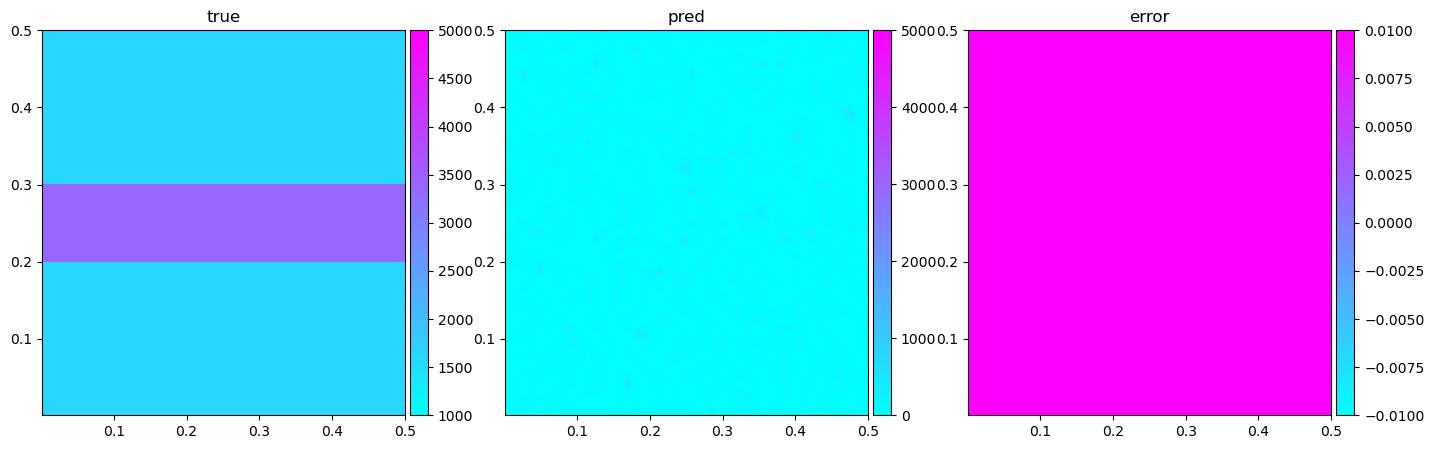

In [7]:
x_test = np.linspace(1.0, 500.0, 500) / x0
z_test = np.linspace(1.0, 500.0, 500) / z0
xz_test = tensor_grid([z_test, x_test])
xz_test[:, [0, 1]] = xz_test[:, [1, 0]]

c_pred = inverse_model(tf.constant(xz_test, dtype = tf.float32), training = False)*c0
def c_func(x, z):
	return np.piecewise(z, [z > 300, (z >= 200) & (z <= 300), z < 200], [1500, 3500, 1500])
c_true = c_func(xz_test[:, 0:1]*x0, xz_test[:, 1:2]*z0)

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cool
norm = Normalize(vmin=1000, vmax=5000)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_true.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=0, vmax=5000)
im1 = ax[1].contourf(X, Z, c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Z, c_true.reshape((len(z_test), len(x_test)))-c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[2].set_title("error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

In [9]:
np.max(c_pred)

450.83066

In [10]:
np.min(c_pred)

-304.1627

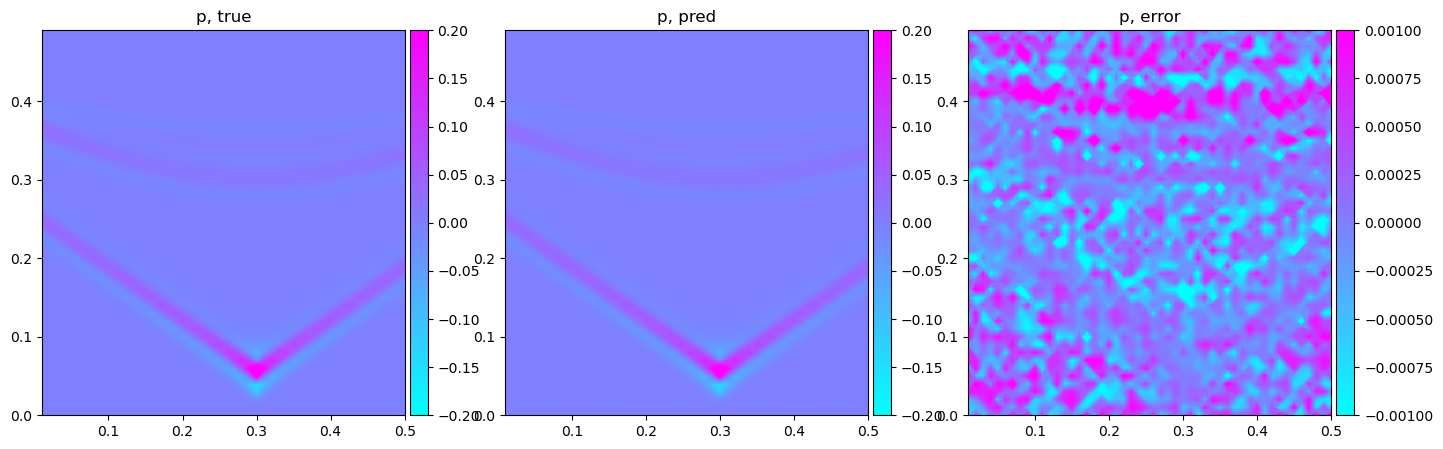

In [36]:
i = 5
p = loadmat("data/sr_{}.mat".format(int(x_s[i]*x0/dx)))["sr_{}".format(int(x_s[i]*x0/dx))]

x_test = np.linspace(10.0, 500.0, 50) / x0
z_test = np.array([10]) / z0
t_test = np.linspace(0.0, 0.49, 50) / t0
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]

xzts = np.hstack([xzt_test, x_s[i]*np.ones_like(xzt_test[:, 0:1])])
out = direct_model(tf.constant(xzts, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-0.2, vmax=0.2)

X, T = np.meshgrid(x_test, t_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("p, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-0.2, vmax=0.2)
im1 = ax[1].contourf(X, T, out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("p, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-3, vmax=1e-3)
im2 = ax[2].contourf(X, T, p-out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[2].set_title("p, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

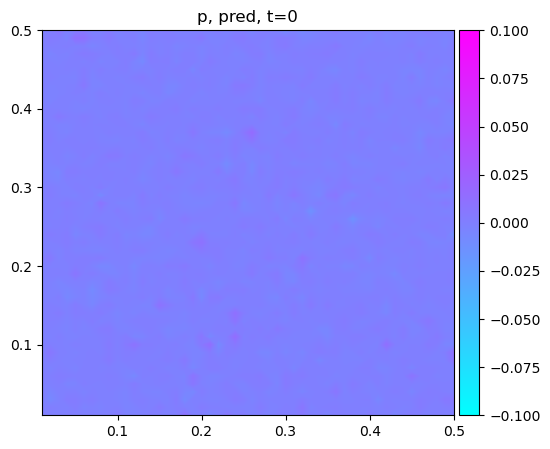

In [37]:
i = 0

x_test = np.linspace(10.0, 500.0, 50) / x0
z_test = np.linspace(10.0, 500.0, 50) / z0
t_test = np.array([0]) / t0
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]

xzts = np.hstack([xzt_test, x_s[i]*np.ones_like(xzt_test[:, 0:1])])
out = direct_model(tf.constant(xzts, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-0.1, vmax=0.1)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax.contourf(X, Z, out[:, 0:1].numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax.set_title("p, pred, t=0")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()